# MECHANICAL EFFECT PRODUCED BY PHOTOSWITCHABLE REACTIONS: INSIGHTS FROM MOLECULAR SIMULATIONS

In [2]:
# Reload all modules
# This is useful when you need to edit a module without
# closing the notebook.

%load_ext autoreload
%autoreload 2

In [3]:
# Load common modules
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import itertools as it
from scipy.constants import N_A
import statistics
import statsmodels.api as sm

from matplotlib.patches import ConnectionPatch
import matplotlib as mpl

import pyblock

In [4]:
# Modules STAMPTOOLS
from stamptools.analysis import load_data, get_distances_from_cm, rdf_from_dist, load_log
from stamptools.stamp import STAMP
from stamptools.stamptools import read_geometry_file

In [5]:
# submodule stamptools with notebooks tools
from stamptools import nbconfig

In [6]:
# Load my parameters in the matplotlib setting
plt.rcParams.update(nbconfig.MplotParam)

In [7]:
# Colors are defined for each replica.
import matplotlib.colors as mcolors

In [8]:
# mpl.rcParams

In [9]:
# toFigures = "/home/ovillegas/Documents/ARTICLE01/figures"
toFigures = "/home/ovillegas/figures"

class ImagesCount:
    def __init__(self, output):
        self.output = output
        self.count = 0
        
    def saveFig(self, name):
        self.count += 1
        name = "img_%04d_" % self.count + name
        print("Image %d saved!" % self.count)
        print(f"{self.output}/{name}")
        return nbconfig.save_fig(name, self.output)
    
    def resetCount(self):
        self.count = 0
        
    def subtract_one(self):
        if self.count == 0:
            pass
        else:
            self.count -= 1
            
    def set_count(self, count):
        self.count = count
    
# SaveFig = ImagesCount(toFigures)

In [10]:
def saveFig(name):
    return nbconfig.save_fig(name, toFigures)

In [11]:
# Main folder

home_stamp="/home/ovillegas/exp.azob.stamp.3"
home_gro="/home/ovillegas/exp.azob.gmx"

In [12]:
def format_time(seconds):
    """Convert seconds to formated time."""
    minutes, seconds = divmod(int(seconds), 60)
    hours, minutes = divmod(minutes, 60)
    days, hours = divmod(hours, 24)
    return f"{days:02d}:{hours:02d}:{minutes:02d}:{seconds:02d}"

def status_logs(file):
    """Returns CPU time information from the log."""
    logInfo, status = load_log(file, use_xyz=False)
    # logInfo["time"] *= 1e12 # ps
    
    cpu = logInfo["cpu"].values
    peaks, _ = find_peaks(cpu, distance=150)
    last_peak = len(cpu)- 1
    peaks = np.append(peaks, last_peak)
    
    time_secs = sum(cpu[peaks])
    formatted_time = format_time(time_secs)
    
    return {
        "cpu": cpu,
        "peaks": peaks,
        "simulationTime": logInfo["time"].values[-1],
        "elapsedTime": formatted_time,
        "status": status
    }

def isFinished(x, color):
    #   f"background: {color};"
    #   f"color: {color};"
    return np.where(x == "finished", f"background: {color};", None)

In [13]:
def isNotMSD(x, color):
    #   f"background: {color};"
    #   f"color: {color};"
    return np.where(x == "x", f"background: {color};", None)

In [14]:
def stretched_exponetial(t, t_c, beta):
    return np.exp(-(t/t_c)**beta)

In [15]:
def stretched_exponetial2(t, A, t_c1, beta1, t_c2, beta2):
    return A * np.exp(-(t/t_c1)**beta1) + (1 - A) * np.exp(-(t/t_c2)**beta2)

In [16]:
PHO = ["ca", "ha", "oh", "ho", "ne", "nf", "cb"]
POL = ["CT", "CM", "HT", "HM"]

pairs_lists = {
    "PHO-POL": [],
    "POL-POL": [],
    "PHO-PHO": [],
}

for i, j in it.product(PHO, POL):
    pairs_lists["PHO-POL"].append(f"{i}-{j}")
    
for i, j in it.product(POL, POL):
    pairs_lists["POL-POL"].append(f"{i}-{j}")
    
for i, j in it.product(PHO, PHO):
    pairs_lists["PHO-PHO"].append(f"{i}-{j}")

In [17]:
def readPotentialE(file, step=1, original=False):
    rows = []
    names = list()
    with open(file, "r") as f:
        line = f.readline()
        names = line.replace("# tempsPhysique (s)", "time").split()
        
        for i, line in enumerate(f):
            if not line.startswith("#"):
                if i % step == 0:
                    rows.append(np.array(line.split()).astype(np.float64))
        
    rows = np.array(rows)        
    dat = pd.DataFrame(rows, columns=names)
    dat["time"] *= 1e12  # to ps
    
    if original:
        return dat
    
    fdat = pd.DataFrame()
    for pair in pairs_lists:
        pairList = pairs_lists[pair]
        
        try:
            ndat = dat.loc[:, pairList]
            # ndat = ndat.sum(axis=1) * N_A / 1000  # to kJ/mol
            ndat = ndat.sum(axis=1) # * N_A / 1000  # to kJ/mol
            
            fdat[pair] = ndat

        except KeyError:
            continue

    fdat["time"] = dat["time"].copy()

    return fdat

In [18]:
def my_mode(x):
    return statistics.mode(x)

In [19]:
def isSpherical(x):
    if x <= 0.5:
        return "sphere"
    elif x > 0.5:
        return "lineal"

In [20]:
def get_log2_av(data, tau):
    """
    data: numpy arrays
    """
    
    log_av_data = []
    log_av_tau = []
    for j in range(1, int(np.log2(len(data))) + 1):
        ##print(j)
        sumpar = [i for i in range(2**(j-1), 2**j)]
        sumpar = np.array(sumpar, dtype=np.int64) - 1
        ##print(data[sumpar])
        ##print(sum(data[sumpar]))
        ##print((1/(2**j - 2**(j-1))) * sum(data[sumpar]))
        log_av_data.append((1/(2**j - 2**(j-1))) * sum(data[sumpar]))
        log_av_tau.append((1/(2**j - 2**(j-1))) * sum(tau[sumpar]))
        ##print("="*80)
    
    # return pd.DataFrame({"logAv_data":log_av_data[1:], "logAv_tau":log_av_tau[1:]})
    return log_av_data, log_av_tau

In [21]:
def rot(x, deg=0.0):
    """Rotate the negative angles."""
    if x < deg:
        return x + 360
    else:
        return x

In [22]:
def get_acorr(angle):
    cos_a = np.cos(np.deg2rad(angle))
    acorr = sm.tsa.acf(cos_a, nlags = len(cos_a)-1)
    return acorr

### Format definitions

In [23]:
labels = {"trans":"$trans$", "cis":r"$cis$", "s1":"S$_1$"}

systems = ["trans", "cis", "s1"]

replicas = ["0", "1", "2", "3", "4"]

SaveFigPaper = ImagesCount("/home/ovillegas/figures/ImagesPaper")

colors = {"THF": "tab:blue", "PB": "tab:orange", "PB-OH": "purple"}

In [23]:
POLPROP2 = {
    "Rg": {
        "color": "#2a90a6",
        "binwidth": .1,
        "xlim": [0.5, 3.0],
        "label": "Radius of gyration (nm)",
        "units": "nm",
        "clim": [.0, 0.1]
    },
    "dmax": {
        "color": "#5b557b",
        "binwidth": .3,
        "xlim": [1.0, 9.0],
        "label": "Max. distance (nm)",
        "units": "nm",
        "clim": [.0, 0.1]
    },
    "k2": {
        "color": "#fea6ad",
        "binwidth": .05,
        "xlim": [0, 1],
        "label": "Shape anisotropy",
        "units": "",
        "clim": [.0, 0.1]
    },
    "rdf": {
        "color": "#3293f0",
        "xlim": [0.25, 2.5],
        "label": "g(r) PC - PB",
        "units": ""
        
    },
    "rdf_CM": {
        "color": "purple",
        "xlim": [0.25, 2.5],
        "label": r"g(r) PC$_{CM}$ - PB$_{CM}$",
        "units": ""
        
    },
    "distance": {
        "color": "#66c0c0",
        "binwidth": .01,
        "xlim": [0.1, 1.0],
        "label": "distance",
        "units": "nm"
    }
}

## Impact of the Polymeric Matrix on the Photochrome

### Photochrome geometry

#### parameters definitions

In [24]:
Param_cnnc = {
    "trans":{
        "step": 1.0,
        "center": 180.0,
        "edge": 20.0,
        "deg": 0.0
    },
    "cis":{
        "step": 1.0,
        "center": 0.0,
        "edge": 20.0,
        "deg": -90.0
    },
    "s1":{
        "step": 1.0,
        "center": 0.0,
        "edge": 180.0,
        "deg": -180.0
    }
}

Param_ccnn = {
    "trans":{
        "torsion": ["d_ccnn_1", "d_ccnn_3"],
        "step": 1.0,
        "center": 90.0,
        "edge": 210.0,
        "deg": -90.0
    },
    "cis":{
        "torsion": ["d_ccnn_1", "d_ccnn_3"],
        "step": 1.0,
        "center": 0.0,
        "edge": 210.0,
        "deg": -180.0
    },
    "s1":{
        "torsion": ["d_ccnn_1", "d_ccnn_4"],
        "step": 1.0,
        "center": 90.0,
        "edge": 210.0,
        "deg": -100.0
    }
}

Param_cnn = {
    "trans":{
        "angle": ["a_cnn_1", "a_cnn_2"],
        "step": 1.0,
        "center": 115.0,
        "edge": 20.0,
        "deg": -100.0
    },
    "cis":{
        "angle": ["a_cnn_1", "a_cnn_2"],
        "step": 1.0,
        "center": 110.0,
        "edge": 20.0,
        "deg": -100.0
    },
    "s1":{
        "angle": ["a_cnn_1", "a_cnn_2"],
        "step": 1.0,
        "center": 125.0,
        "edge": 20.0,
        "deg": -100.0
    }
}

Param_color = {
    "POL": "#fca561",
    "PB": "#fca561",
    "THF": "#39b1c5"
}

Param_style = {
    "POL": ".",
    "PB": ".",
    "THF": "x"
}

In [207]:
# Load all file with Geometry information
GEOM = {
    "PB": {"trans": {}, "cis": {}},
    "THF": {"trans": {}, "cis": {}}
}

for system in GEOM:
    for iso in ["trans", "cis"]:
        for r in replicas: 
            if system == "PB":
                path_file = "{}/{}/6_prod_{}/Geometry_mol.csv".format(home_stamp, iso, r)
            elif system == "THF":
                path_file = "{}/{}.thf/{}/md/Geometry_mol.csv".format(home_gro, iso, r)

            data = read_geometry_file(
                path_file,
                freq=1.,
                t0=1.
                )
            
            ###############
            if iso == "trans" or iso == "s1":
                data["d_ccnn_1"] = data["d_ccnn_1"].apply(lambda x : nbconfig.rot(x, deg=-100))
                data["d_ccnn_3"] = data["d_ccnn_3"].apply(lambda x : nbconfig.rot(x, deg=-100))
                data["d_ccnn_2"] = data["d_ccnn_2"].apply(lambda x : nbconfig.rot(x, deg=-100))
                data["d_ccnn_4"] = data["d_ccnn_4"].apply(lambda x : nbconfig.rot(x, deg=-100))
                
                #data["ccnn0"] = (data["d_ccnn_1"] + data["d_ccnn_3"]) / 2
                #data["ccnn180"] = (data["d_ccnn_2"] + data["d_ccnn_4"]) / 2
            
            ###############
            
            GEOM[system][iso][r] = data.copy()


GEOMtot = {}
for system in GEOM:
    GEOMtot[system] = {}
    for iso in GEOM[system]:
        GEOMtot[system][iso] = []
        for r in GEOM[system][iso]:
            GEOMtot[system][iso].append(GEOM[system][iso][r])

        GEOMtot[system][iso] = pd.concat(GEOMtot[system][iso], ignore_index=True)


In [ ]:
# Load all file with Geometry information
GEOM = {
    "POL": {"trans": {}, "cis": {}, "s1": {}},
    "THF": {"cis": {}, "trans": {}, "s1": {}}
}

for system in GEOM:
    for iso in ["trans", "cis"]:
        for r in replicas: 
            if system == "POL":
                path_file = "{}/{}/6_prod_{}/Geometry_mol.csv".format(home_stamp, iso, r)
            elif system == "THF":
                path_file = "{}/azob_{}.thf.densf/md{}/Geometry_mol.csv".format(home_gro, iso, r)

            data = read_geometry_file(
                path_file,
                freq=1.,
                t0=1.
                )
            
            ###############
            if iso == "trans" or iso == "s1":
                data["d_ccnn_1"] = data["d_ccnn_1"].apply(lambda x : nbconfig.rot(x, deg=-100))
                data["d_ccnn_3"] = data["d_ccnn_3"].apply(lambda x : nbconfig.rot(x, deg=-100))
                data["d_ccnn_2"] = data["d_ccnn_2"].apply(lambda x : nbconfig.rot(x, deg=-100))
                data["d_ccnn_4"] = data["d_ccnn_4"].apply(lambda x : nbconfig.rot(x, deg=-100))
                
                #data["ccnn0"] = (data["d_ccnn_1"] + data["d_ccnn_3"]) / 2
                #data["ccnn180"] = (data["d_ccnn_2"] + data["d_ccnn_4"]) / 2
            
            ###############
            
            GEOM[system][iso][r] = data.copy()


GEOMtot = {}
for system in GEOM:
    GEOMtot[system] = {}
    for iso in GEOM[system]:
        GEOMtot[system][iso] = []
        for r in GEOM[system][iso]:
            GEOMtot[system][iso].append(GEOM[system][iso][r])

        GEOMtot[system][iso] = pd.concat(GEOMtot[system][iso], ignore_index=True)


In [167]:
kwargs_bin = {
    "step": 1.0,
    "center": 90.0,
    "edge": 230.0,
    "deg": -90.0
}

In [ ]:
t_ccnn_ts = {
    "ccnn0": ["d_ccnn_1", "d_ccnn_3"],
    "ccnn180": ["d_ccnn_2", "d_ccnn_4"]
}

t_ccnn_c = {
    "ccnn_p": ["d_ccnn_1", "d_ccnn_3"],
    "ccnn_m": ["d_ccnn_2", "d_ccnn_4"]
}

for sol in ["THF", "POL"]:
    for iso in ["cis"]:
        for r in GEOM[sol][iso]:
            data = GEOM[sol][iso][r]
            
            bins = np.arange(
                0.0 - 230.,
                0.0 + 230. + 1.0,
                1.0
            )
            
            fig, ax = plt.subplots()
            ax.set_title(f"{sol} - {iso} - {r}")
            if iso == "trans" or iso == "s1":
                for t in ["ccnn0", "ccnn180"]:
                    vals_t = np.array(list(data[t_ccnn_ts[t][0]].values) + list(data[t_ccnn_ts[t][1]].values))
                    ax.hist(vals_t, bins=bins, label=f"{t}")
                ax.legend()
            
            elif iso == "cis":
                for t in ["ccnn_p", "ccnn_m"]:
                    vals_t = np.array(list(data[t_ccnn_c[t][0]].values) + list(data[t_ccnn_c[t][1]].values))
                    ax.hist(vals_t, bins=bins, label=f"{t}")
                ax.legend()
                

            

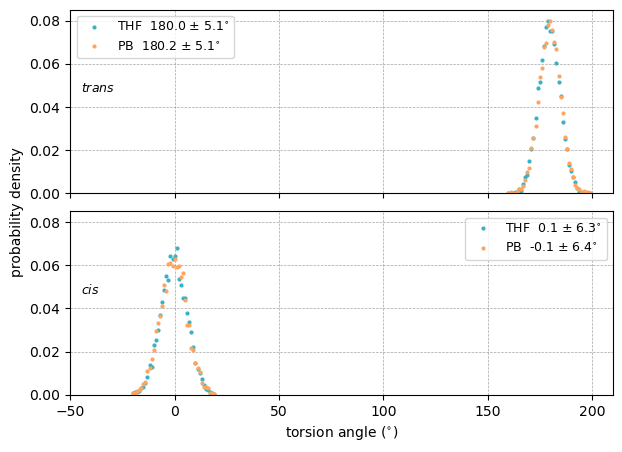

In [208]:
torsion = "d_cnnc"
grid_lines_x = np.arange(0, 0.1 + 0.01, 0.01)
grid_lines_y = np.arange(-150, 200 + 50, 50)

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(7,5))

fig.subplots_adjust(hspace=0.1, wspace=0.1)

#fig.suptitle(
#    f"Torsion C-N=N-C",
#    fontweight="bold",
#    fontsize=14,
#    y=0.92,
#    x=0.5,
#    ha = "center"
#)

systems = ['trans', 'cis']

for i, isomer in enumerate(systems):
    for sol in ["THF", "PB"]:
        data = GEOMtot[sol][isomer].copy()
        data[torsion] = data[torsion].apply(lambda x: rot(x, Param_cnnc[isomer]["deg"]))
        bins = np.arange(
            Param_cnnc[isomer]["center"] - Param_cnnc[isomer]["edge"],
            Param_cnnc[isomer]["center"] + Param_cnnc[isomer]["edge"] + Param_cnnc[isomer]["step"],
            Param_cnnc[isomer]["step"]
        )
        hist, _ = np.histogram(data[torsion], bins=bins, density=True)
        if isomer == "s1":
            ndata = data[data[torsion] < Param_cnnc[isomer]["center"]]
        else:
            ndata = data.copy()
        ax[i].plot(
            bins[:-1],
            hist, ".",
            label = sol.replace("POL", "PB") + r"  %.1f $\pm$ %.1f$^{\circ}$" % (ndata[torsion].mean(), ndata[torsion].std()),
            color = Param_color[sol],
            ms = 4.
        )
        
    ax[i].set_xlim(-50., 210.)
    ax[i].set_ylim(ymin=0., ymax=0.085)

    ax[i].text(
            0.02, 0.55,
            "{}".format(labels[isomer]), transform=ax[i].transAxes,
            ha="left",
            rotation=0, fontsize=9
        )
    # ax[i].set_title(t)
    ax[i].legend(fontsize=9)
    ax[i].set_xlabel(r"torsion angle ($^{\circ}$)")
    ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    # ax[i].xaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    if i != 1:
        # ax[i].get_xaxis().set_visible(False)
        #ax[i].set_xlabel("")
        #ax[i].set_xticks([])
        #ax[i].xaxis.set_ticks([])
        # ax[i].xaxis.set_grid()
        ax[i].set_xticklabels([])

    # ax[i].xaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
        
    # ax[i].set_yticks([0., 0.04, 0.08])
    if i == 1:
        ax[i].set_ylabel("probability density", y=1.)
        
            
# saveFig(f"torsion_{torsion}_all.png")
# SaveFigPaper.saveFig(f"torsion_{torsion}_all_new.png")
plt.show()

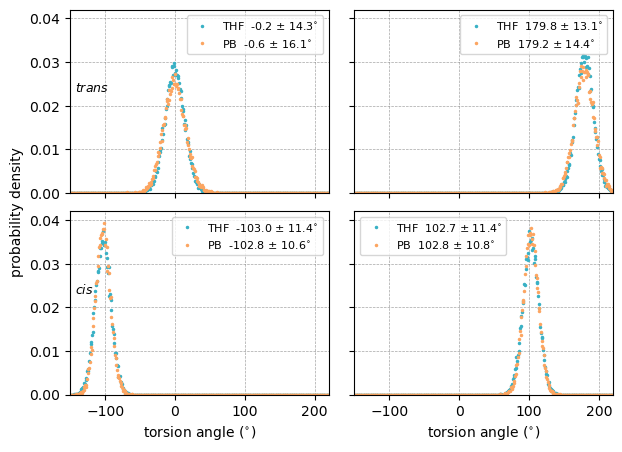

In [209]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(7,5))

fig.subplots_adjust(hspace=0.1, wspace=0.1)

# fig.suptitle(
#     f"Torsion C=C-N=N",
#     fontweight="bold",
#     fontsize=14,
#     y=0.92,
#     x=0.5,
#     ha = "center"
# )

t_ccnn_ts_THF = {
    "ccnn0": ["d_ccnn_2", "d_ccnn_3"],
    "ccnn180": ["d_ccnn_1", "d_ccnn_4"]
}

t_ccnn_ts_PB = {
    "ccnn0": ["d_ccnn_1", "d_ccnn_3"],
    "ccnn180": ["d_ccnn_2", "d_ccnn_4"]
}

torsion_ccnn_t = {"PB": t_ccnn_ts_PB, "THF": t_ccnn_ts_THF}

t_ccnn_c_THF = {
    "ccnn_p": ["d_ccnn_2", "d_ccnn_3"],
    "ccnn_m": ["d_ccnn_1", "d_ccnn_4"]
}

t_ccnn_c_PB = {
    "ccnn_p": ["d_ccnn_1", "d_ccnn_3"],
    "ccnn_m": ["d_ccnn_2", "d_ccnn_4"]
}

torsion_ccnn_c = {"PB": t_ccnn_c_PB, "THF": t_ccnn_c_THF}

systems = ['trans', 'cis']

torsions_types = [
    ["ccnn0", "ccnn180"],
    ["ccnn_m", "ccnn_p"],
    ["ccnn0", "ccnn180"]
]

for i, isomer in enumerate(systems):
    for sol in ["THF", "PB"]:
        data = GEOMtot[sol][isomer].copy()
        for j in range(2):
            torsion = torsions_types[i][j]
            # print(torsion, i, j)

            bins = np.arange(
                0.0 - 230.,
                0.0 + 230. + 1.0,
                1.0
            )
            
            if isomer == "trans" or isomer == "s1":
                vals_t = np.array(list(data[torsion_ccnn_t[sol][torsion][0]].values) + list(data[torsion_ccnn_t[sol][torsion][1]].values))
                
            elif isomer == "cis":
                vals_t = np.array(list(data[torsion_ccnn_c[sol][torsion][0]].values) + list(data[torsion_ccnn_c[sol][torsion][1]].values))    
            
            hist, _ = np.histogram(vals_t, bins=bins, density=True)
            
            if isomer == "trans" and sol == "THF":
                if j == 0:
                    ndata = vals_t[vals_t < 90.]
                elif j == 1:
                    ndata = vals_t[vals_t > 90.]
            else:
                ndata = vals_t.copy()
                
            ax[i,j].plot(
                bins[:-1],
                hist, ".", ms = 3,
                label = sol.replace("POL", "PB") + r"  %.1f $\pm$ %.1f$^{\circ}$" % (ndata.mean(), ndata.std()),
                color = Param_color[sol]
            )
            ax[i, j].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
            if i != 1:
                # ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].set_xticklabels([])
                
            if j == 1:
                # ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].set_yticklabels([])

            ax[i, j].set_xlim(-150., 220.)
            # ax[i, j].set_ylim(ymin=0.)
            ax[i, j].legend(fontsize=8)
            ax[i, j].set_xlabel(r"torsion angle ($^{\circ}$)")
            
            ax[i, j].set_ylim(0., 0.042)
            # ax[i, j].set_yticks([])
            
    ax[i, 0].text(
        0.02, 0.55,
        "{}".format(labels[isomer]), transform=ax[i, 0].transAxes,
        ha="left",
        rotation=0, fontsize=9
    )
    
ax[1, 0].set_ylabel("probability density", y=1.0)
            
            
# saveFig(f"torsion_d_ccnn_2_news.png")
# SaveFigPaper.saveFig(f"torsion_d_ccnn_2_all.png")
plt.show()

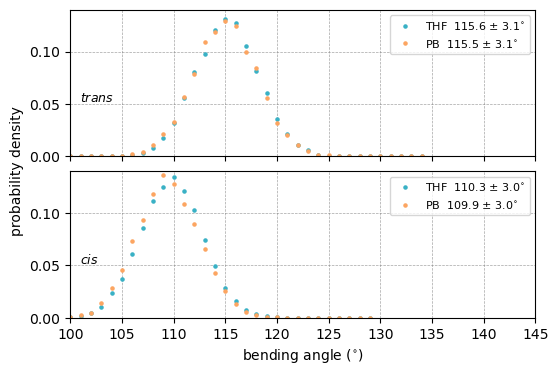

In [206]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(6,4))

fig.subplots_adjust(hspace=0.1, wspace=0.1)

# fig.suptitle(
#     f"Angle C-N=N",
#     fontweight="bold",
#     fontsize=12,
#     y=0.92,
#     x=0.5,
#     ha = "center"
# )

systems = ['trans', 'cis']

for i, isomer in enumerate(systems):
    for sol in ["THF", "PB"]:
        data = GEOMtot[sol][isomer].copy()
        
        vals = np.array(list(data["a_cnn_1"]) + list(data["a_cnn_1"]))
        
        bins = np.arange(
                Param_cnn[isomer]["center"] - Param_cnn[isomer]["edge"],
                Param_cnn[isomer]["center"] + Param_cnn[isomer]["edge"] + Param_cnn[isomer]["step"],
                Param_cnn[isomer]["step"]
            )
        
        hist, _ = np.histogram(vals, bins=bins, density=True)
        ax[i].plot(
                bins[:-1],
                hist, ".", ms = 4.5,
                label = sol.replace("POL", "PB") + r"  %.1f $\pm$ %.1f$^{\circ}$" % (vals.mean(), vals.std()),
                color = Param_color[sol]
        )
                
        if i != 1:
            ax[i].set_xticklabels([])
            
        #if j == 1:
        #    # ax[i, j].get_xaxis().set_visible(False)
        #    ax[i].set_yticklabels([])

        ax[i].set_xlim(100., 145.)
        #ax[i, j].set_ylim(ymin=0.)
        ax[i].legend(fontsize=8)
        ax[i].set_xlabel(r"bending angle ($^{\circ}$)")
            
        ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
            
        ax[i].set_ylim(0., 0.14)
        # ax[i, j].set_yticks([])

    ax[i].text(
        0.02, 0.37,
        "{}".format(labels[isomer]), transform=ax[i].transAxes,
        ha="left",
        rotation=0, fontsize=9
    )
    
ax[1].set_ylabel("probability density", y=1.0)
            
saveFig(f"angle_a_cnn_news.png")
# SaveFigPaper.saveFig(f"angle_a_cnn_all.png")
plt.show() 

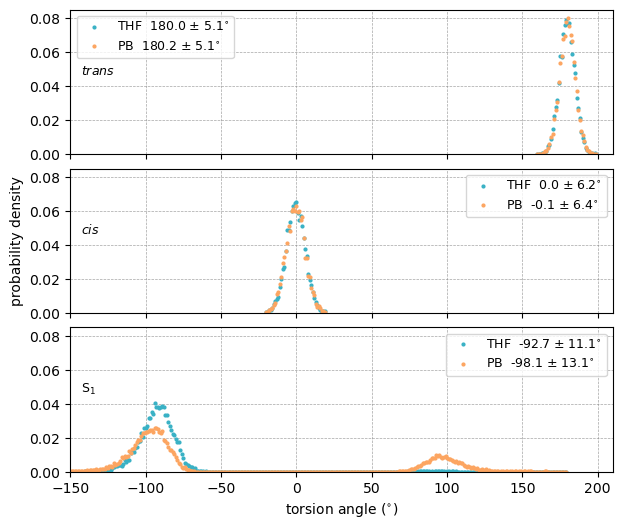

In [28]:
torsion = "d_cnnc"
grid_lines_x = np.arange(0, 0.1 + 0.01, 0.01)
grid_lines_y = np.arange(-150, 200 + 50, 50)

fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(7,6))

fig.subplots_adjust(hspace=0.1, wspace=0.1)

#fig.suptitle(
#    f"Torsion C-N=N-C",
#    fontweight="bold",
#    fontsize=14,
#    y=0.92,
#    x=0.5,
#    ha = "center"
#)

systems = ['trans', 'cis', 's1']

for i, isomer in enumerate(systems):
    for sol in ["THF", "POL"]:
        data = GEOMtot[sol][isomer].copy()
        data[torsion] = data[torsion].apply(lambda x: rot(x, Param_cnnc[isomer]["deg"]))
        bins = np.arange(
            Param_cnnc[isomer]["center"] - Param_cnnc[isomer]["edge"],
            Param_cnnc[isomer]["center"] + Param_cnnc[isomer]["edge"] + Param_cnnc[isomer]["step"],
            Param_cnnc[isomer]["step"]
        )
        hist, _ = np.histogram(data[torsion], bins=bins, density=True)
        if isomer == "s1":
            ndata = data[data[torsion] < Param_cnnc[isomer]["center"]]
        else:
            ndata = data.copy()
        ax[i].plot(
            bins[:-1],
            hist, ".",
            label = sol.replace("POL", "PB") + r"  %.1f $\pm$ %.1f$^{\circ}$" % (ndata[torsion].mean(), ndata[torsion].std()),
            color = Param_color[sol],
            ms = 4.
        )
        
    ax[i].set_xlim(-150., 210.)
    ax[i].set_ylim(ymin=0., ymax=0.085)

    ax[i].text(
            0.02, 0.55,
            "{}".format(labels[isomer]), transform=ax[i].transAxes,
            ha="left",
            rotation=0, fontsize=9
        )
    # ax[i].set_title(t)
    ax[i].legend(fontsize=9)
    ax[i].set_xlabel(r"torsion angle ($^{\circ}$)")
    ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    # ax[i].xaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    if i != 2:
        # ax[i].get_xaxis().set_visible(False)
        #ax[i].set_xlabel("")
        #ax[i].set_xticks([])
        #ax[i].xaxis.set_ticks([])
        # ax[i].xaxis.set_grid()
        ax[i].set_xticklabels([])

    # ax[i].xaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
        
    # ax[i].set_yticks([0., 0.04, 0.08])
    if i == 1:
        ax[i].set_ylabel("probability density")
        
            
# saveFig(f"torsion_{torsion}_all.png")
# SaveFigPaper.saveFig(f"torsion_{torsion}_all.png")
plt.show()

Distributions observed for dihedrals CNNC and compared for each isomer in PB and THF

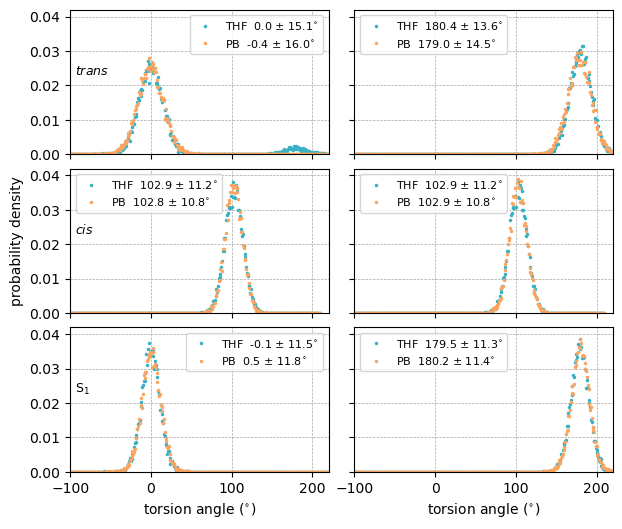

In [32]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(7,6))

fig.subplots_adjust(hspace=0.1, wspace=0.1)

# fig.suptitle(
#     f"Torsion C=C-N=N",
#     fontweight="bold",
#     fontsize=14,
#     y=0.92,
#     x=0.5,
#     ha = "center"
# )

systems = ['trans', 'cis', 's1']

for i, isomer in enumerate(systems):
    for sol in ["THF", "POL"]:
        data = GEOMtot[sol][isomer].copy()
        for j, torsion in enumerate(Param_ccnn[isomer]["torsion"]):
            if j==1 and isomer == "trans" and sol == "POL":
                torsion = "d_ccnn_4"
            if j==1 and isomer == "trans" and sol == "THF":
                torsion = "d_ccnn_4"
            if j==1 and isomer == "cis" and sol == "THF":
                torsion = "d_ccnn_1"
            data[torsion] = data[torsion].apply(lambda x: rot(x, Param_ccnn[isomer]["deg"]))
            bins = np.arange(
                Param_ccnn[isomer]["center"] - Param_ccnn[isomer]["edge"],
                Param_ccnn[isomer]["center"] + Param_ccnn[isomer]["edge"] + Param_ccnn[isomer]["step"],
                Param_ccnn[isomer]["step"]
            )
            hist, _ = np.histogram(data[torsion], bins=bins, density=True)
            if isomer == "trans" and sol == "THF" and torsion == "d_ccnn_1":
                ndata = data[data[torsion] < Param_ccnn[isomer]["center"]]
            else:
                ndata = data.copy()
                
            ax[i,j].plot(
                bins[:-1],
                hist, ".", ms = 3,
                label = sol.replace("POL", "PB") + r"  %.1f $\pm$ %.1f$^{\circ}$" % (ndata[torsion].mean(), ndata[torsion].std()),
                color = Param_color[sol]
            )
            ax[i, j].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
            if i != 2:
                # ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].set_xticklabels([])
                
            if j == 1:
                # ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].set_yticklabels([])

            ax[i, j].set_xlim(-100., 220.)
            # ax[i, j].set_ylim(ymin=0.)
            ax[i, j].legend(fontsize=8)
            ax[i, j].set_xlabel(r"torsion angle ($^{\circ}$)")
            
            ax[i, j].set_ylim(0., 0.042)
            # ax[i, j].set_yticks([])
            
    ax[i, 0].text(
        0.02, 0.55,
        "{}".format(labels[isomer]), transform=ax[i, 0].transAxes,
        ha="left",
        rotation=0, fontsize=9
    )
    
ax[1, 0].set_ylabel("probability density")
            
            
# saveFig(f"torsion_d_ccnn_2_all.png")
# SaveFigPaper.saveFig(f"torsion_d_ccnn_2_all.png")
plt.show()

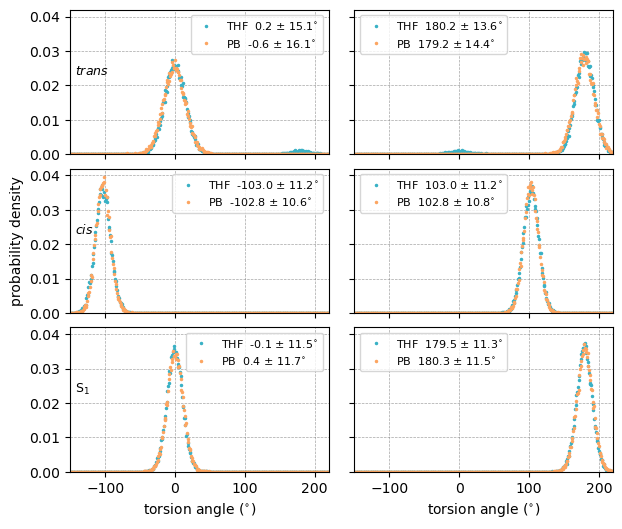

In [92]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(7,6))

fig.subplots_adjust(hspace=0.1, wspace=0.1)

# fig.suptitle(
#     f"Torsion C=C-N=N",
#     fontweight="bold",
#     fontsize=14,
#     y=0.92,
#     x=0.5,
#     ha = "center"
# )

t_ccnn_ts = {
    "ccnn0": ["d_ccnn_1", "d_ccnn_3"],
    "ccnn180": ["d_ccnn_2", "d_ccnn_4"]
}

t_ccnn_c = {
    "ccnn_p": ["d_ccnn_1", "d_ccnn_3"],
    "ccnn_m": ["d_ccnn_2", "d_ccnn_4"]
}

systems = ['trans', 'cis', 's1']

torsions_types = [
    ["ccnn0", "ccnn180"],
    ["ccnn_m", "ccnn_p"],
    ["ccnn0", "ccnn180"]
]

for i, isomer in enumerate(systems):
    for sol in ["THF", "POL"]:
        data = GEOMtot[sol][isomer].copy()
        for j in range(2):
            torsion = torsions_types[i][j]
            # print(torsion, i, j)

            bins = np.arange(
                0.0 - 230.,
                0.0 + 230. + 1.0,
                1.0
            )
            
            if isomer == "trans" or isomer == "s1":
                vals_t = np.array(list(data[t_ccnn_ts[torsion][0]].values) + list(data[t_ccnn_ts[torsion][1]].values))
                
            elif isomer == "cis":
                vals_t = np.array(list(data[t_ccnn_c[torsion][0]].values) + list(data[t_ccnn_c[torsion][1]].values))    
            
            hist, _ = np.histogram(vals_t, bins=bins, density=True)
            
            if isomer == "trans" and sol == "THF":
                if j == 0:
                    ndata = vals_t[vals_t < 90.]
                elif j == 1:
                    ndata = vals_t[vals_t > 90.]
            else:
                ndata = vals_t.copy()
                
            ax[i,j].plot(
                bins[:-1],
                hist, ".", ms = 3,
                label = sol.replace("POL", "PB") + r"  %.1f $\pm$ %.1f$^{\circ}$" % (ndata.mean(), ndata.std()),
                color = Param_color[sol]
            )
            ax[i, j].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
            if i != 2:
                # ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].set_xticklabels([])
                
            if j == 1:
                # ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].set_yticklabels([])

            ax[i, j].set_xlim(-150., 220.)
            # ax[i, j].set_ylim(ymin=0.)
            ax[i, j].legend(fontsize=8)
            ax[i, j].set_xlabel(r"torsion angle ($^{\circ}$)")
            
            ax[i, j].set_ylim(0., 0.042)
            # ax[i, j].set_yticks([])
            
    ax[i, 0].text(
        0.02, 0.55,
        "{}".format(labels[isomer]), transform=ax[i, 0].transAxes,
        ha="left",
        rotation=0, fontsize=9
    )
    
ax[1, 0].set_ylabel("probability density")
            
            
# saveFig(f"torsion_d_ccnn_2_all.png")
# SaveFigPaper.saveFig(f"torsion_d_ccnn_2_all.png")
plt.show()

Distributions observed for dihedrals CCNN and compared for each isomer in PB and THF

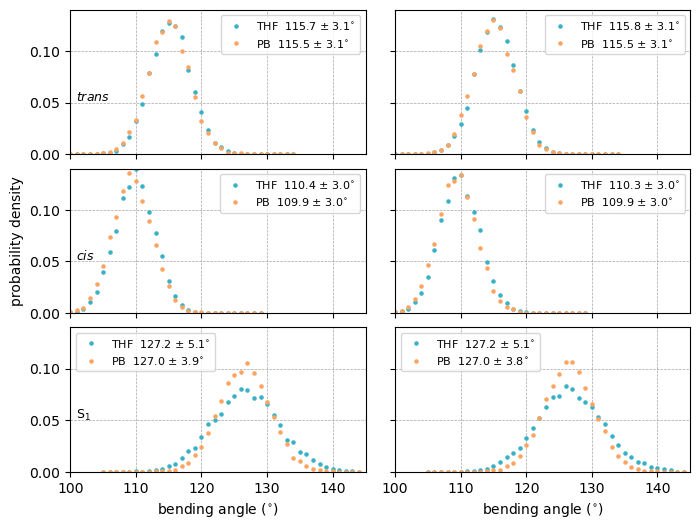

In [29]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(8,6))

fig.subplots_adjust(hspace=0.1, wspace=0.1)

# fig.suptitle(
#     f"Angle C-N=N",
#     fontweight="bold",
#     fontsize=12,
#     y=0.92,
#     x=0.5,
#     ha = "center"
# )

systems = ['trans', 'cis', 's1']

for i, isomer in enumerate(systems):
    for sol in ["THF", "POL"]:
        data = GEOMtot[sol][isomer].copy()
        for j, angle in enumerate(Param_cnn[isomer]["angle"]):
            data[angle] = data[angle].apply(lambda x: rot(x, Param_cnn[isomer]["deg"]))
            bins = np.arange(
                Param_cnn[isomer]["center"] - Param_cnn[isomer]["edge"],
                Param_cnn[isomer]["center"] + Param_cnn[isomer]["edge"] + Param_cnn[isomer]["step"],
                Param_cnn[isomer]["step"]
            )
            hist, _ = np.histogram(data[angle], bins=bins, density=True)
            ax[i,j].plot(
                bins[:-1],
                hist, ".", ms = 4.5,
                label = sol.replace("POL", "PB") + r"  %.1f $\pm$ %.1f$^{\circ}$" % (data[angle].mean(), data[angle].std()),
                color = Param_color[sol]
            )
                
            if i != 2:
                ax[i, j].set_xticklabels([])
                
            if j == 1:
                # ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].set_yticklabels([])

            ax[i, j].set_xlim(100., 145.)
            #ax[i, j].set_ylim(ymin=0.)
            ax[i, j].legend(fontsize=8)
            ax[i, j].set_xlabel(r"bending angle ($^{\circ}$)")
            
            ax[i, j].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
            
            ax[i, j].set_ylim(0., 0.14)
            # ax[i, j].set_yticks([])

    ax[i, 0].text(
        0.02, 0.37,
        "{}".format(labels[isomer]), transform=ax[i, 0].transAxes,
        ha="left",
        rotation=0, fontsize=9
    )
    
ax[1, 0].set_ylabel("probability density")
            
# saveFig(f"angle_a_cnn_all.png")
# SaveFigPaper.saveFig(f"angle_a_cnn_all.png")
plt.show()

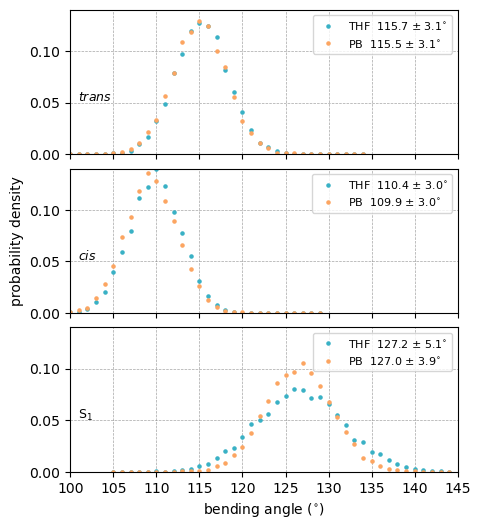

In [101]:
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(5,6))

fig.subplots_adjust(hspace=0.1, wspace=0.1)

# fig.suptitle(
#     f"Angle C-N=N",
#     fontweight="bold",
#     fontsize=12,
#     y=0.92,
#     x=0.5,
#     ha = "center"
# )

systems = ['trans', 'cis', 's1']

for i, isomer in enumerate(systems):
    for sol in ["THF", "POL"]:
        data = GEOMtot[sol][isomer].copy()
        
        vals = np.array(list(data["a_cnn_1"]) + list(data["a_cnn_1"]))
        
        bins = np.arange(
                Param_cnn[isomer]["center"] - Param_cnn[isomer]["edge"],
                Param_cnn[isomer]["center"] + Param_cnn[isomer]["edge"] + Param_cnn[isomer]["step"],
                Param_cnn[isomer]["step"]
            )
        
        hist, _ = np.histogram(vals, bins=bins, density=True)
        ax[i].plot(
                bins[:-1],
                hist, ".", ms = 4.5,
                label = sol.replace("POL", "PB") + r"  %.1f $\pm$ %.1f$^{\circ}$" % (vals.mean(), vals.std()),
                color = Param_color[sol]
        )
                
        if i != 2:
            ax[i].set_xticklabels([])
            
        #if j == 1:
        #    # ax[i, j].get_xaxis().set_visible(False)
        #    ax[i].set_yticklabels([])

        ax[i].set_xlim(100., 145.)
        #ax[i, j].set_ylim(ymin=0.)
        ax[i].legend(fontsize=8)
        ax[i].set_xlabel(r"bending angle ($^{\circ}$)")
            
        ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
            
        ax[i].set_ylim(0., 0.14)
        # ax[i, j].set_yticks([])

    ax[i].text(
        0.02, 0.37,
        "{}".format(labels[isomer]), transform=ax[i].transAxes,
        ha="left",
        rotation=0, fontsize=9
    )
    
ax[1].set_ylabel("probability density")
            
# saveFig(f"angle_a_cnn_all.png")
# SaveFigPaper.saveFig(f"angle_a_cnn_all.png")
plt.show() 

Distributions observed for angles CNN and compared for each isomer in PB and THF

### Auto-Correlation Function

In [33]:
Param_cnn = {
    "trans":{
        "angle": ["a_cnn_1", "a_cnn_2"],
        "step": 1.0,
        "center": 115.0,
        "edge": 20.0,
        "deg": -100.0
    },
    "cis":{
        "angle": ["a_cnn_1", "a_cnn_2"],
        "step": 1.0,
        "center": 110.0,
        "edge": 20.0,
        "deg": -100.0
    },
    "s1":{
        "angle": ["a_cnn_1", "a_cnn_2"],
        "step": 1.0,
        "center": 125.0,
        "edge": 20.0,
        "deg": -100.0
    }
}

Param_cnnc = {
    "trans":{
        "torsion": ["d_cnnc"],
        "step": 1.0,
        "center": 180.0,
        "edge": 20.0,
        "deg": 0.0
    },
    "cis":{
        "torsion": ["d_cnnc"],
        "step": 1.0,
        "center": 0.0,
        "edge": 20.0,
        "deg": -90.0
    },
    "s1":{
        "torsion": ["d_cnnc"],
        "step": 1.0,
        "center": 0.0,
        "edge": 180.0,
        "deg": -180.0 # ,"rot_t":
    }
}

Param_color = {
    "POL": "#fca561",
    "THF": "#39b1c5"
}

Param_style = {
    "POL": ".",
    "THF": "x"
}

Param_ccnn = {
    "trans":{
        "torsion": ["d_ccnn_1", "d_ccnn_3"],
        "step": 1.0,
        "center": 90.0,
        "edge": 210.0,
        "deg": -90.0
    },
    "cis":{
        "torsion": ["d_ccnn_1", "d_ccnn_3"],
        "step": 1.0,
        "center": 0.0,
        "edge": 210.0,
        "deg": -180.0
    },
    "s1":{
        "torsion": ["d_ccnn_1", "d_ccnn_4"],
        "step": 1.0,
        "center": 90.0,
        "edge": 210.0,
        "deg": -100.0
    }
}

ANGLESprop = {
    "cnn": Param_cnn,
    "cnnc": Param_cnnc,
    "ccnn": Param_ccnn
}

In [34]:
ACORR2 = {
    "POL": {"trans": {}, "cis": {}, "s1": {}},
    "THF": {"cis": {}, "trans": {}, "s1": {}}
}

replicas = ["0", "1", "2", "3", "4"]

for system in ACORR2:
    for iso in ACORR2[system]:
        for r in replicas:
            freq=.001
            t0=.001
            
            if system == "POL":
                path_file = "../exp.azob.stamp.5/{}/6_prod_{}/Geometry_mol.csv".format(iso, r)
            elif system == "THF":
                path_file = "{}/azob_{}.thf.densf/md{}_10ps/Geometry_mol.csv".format(home_gro, iso, r)
                
            data = read_geometry_file(
                path_file,
                freq=freq,
                t0=t0
            )
            
            print(path_file)
            print(data.shape)
            
            acorrData = {}
            # print(data)
            # print("Angle CNN")
            for a in ANGLESprop["cnn"][iso]["angle"]:
                acorrData[a] = get_acorr(data[a].values)
                
            # print("Torsion CNNC")
            for t in ANGLESprop["cnnc"][iso]["torsion"]:
                data[t] = data[t].apply(lambda x: rot(x, ANGLESprop["cnnc"][iso]["deg"]))
                acorrData[t] = get_acorr(data[t].values)
                
            # print("Torsion CCNN")
            for t in ["d_ccnn_1", "d_ccnn_2", "d_ccnn_3", "d_ccnn_4"]:
                data[t] = data[t].apply(lambda x: rot(x, ANGLESprop["ccnn"][iso]["deg"]))
                acorrData[t] = get_acorr(data[t].values)
                
            acorrData["time"] = data["time"].values # - data["time"].values[0]
            # print(acorrData["time"])
            
            acorrDF = pd.DataFrame(acorrData)
            ACORR2[system][iso][r] = acorrDF
            

../exp.azob.stamp.5/trans/6_prod_0/Geometry_mol.csv
(10000, 11)
../exp.azob.stamp.5/trans/6_prod_1/Geometry_mol.csv
(10000, 11)
../exp.azob.stamp.5/trans/6_prod_2/Geometry_mol.csv
(10000, 11)
../exp.azob.stamp.5/trans/6_prod_3/Geometry_mol.csv
(10000, 11)
../exp.azob.stamp.5/trans/6_prod_4/Geometry_mol.csv
(10000, 11)
../exp.azob.stamp.5/cis/6_prod_0/Geometry_mol.csv
(10000, 11)
../exp.azob.stamp.5/cis/6_prod_1/Geometry_mol.csv
(10000, 11)
../exp.azob.stamp.5/cis/6_prod_2/Geometry_mol.csv
(10000, 11)
../exp.azob.stamp.5/cis/6_prod_3/Geometry_mol.csv
(10000, 11)
../exp.azob.stamp.5/cis/6_prod_4/Geometry_mol.csv
(10000, 11)
../exp.azob.stamp.5/s1/6_prod_0/Geometry_mol.csv
(10001, 11)
../exp.azob.stamp.5/s1/6_prod_1/Geometry_mol.csv
(10001, 11)
../exp.azob.stamp.5/s1/6_prod_2/Geometry_mol.csv
(10001, 11)
../exp.azob.stamp.5/s1/6_prod_3/Geometry_mol.csv
(10001, 11)
../exp.azob.stamp.5/s1/6_prod_4/Geometry_mol.csv
(10001, 11)
/home/ovillegas/exp.azob.gmx/azob_cis.thf.densf/md0_10ps/Geometry

In [35]:
ACORRtotGLOB = {}

for system in ACORR2:
    ACORRtotGLOB[system] = {}
    for iso in ACORR2[system]:
        ACORRtotGLOB[system][iso] = {}
        df_concat = []
        for r in ["0", "1", "2", "3", "4"]:
            df_concat.append(ACORR2[system][iso][r])
        
        df_concat = pd.concat(df_concat)
        by_row_index = df_concat.groupby(df_concat.index)
        df_means = by_row_index.mean()
        # print(df_means)
        # print(df_concat)
        df_std = by_row_index.std() / np.sqrt(len(replicas))
        # print(df_std)
        
        newdfMEAN = df_means.loc[:, ["time", "d_cnnc"]]
        newdfMEAN["d_ccnn_1"] = df_means.loc[:, ['d_ccnn_1', 'd_ccnn_3']].mean(axis=1)
        newdfMEAN["d_ccnn_2"] = df_means.loc[:, ['d_ccnn_2', 'd_ccnn_4']].mean(axis=1)
        newdfMEAN["a_cnn"] = df_means.loc[:, ['a_cnn_1', 'a_cnn_2']].mean(axis=1)
        ACORRtotGLOB[system][iso]["mean"] = newdfMEAN
        
        newdfSTD = df_std.loc[:, ["time", "d_cnnc"]]
        newdfSTD["d_ccnn_1"] = df_std.loc[:, ['d_ccnn_1', 'd_ccnn_3']].mean(axis=1)
        newdfSTD["d_ccnn_2"] = df_std.loc[:, ['d_ccnn_2', 'd_ccnn_4']].mean(axis=1)
        newdfSTD["a_cnn"] = df_std.loc[:, ['a_cnn_1', 'a_cnn_2']].mean(axis=1)
        ACORRtotGLOB[system][iso]["std"] = newdfSTD
        
        ACORRtotGLOB[system][iso]["noMean"] = df_means 
        
        data = []
        for a in  newdfMEAN.columns:
            if a != "time":
                if a in ["d_cnnc", "d_ccnn_1", "d_ccnn_2"] and iso == "s1":
                    a_acorr = newdfMEAN[newdfMEAN["time"] <= 0.03][a]
                    time = newdfMEAN[newdfMEAN["time"] <= 0.03]["time"]
                else:
                    a_acorr = newdfMEAN[a]
                    time = newdfMEAN["time"]
                popt, pcov = curve_fit(
                    stretched_exponetial,
                    time,
                    a_acorr,
                    bounds=([0.0, 1.5], [0.15, 8.])
                )
                info = {"prop":a, "t_c": popt[0], "beta": popt[1], "isomer": iso, "system": system}
                data.append(info)
            
        ACORRtotGLOB[system][iso]["info"] = pd.DataFrame(data) 


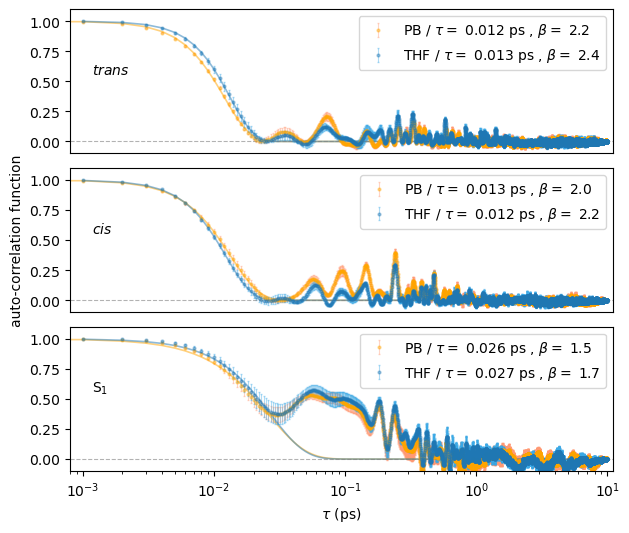

In [63]:
# Parameters
#------------
torsion = "d_cnnc"
isomers = ["trans", "cis", "s1"]

colors = {"THF": "tab:blue", "PB": "orange"}
ecolors = {"THF": "#3ba9e6", "PB": "#ff9973"}
fitcolors = {"THF": "tab:blue", "PB": "orange"}
#############

systems = ["Polybutadiene", "THF"]

fig, ax = plt.subplots(nrows=3, figsize=(7,6))
fig.subplots_adjust(hspace=0.1, wspace=0.2)
# fig.suptitle(
#     "Time-autocorrelation function -- means C-N=N-C",
#     fontweight="bold",
#     fontsize=12,
#     y=0.92,
#     x=0.5,
#     ha = "center"
# )


for i, iso in enumerate(isomers):
    ACORRALL = {}
    ms=1.0
    lw=1.0
    
    ax[i].text(
            0.04, 0.55,
            "{}".format(labels[iso]), transform=ax[i].transAxes,
            ha="left",
            rotation=0, fontsize=10
        )
    
    ACORRALL["PB"] = ACORRtotGLOB["POL"][iso]
    ACORRALL["THF"] = ACORRtotGLOB["THF"][iso]
        
    ####
    for d in ACORRALL:
        data = ACORRALL[d]["mean"].copy()
        tau = data["time"].values
        acorr = data[torsion].values
        
        std = ACORRALL[d]["std"][torsion].copy()
        ###
        info = ACORRALL[d]["info"].copy()
        prop = info[info["prop"] == torsion]
        t_c = prop["t_c"].values[0]
        beta = prop["beta"].values[0]
        
        lab = r"{} / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(d, t_c, beta)
        
        #if iso != "s1":
        #    pass
            
        #    # PLOTlines(ax[i], ACORRALL, torsion, xmin=0.0, plot_lines=True)
            
        #else:
        #    popt, pcov = curve_fit(
        #        stretched_exponetial2,
        #        tau,
        #        acorr,  # bounds=([0.0, 1.5], [0.15, 8.])
        #        bounds= ([0., 0.001, 1.0, 0.001, 1.0], [0.5, 0.01365004, 3.2, 0.3, 1.4])
        #   )
        #    # print(popt)
            
            
        #    lab = r"{} -- $A$={:.4f} / $\tau_1=${:.4f}ps / $\beta_1=${:.4f} / $\tau_2=${:.4f}ps / $\beta_2=${:.4}".format(d, *popt
        
        #if iso == "s1":
        #    ax[i].plot(
        #        tau, stretched_exponetial2(tau, *popt),
        #        color=fitcolors[d],
        #        lw=1.2, ls="--", alpha=0.8, label=lab
        #        )
        
        ax[i].errorbar(tau, acorr,
            yerr=std, capsize=.5,
            color=colors[d],
            ecolor=ecolors[d], elinewidth=0.8,
            label = lab, #f"{d}" + " data",
            ls="", marker=".", ms=4., alpha=0.4)
        
        ax[i].plot(
                tau, stretched_exponetial(tau, t_c, beta),
                color=fitcolors[d],
                lw=1.2, ls="-", alpha=0.5 #, label=lab
        )
        
        
            
            


    ax[i].set_xscale("log")
    ax[i].set_xlabel(r"${\tau}$ (ps)")
    ax[i].set_xlim(.8e-3, 1.1e1)
    ax[i].set_ylim(-0.1, 1.1)
    ax[i].axhline(y=0.0, color="gray", ls="--", lw=0.8, alpha=0.6)
    
    if i != 2:
        ax[i].get_xaxis().set_visible(False)
        
        
    ax[i].legend(fontsize=10, loc="upper right")
    
ax[1].set_ylabel("auto-correlation function")
# SaveFigACORR.saveFig(f"acorr_means_{torsion}.png")
# SaveFigPaper.saveFig(f"acorr_means_{torsion}.png")
# saveFig(f"acorr_{isomer}_{torsion}.png")
plt.show()

Auto-correlation function observed for dihedrals CNNC and compared for each isomer in PB and THF

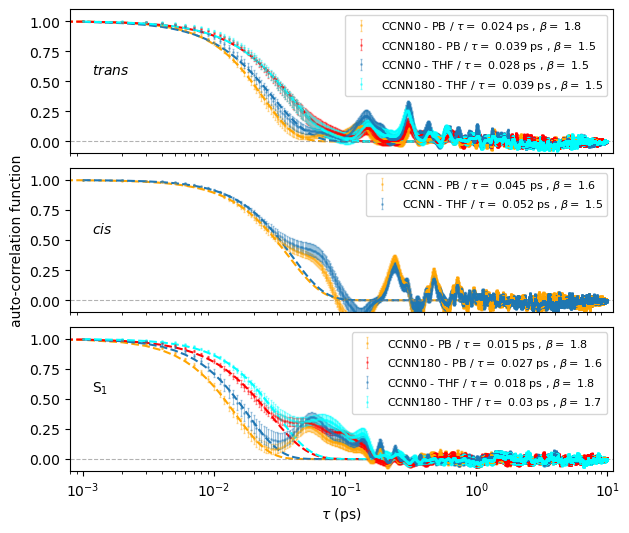

In [67]:
# Parameters
#------------
iso_torsions = {
    "trans": ["d_ccnn_1", "d_ccnn_2"],
    "cis": ["d_ccnn_1", "d_ccnn_2"],
    "s1": ["d_ccnn_1", "d_ccnn_2"]
}

colors = {"THF": "tab:blue", "PB": "tab:orange"}
ecolors = {"THF": "#3ba9e6", "PB": "#ff9973"}
fitcolors = {"THF": "#93f611", "PB": "#f61ce9"}
#############

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,6))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
# fig.suptitle(
#     "Time-autocorrelation function -- means C=C-N=N",
#     fontweight="bold",
#     fontsize=12,
#     y=0.92,
#     x=0.5,
#     ha = "center"
# )

for i, iso in enumerate(iso_torsions):
    ms=1.0
    lw=1.0
    torsions = iso_torsions[iso]
    acorrTHF = ACORRtotGLOB["THF"][iso]["mean"]
    infoTHF = ACORRtotGLOB["THF"][iso]["info"]
    stdATHF = ACORRtotGLOB["THF"][iso]["std"]

    acorrPOL = ACORRtotGLOB["POL"][iso]["mean"]
    infoPOL = ACORRtotGLOB["POL"][iso]["info"]
    stdAPOL = ACORRtotGLOB["POL"][iso]["std"]
    
    ax[i].text(
        0.04, 0.55,
        "{}".format(labels[iso]), transform=ax[i].transAxes,
        ha="left",
        rotation=0, fontsize=10
    )
    
    
    if iso != "cis":
        ###
        prop = infoPOL[infoPOL["prop"] == "d_ccnn_1"]
        t_c = prop["t_c"].values[0]
        beta = prop["beta"].values[0]
        lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
        ###
    
        ax[i].errorbar(acorrPOL["time"], acorrPOL["d_ccnn_1"],
                yerr=stdAPOL["d_ccnn_1"], capsize=.5,
                color="orange",
                ecolor="orange", elinewidth=0.8,
                label = "CCNN0 - PB" + lab,  # (0.0 deg)
                ls="", marker=".", ms=2., alpha=0.4)
        
        ###
        prop = infoPOL[infoPOL["prop"] == "d_ccnn_2"]
        t_c = prop["t_c"].values[0]
        beta = prop["beta"].values[0]
        lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
        ###

        ax[i].errorbar(acorrPOL["time"], acorrPOL["d_ccnn_2"],
                yerr=stdAPOL["d_ccnn_2"], capsize=.5,
                color="red",
                ecolor="red", elinewidth=0.8,
                label = "CCNN180 - PB" + lab, # (180.0 deg)
                ls="", marker=".", ms=2., alpha=0.4)

        ax[i].plot(acorrPOL["time"], stretched_exponetial(acorrPOL["time"], infoPOL.loc[1, "t_c"], infoPOL.loc[1, "beta"]), "--", color="orange")
        ax[i].plot(acorrPOL["time"], stretched_exponetial(acorrPOL["time"], infoPOL.loc[2, "t_c"], infoPOL.loc[2, "beta"]), "--", color="red")

        ######################
        
        ###
        prop = infoTHF[infoTHF["prop"] == "d_ccnn_1"]
        t_c = prop["t_c"].values[0]
        beta = prop["beta"].values[0]
        lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
        ###
        
        ax[i].errorbar(acorrTHF["time"], acorrTHF["d_ccnn_1"],
                yerr=stdATHF["d_ccnn_1"], capsize=.5,
                color="tab:blue",
                ecolor="tab:blue", elinewidth=0.8,
                label = "CCNN0 - THF" + lab,
                ls="", marker=".", ms=2., alpha=0.4)

        ###
        prop = infoTHF[infoTHF["prop"] == "d_ccnn_2"]
        t_c = prop["t_c"].values[0]
        beta = prop["beta"].values[0]
        lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
        ###
        
        ax[i].errorbar(acorrTHF["time"], acorrTHF["d_ccnn_2"],
                yerr=stdATHF["d_ccnn_2"], capsize=.5,
                color="cyan",
                ecolor="cyan", elinewidth=0.8,
                label = "CCNN180 - THF" + lab,
                ls="", marker=".", ms=2., alpha=0.4)

        ax[i].plot(acorrTHF["time"], stretched_exponetial(acorrTHF["time"], infoTHF.loc[1, "t_c"], infoTHF.loc[1, "beta"]), "--", color="tab:blue")
        ax[i].plot(acorrTHF["time"], stretched_exponetial(acorrTHF["time"], infoTHF.loc[2, "t_c"], infoTHF.loc[2, "beta"]), "--", color="cyan")
        
    else:
        acorrTHF["d_ccnn"] = acorrTHF["d_ccnn_1"] + acorrTHF["d_ccnn_2"]
        acorrTHF["d_ccnn"] /= 2
        
        acorrPOL["d_ccnn"] = acorrPOL["d_ccnn_1"] + acorrPOL["d_ccnn_2"]
        acorrPOL["d_ccnn"] /= 2
        
        stdATHF["d_ccnn"] = stdATHF["d_ccnn_1"] + stdATHF["d_ccnn_2"]
        stdATHF["d_ccnn"] /= 2
        
        stdAPOL["d_ccnn"] = stdAPOL["d_ccnn_1"] + stdAPOL["d_ccnn_2"]
        stdAPOL["d_ccnn"] /= 2
        
        
        ###
        prop_1 = infoPOL[infoPOL["prop"] == "d_ccnn_1"]
        prop_2 = infoPOL[infoPOL["prop"] == "d_ccnn_2"]
        prop = np.mean(
                np.array([
                    prop_1.loc[:, ["t_c", "beta"]].values,
                    prop_2.loc[:, ["t_c", "beta"]].values
                ]), axis=1)[0]
        t_c = prop[0]
        beta = prop[1]
        lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
        ###
        
        ax[i].errorbar(acorrPOL["time"], acorrPOL["d_ccnn"],
                yerr=stdAPOL["d_ccnn"], capsize=.5,
                color="orange",
                ecolor="orange", elinewidth=0.8,
                label = "CCNN - PB" + lab, # (103 deg)
                ls="", marker=".", ms=2., alpha=0.4)
    
        
        ###
        prop_1 = infoTHF[infoTHF["prop"] == "d_ccnn_1"]
        prop_2 = infoTHF[infoTHF["prop"] == "d_ccnn_2"]
        prop = np.mean(
                np.array([
                    prop_1.loc[:, ["t_c", "beta"]].values,
                    prop_2.loc[:, ["t_c", "beta"]].values
                ]), axis=1)[0]
        t_c = prop[0]
        beta = prop[1]
        lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
        ###
        ax[i].errorbar(acorrTHF["time"], acorrTHF["d_ccnn"],
                yerr=stdATHF["d_ccnn"], capsize=.5,
                color="tab:blue",
                ecolor="tab:blue", elinewidth=0.8,
                label = "CCNN - THF" + lab,
                ls="", marker=".", ms=2., alpha=0.4)
        
        a_acorr = acorrPOL["d_ccnn"][acorrPOL["time"] <= 0.03].values
        time = acorrPOL["time"][acorrPOL["time"] <= 0.03].values
        popt, pcov = curve_fit(
            stretched_exponetial,
            time,
            a_acorr,
            bounds=([0.0, 1.5], [0.15, 8.])
        )
        info = {"prop":a, "t_c": popt[0], "beta": popt[1], "isomer": iso, "system": system}
        ax[i].plot(acorrPOL["time"], stretched_exponetial(acorrPOL["time"], *popt), "--", color="orange")
                   
        a_acorr = acorrTHF["d_ccnn"][acorrTHF["time"] <= 0.03].values
        time = acorrTHF["time"][acorrTHF["time"] <= 0.03].values
        popt, pcov = curve_fit(
            stretched_exponetial,
            time,
            a_acorr,
            bounds=([0.0, 1.5], [0.15, 8.])
        )
        info = {"prop":a, "t_c": popt[0], "beta": popt[1], "isomer": iso, "system": system}
        ax[i].plot(acorrTHF["time"], stretched_exponetial(acorrTHF["time"], *popt), "--", color="tab:blue")       
    
    ax[i].set_xscale("log")
    # ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    
    ax[i].set_xlabel(r"${\tau}$ (ps)")
    ax[i].set_xlim(.8e-3, 1.1e1)
    ax[i].set_ylim(-0.1, 1.1)
    ax[i].axhline(y=0.0, color="gray", ls="--", lw=0.8, alpha=0.6)
    
    if i != 2:
        ax[i].set_xticks([])
        ax[i].set_xlabel("")
    # ax[i].get_xaxis().set_visible(False)
            
    ax[i].legend(fontsize=8, loc="upper right")
    
ax[1].set_ylabel("auto-correlation function")

# SaveFigPaper.saveFig(f"acorr_means_d_ccnn.png")
plt.show()

Auto-correlation function observed for dihedrals CCNN and compared for each isomer in PB and THF

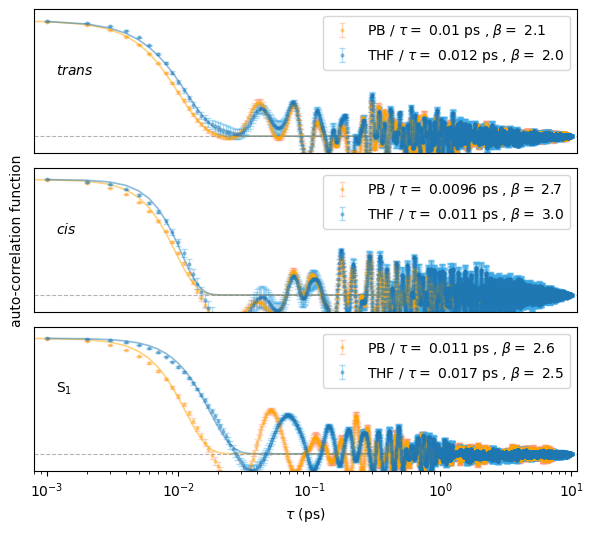

In [68]:
# Parameters
#------------
iso_torsions = {
    "trans": ["a_cnn"],
    "cis": ["a_cnn"],
    "s1": ["a_cnn"]
}
colors = {"THF": "tab:blue", "PB": "orange"}
ecolors = {"THF": "#3ba9e6", "PB": "#ff9973"}
fitcolors = {"THF": "tab:blue", "PB": "orange"}
#############

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,6))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
# fig.suptitle(
#     "Time-autocorrelation function -- means C-N=N",
#     fontweight="bold",
#     fontsize=12,
#     y=0.92,
#     x=0.5,
#     ha = "center"
# )

for i, iso in enumerate(iso_torsions):
    ms=1.0
    lw=1.0
    torsions = iso_torsions[iso]
    ACORRALL = {}
    ACORRALL["PB"] = ACORRtotGLOB["POL"][iso]
    ACORRALL["THF"] = ACORRtotGLOB["THF"][iso]
    
    ax[i].text(
        0.04, 0.55,
        "{}".format(labels[iso]), transform=ax[i].transAxes,
        ha="left",
        rotation=0, fontsize=10
    )
    
    for t in torsions:
        # ax[i, j].set_title(t, y=0.85)
        
        ####
        for d in ACORRALL:
            data = ACORRALL[d]["mean"].copy()
            tau = data["time"].values
            acorr = data[t].values
        
            std = ACORRALL[d]["std"][t].copy()
            ###
            info = ACORRALL[d]["info"].copy()
            prop = info[info["prop"] == t]
            t_c = prop["t_c"].values[0]
            beta = prop["beta"].values[0]
            
            lab = r"{} / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(d, t_c, beta)

            ax[i].errorbar(tau, acorr,
                yerr=std, capsize=2.5,
                color=colors[d],
                ecolor=ecolors[d], elinewidth=0.9,
                label = lab, #r"{}".format(d),
                ls="", marker=".", ms=4., alpha=0.4)
            ax[i].plot(
                tau, stretched_exponetial(tau, t_c, beta),
                color=fitcolors[d],
                lw=1.2, ls="-", alpha=0.5                # label=lab
            )
            
            # PLOTlines(ax[i, j], ACORRALL, t, xmin=0.0, plot_lines=True)
            
        ax[i].set_xscale("log")   
        #ax[i].set_yscale("log")
        ax[i].set_xlabel(r"${\tau}$ (ps)")
        ax[i].set_xlim(.8e-3, 1.1e1)
        ax[i].set_ylim(-0.15, 1.1)
        ax[i].axhline(y=0.0, color="gray", ls="--", lw=0.8, alpha=0.6)
        if j == 1:
            ax[i].set_yticks([])
        
        if i != 2:
            ax[i].get_xaxis().set_visible(False)
        
        ax[i].legend(fontsize=10, loc="upper right")
        
ax[1].set_ylabel("auto-correlation function")

#SaveFigACORR.saveFig(f"acorr_means_cnn.png")
# SaveFigPaper.saveFig(f"acorr_means_cnn.png")
# saveFig(f"acorr_{isomer}_{torsion}.png")
plt.show()

Auto-correlation function observed for angle CNN and compared for each isomer in PB and THF

In [109]:
dfall = []

###### D CNNC
xdata = []
ydata = []
solvent = []
for sol in ACORRtotGLOB:  
    for iso in ACORRtotGLOB[sol]:
        tab = ACORRtotGLOB[sol][iso]["info"].copy()
        tab.set_index("prop", inplace=True)
        xdata.append(iso)
        ydata.append(tab.loc["d_cnnc", "t_c"])
        solvent.append(sol)
        
df = pd.DataFrame({
        "t_c": ydata,
        "iso": xdata,
        "sol": solvent
})

dfall.append(df.copy())


###### D CCNN
xdata = []
ydata = []
solvent = []
torsion = []
colors = []
for sol in ACORRtotGLOB:
    for iso in ACORRtotGLOB[sol]:
        tab = ACORRtotGLOB[sol][iso]["info"].copy()
        tab.set_index("prop", inplace=True)
        if iso != "cis":
            for t in ["d_ccnn_1", "d_ccnn_2"]:
                xdata.append(iso)
                ydata.append(tab.loc[t, "t_c"])
                solvent.append(sol)
                torsion.append(t.replace("d_ccnn","CCNN").replace("_1","0").replace("_2","180"))
                if t == "d_ccnn_1" and sol == "POL":
                    colors.append("tab:orange")
                elif t == "d_ccnn_2" and sol == "POL":
                    colors.append("red")
                elif t == "d_ccnn_1" and sol == "THF":
                    colors.append("tab:blue")
                elif t == "d_ccnn_2" and sol == "THF":
                    colors.append("cyan")
                    
        else:
            data = ACORRtotGLOB[sol][iso]["mean"]
            data["d_ccnn"] = data["d_ccnn_1"] + data["d_ccnn_2"]
            data["d_ccnn"] /= 2
            
            a_acorr = data["d_ccnn"][data["time"] <= 0.03].values
            time = data["time"][data["time"] <= 0.03].values
            popt, pcov = curve_fit(
                stretched_exponetial,
                time,
                a_acorr,
                bounds=([0.0, 1.5], [0.15, 8.])
            )
            xdata.append(iso)
            ydata.append(popt[0])
            solvent.append(sol)
            torsion.append("CCNN")
            
            if sol == "POL":
                colors.append("tab:orange")
            else:
                colors.append("tab:blue")
            
        
df = pd.DataFrame({
        "t_c": ydata,
        "iso": xdata,
        "environment": solvent,
        "dihedral": torsion,
        "col": colors
})
dfall.append(df.copy())


###### D CNN
xdata = []
ydata = []
solvent = []
for sol in ACORRtotGLOB:  
    for iso in ACORRtotGLOB[sol]:
        tab = ACORRtotGLOB[sol][iso]["info"].copy()
        tab.set_index("prop", inplace=True)
        xdata.append(iso)
        ydata.append(tab.loc["a_cnn", "t_c"])
        solvent.append(sol)
        
df = pd.DataFrame({
        "t_c": ydata,
        "iso": xdata,
        "sol": solvent
})

dfall.append(df.copy())

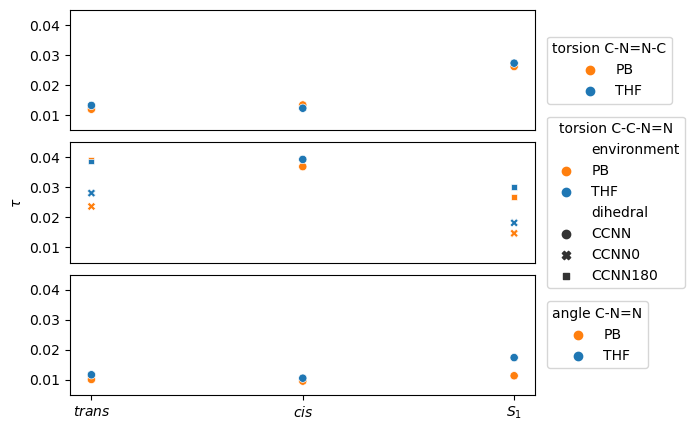

In [112]:
fig, ax = plt.subplots(nrows=3, figsize=(6,5))

fig.subplots_adjust(hspace=0.1)

for i, data in enumerate(dfall):
    data = data.copy()
    try:
        data["sol"] = data["sol"].apply(lambda x: x.replace("POL", "PB"))
    except KeyError:
        data["environment"] = data["environment"].apply(lambda x: x.replace("POL", "PB"))
        
    data["iso"] = data["iso"].apply(lambda x: x.replace("s1", "$S_{1}$"))
    data["iso"] = data["iso"].apply(lambda x: x.replace("trans", r"$trans$"))
    data["iso"] = data["iso"].apply(lambda x: x.replace("cis", r"$cis$"))
    if i == 0:
        sns.scatterplot(data=data, x="iso", y="t_c", hue="sol", ax=ax[i], palette=["tab:orange", "tab:blue"])
        ax[i].legend(title="torsion C-N=N-C", loc='center left', bbox_to_anchor=(1.01, .5))
        ax[i].set_ylabel("")
        
    elif i ==1:
        sns.scatterplot(data=data, x="iso", y="t_c", hue="environment", style="dihedral", ax=ax[i], palette=["tab:orange", "tab:blue"], style_order=["CCNN", "CCNN0", "CCNN180"])  # , markers=["x", "s", "o"]
        ax[i].legend(title="torsion C-C-N=N", loc='center left', bbox_to_anchor=(1.01, .50))
        ax[i].set_ylabel(r"$\tau$")
        
    elif i == 2:
        sns.scatterplot(data=data, x="iso", y="t_c", hue="sol", ax=ax[i], palette=["tab:orange", "tab:blue"])
        ax[i].legend(title="angle C-N=N", loc='center left', bbox_to_anchor=(1.01, .50))
        ax[i].set_ylabel("")
        ax[i].set_xlabel("")

        
    if i != 2:
        ax[i].get_xaxis().set_visible(False)
        
        
    ax[i].set_ylim(0.005, 0.045)

# saveFig("info_fits_time_correlations.png")
# SaveFigPaper.saveFig("info_fits_time_correlations.png")
plt.show()

Comparison of the characteristic times as a function of the photochrome system

### Mean square displacement

In [1]:
longCol = {"PB": "red", "THF":"darkblue"}

In [25]:
def get_log2_av(data):
    msd = data["msd"].values
    tau = data["time"].values
    
    log_av_msd = [msd[0]]
    log_av_tau = [tau[0]]
    
    for j in range(1, int(np.log2(len(msd)) + 1)):
        # print("j", j)
        sumpar = [i for i in range(2**(j-1) , 2**j)]
        # print("SUM", sumpar)
        # print("msd[SUM]", msd[sumpar])
        # print("sum[MSD]", sum(msd[sumpar]))
        # print((1/(2**j - 2**(j-1))) * sum(msd[sumpar]))
        log_av_msd.append((1/(2**j - 2**(j-1))) * sum(msd[sumpar]))
        log_av_tau.append((1/(2**j - 2**(j-1))) * sum(tau[sumpar]))
        # print("="*80)
    
    return pd.DataFrame({"logAv_msd":log_av_msd, "logAv_tau":log_av_tau})

def get_diff(ltime,lmsd):
    # Agregar el log
    alpha = np.diff(np.log(lmsd)) / np.diff(np.log(ltime))
    time = ltime.values[1:len(alpha) + 1]
    
    return pd.DataFrame({"tau": time, "alpha": alpha})

In [104]:
isomers = ["trans", "cis", "s1"]
systems = ["THF", "PB"]
replicas = ["0", "1", "2", "3", "4"]
MSDALL = {}
CHECK = []

for iso in isomers:
    MSDALL[iso] = {}
    for sol in systems:
        MSDALL[iso][sol] = {}
        for r in replicas:
            MSDALL[iso][sol][r] = {}
            if sol == "PB":
                File_short = "../exp.azob.stamp.5/{}/6_prod_{}/msd.csv".format(iso, r)
                File = "../exp.azob.stamp.3/{}/6_prod_{}/msd.csv".format(iso, r)
            elif sol == "THF":
                File_short = "../exp.azob.gmx/azob_{}.thf.densf/md{}_10ps/msd.csv".format(iso, r)
                File = "../exp.azob.gmx/azob_{}.thf.densf/md{}/msd.csv".format(iso, r)
            
            ##print("Files:")
            ##print(File_short)
            ##print(File)
            data_short = pd.DataFrame()
            data = pd.DataFrame()
            
            try:
                data_short = pd.read_csv(File_short)
                CHECK.append({
                    "isomer": iso,
                    "system": sol,
                    "replica": r,
                    "type": "short",
                    "Done": ""
                })
            except FileNotFoundError:
                print("#" * 40)
                print("\tError, file not founded:\n", File_short)
                CHECK.append({
                    "isomer": iso,
                    "system": sol,
                    "replica": r,
                    "type": "short",
                    "Done": "x"
                })
                
            try:
                data = pd.read_csv(File)
                CHECK.append({
                    "isomer": iso,
                    "system": sol,
                    "replica": r,
                    "type": "long",
                    "Done": ""
                })
            except FileNotFoundError:
                print("#" * 40)
                print("\tError, file not founded:\n", File)
                CHECK.append({
                    "isomer": iso,
                    "system": sol,
                    "replica": r,
                    "type": "long",
                    "Done": "x"
                })
                
            try:
                #data_short = data_short[data_short["time"] <= 1.]
                data_short.drop(data_short[data_short['time'] == 0.0].index, inplace = True)
                #data = data[data["time"] <= 1000.]
                data.drop(data[data['time'] == 0.0].index, inplace = True)
            except KeyError:
                continue

            MSDALL[iso][sol][r]["data"] = pd.concat([
                data_short[data_short["time"] <= 1.],
                data[data["time"] <= 1000.]
            ], ignore_index=True)
            short_log2 = get_log2_av(data_short)
            MSDALL[iso][sol][r]["logAv"] = pd.concat([short_log2[short_log2["logAv_tau"] <= 1.0], get_log2_av(data)], ignore_index=True)

print("#" * 40)
CHECK = pd.DataFrame(CHECK)

CHECK[CHECK["Done"] == "x"].style.format(subset=["Done"]).apply(isNotMSD, color="red")
     # .hide(subset=list(CHECK["Done"] == "x"))

########################################


In [105]:
colorsMSD = {
    "0": "#00ced1",
    "1": "#c1371b",
    "2": "#f4c430",
    "3": "#6b8e23",
    "4": "#efafef"
}

In [106]:
MSDMeans = {}

for iso in MSDALL:
    MSDMeans[iso] = {}
    for sol in MSDALL[iso]:
        df_concat = []
        for r in MSDALL[iso][sol]:
            df_concat.append(MSDALL[iso][sol][r]["data"])
            
        df_concat = pd.concat(tuple(df_concat))    
        by_row_index = df_concat.groupby(df_concat.index)
        df_means = by_row_index.mean()
        
        MSDMeans[iso][sol] = df_means.sort_values(by=["time"])

In [107]:
MSDMeansGlob = {}

for iso in MSDALL:
    MSDMeansGlob[iso] = {}
    for sol in MSDALL[iso]:
        df_concat = []
        df_log2Mean = []
        MSDMeansGlob[iso][sol] = {}
        for r in MSDALL[iso][sol]:
            df_concat.append(MSDALL[iso][sol][r]["data"])
            df_log2Mean.append(MSDALL[iso][sol][r]["logAv"])
            
        df_concat = pd.concat(tuple(df_concat))    
        by_row_index = df_concat.groupby(df_concat.index)
        df_means = by_row_index.mean()
        
        df_std = by_row_index.std()
        
        MSDMeansGlob[iso][sol]["mean"] = df_means ## df_means.sort_values(by=["time"])
        MSDMeansGlob[iso][sol]["std"] = df_std / np.sqrt(5) ## df_std.sort_values(by=["time"])
        
        dflogAv = get_log2_av(df_means)
        #########
        df_log2Mean = pd.concat(tuple(df_log2Mean))    
        by_row_index = df_log2Mean.groupby(df_log2Mean.index)
        df_log2Mean = by_row_index.mean()
        # print(df_log2Mean)

        MSDMeansGlob[iso][sol]["logAv"] = df_log2Mean
        MSDMeansGlob[iso][sol]["diff"] = get_diff(df_log2Mean["logAv_tau"], df_log2Mean["logAv_msd"]) ## get_diff(df_means["time"], df_means["msd"])

In [108]:
msd_trans = pd.read_csv("../exp.azob.stamp.3/trans/6_prod_0_long/msd.csv")
msd_trans.drop(msd_trans[msd_trans['time'] == 0.0].index, inplace = True)
msd_trans.drop(msd_trans[msd_trans['time'] > 8000.0].index, inplace = True)

msd_cis = pd.read_csv("../exp.azob.stamp.3/cis/6_prod_0_long/msd.csv")
msd_cis.drop(msd_cis[msd_cis['time'] == 0.0].index, inplace = True)
msd_cis.drop(msd_cis[msd_cis['time'] > 8000.0].index, inplace = True)

msd_s1 = pd.read_csv("../exp.azob.stamp.3/s1/6_prod_1/msd.csv")
msd_s1.drop(msd_s1[msd_s1['time'] == 0.0].index, inplace = True)
msd_s1.drop(msd_s1[msd_s1['time'] > 3000.0].index, inplace = True)

msd_trans_thf = pd.read_csv("../exp.azob.gmx/azob_trans.thf/md/msd.csv")
msd_trans_thf.drop(msd_trans_thf[msd_trans_thf['time'] == 0.0].index, inplace = True)
msd_trans_thf.drop(msd_trans_thf[msd_trans_thf['time'] > 4900.0].index, inplace = True)

msd_cis_thf = pd.read_csv("../exp.azob.gmx/azob_cis.thf/md/msd.csv")
msd_cis_thf.drop(msd_cis_thf[msd_cis_thf['time'] == 0.0].index, inplace = True)
msd_cis_thf.drop(msd_cis_thf[msd_cis_thf['time'] > 4900.0].index, inplace = True)

msd_s1_thf = pd.read_csv("../exp.azob.gmx/azob_s1.thf/md/msd.csv")
msd_s1_thf.drop(msd_s1_thf[msd_s1_thf['time'] == 0.0].index, inplace = True)
msd_s1_thf.drop(msd_s1_thf[msd_s1_thf['time'] > 4900.0].index, inplace = True)

In [109]:
MSDlong = {}
MSDlong["PB"] = {}
MSDlong["THF"] = {}

MSDlong["PB"]["trans"] = msd_trans
MSDlong["PB"]["cis"] = msd_cis
MSDlong["PB"]["s1"] = msd_s1

MSDlong["THF"]["trans"] = msd_trans_thf
MSDlong["THF"]["cis"] = msd_cis_thf
MSDlong["THF"]["s1"] = msd_s1_thf

In [110]:
MSDlongAv = {}

for sol in MSDlong:
    MSDlongAv[sol] = {}
    for iso in MSDlong[sol]:
        df = MSDlong[sol][iso].copy()
        dflogAv = get_log2_av(df)
        MSDlongAv[sol][iso] = dflogAv

In [111]:
MSDlongAlpha = {}

for sol in MSDlong:
    MSDlongAlpha[sol] = {}
    for iso in MSDlong[sol]:
        df = MSDlong[sol][iso].copy()
        dflogAv = get_log2_av(df)
        MSDlongAlpha[sol][iso] = get_diff(dflogAv["logAv_tau"], dflogAv["logAv_msd"])

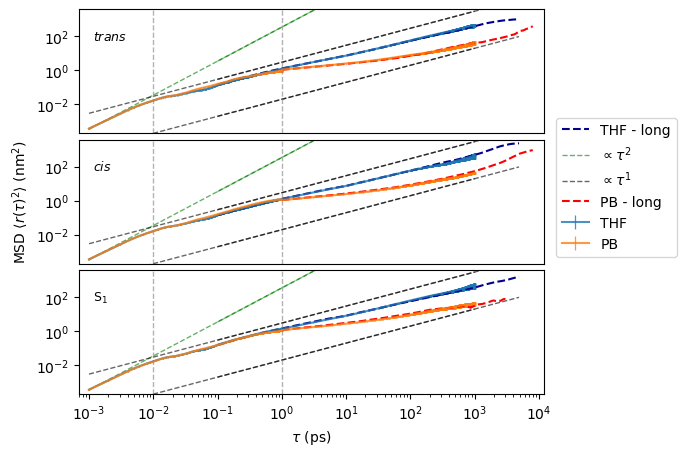

In [122]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,5))

fig.subplots_adjust(hspace=0.05, wspace=0.2)
# fig.suptitle(
#     "Mean square displacement",
#     fontweight="bold",
#     fontsize=10,
#     y=0.91,
#     x=0.5,
#     ha = "center"
# )

longCol = {"PB": "red", "THF":"darkblue"}

for i, iso in enumerate(MSDMeansGlob):
    for sol in MSDMeansGlob[iso]:
        msd = MSDMeansGlob[iso][sol]["mean"]
        std = MSDMeansGlob[iso][sol]["std"]
        # print(msd)
        #ax[i].plot(
        #   msd["time"], msd["msd"],
        #    "-", lw=2., ms=1., label=sol, color=colors[sol])
        
        ax[i].errorbar(msd["time"], msd["msd"],
            yerr=std["msd"], capsize=0.0,
            color=colors[sol],
            ecolor=colors[sol], elinewidth=0.9,
            label = sol,
            ls="-", marker="", ms=2., alpha=0.8)
        
        try:
            msd_long = MSDlong[sol][iso].copy()
            ax[i].plot(msd_long["time"], msd_long["msd"], "--", color=longCol[sol], label=f"{sol} - long")
        except KeyError:
            pass
                
        # ax[i].set_title("{} - {}".format(labels[iso], sol), fontsize=9)
        
        if sol == "THF":
            ax[i].plot(msd["time"], 350*msd["time"]**2, "--", lw=1., color="green", label=r"$\propto\tau^2$", alpha=0.6)
            ax[i].plot(msd["time"], 3*msd["time"], "--", lw=1., color="k", label=r"$\propto\tau^1$", alpha=0.6)
            ax[i].plot(msd["time"], 0.02*msd["time"], "--", lw=1., color="k", alpha=0.6)
            
            ax[i].plot(msd_long["time"], 350*msd_long["time"]**2, "--", lw=1., color="green", alpha=0.6)
            ax[i].plot(msd_long["time"], 3*msd_long["time"], "--", lw=1., color="k", alpha=0.6)
            ax[i].plot(msd_long["time"], 0.02*msd_long["time"], "--", lw=1., color="k", alpha=0.6)
    
    ax[i].text(
            0.03, 0.75,
            "{}".format(labels[iso]), transform=ax[i].transAxes,
            ha="left",
            rotation=0, fontsize=9
        )
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    #ax[i].set_xlim(0.7e-3, 3.0e3)
    ax[i].set_xlim(0.7e-3, 1.2e4)
    ax[i].set_ylim(2.0e-4, 4.0e3)
    ax[i].axvline(x=1e-2, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].axvline(x=1e0, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].set_xlabel(r"$\tau$ (ps)")
    
    
    if i != 2:
        # ax[i, j].set_yticks([])
        ax[i].get_xaxis().set_visible(False)

ax[1].set_ylabel(r"MSD $\langle{r(\tau)^2}\rangle$ (nm$^2$)")
ax[1].legend(fontsize=10, loc="lower right", bbox_to_anchor=(1.3, 0.0))
# plt.legend()          
# saveFig("MSD_comparison.png")
# SaveFigPaper.saveFig("MSD_comparison_allatoms.png")

plt.show()

**Nota**

Agregar en la leyenda la curva larga

Cambiar el orden que se muestra en la leyenda

MSD all atoms

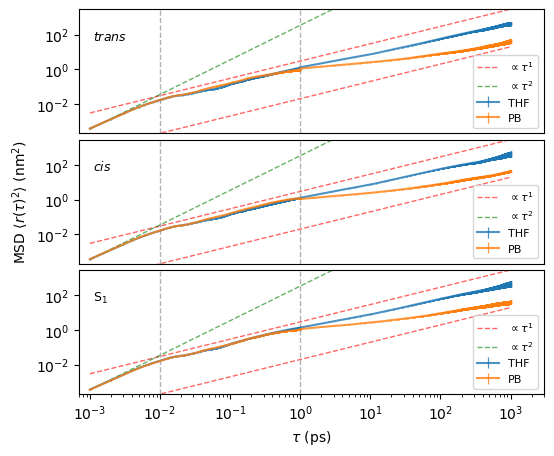

In [188]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,5))

fig.subplots_adjust(hspace=0.05, wspace=0.2)
# fig.suptitle(
#     "Mean square displacement",
#     fontweight="bold",
#     fontsize=10,
#     y=0.91,
#     x=0.5,
#     ha = "center"
# )

for i, iso in enumerate(MSDMeansGlob):
    for sol in MSDMeansGlob[iso]:
        msd = MSDMeansGlob[iso][sol]["mean"]
        std = MSDMeansGlob[iso][sol]["std"]
        # print(msd)
        #ax[i].plot(
        #   msd["time"], msd["msd"],
        #    "-", lw=2., ms=1., label=sol, color=colors[sol])
        
        ax[i].errorbar(msd["time"], msd["msd"],
            yerr=std["msd"], capsize=0.0, #2.5,
            color=colors[sol],
            ecolor=colors[sol], elinewidth=0.9,
            label = sol,
            ls="-", marker="", ms=2., alpha=0.8)
                
        # ax[i].set_title("{} - {}".format(labels[iso], sol), fontsize=9)
        
        if sol == "THF":
            ax[i].plot(msd["time"], 3*msd["time"], "--", lw=1., color="red", label=r"$\propto\tau^1$", alpha=0.6)
            ax[i].plot(msd["time"], 350*msd["time"]**2, "--", lw=1., color="green", label=r"$\propto\tau^2$", alpha=0.6)
            ax[i].plot(msd["time"], 0.02*msd["time"], "--", lw=1., color="red", alpha=0.6)
    
    ax[i].text(
            0.03, 0.75,
            "{}".format(labels[iso]), transform=ax[i].transAxes,
            ha="left",
            rotation=0, fontsize=9
        )
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].set_xlim(0.7e-3, 3.0e3)
    ax[i].set_ylim(2.0e-4, 3.0e3)
    # ax[i].set_ylim(2.0e-4, 2)
    ax[i].axvline(x=1e-2, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].axvline(x=1e0, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].set_xlabel(r"$\tau$ (ps)")
    ax[i].legend(fontsize=8, loc="lower right")
    
    if i != 2:
        # ax[i, j].set_yticks([])
        ax[i].get_xaxis().set_visible(False)

ax[1].set_ylabel(r"MSD $\langle{r(\tau)^2}\rangle$ (nm$^2$)")
            
# saveFig("MSD_comparison.png")
# SaveFigPaper.saveFig("MSD_comparison_allatoms.png")

plt.show()

MSD all atoms

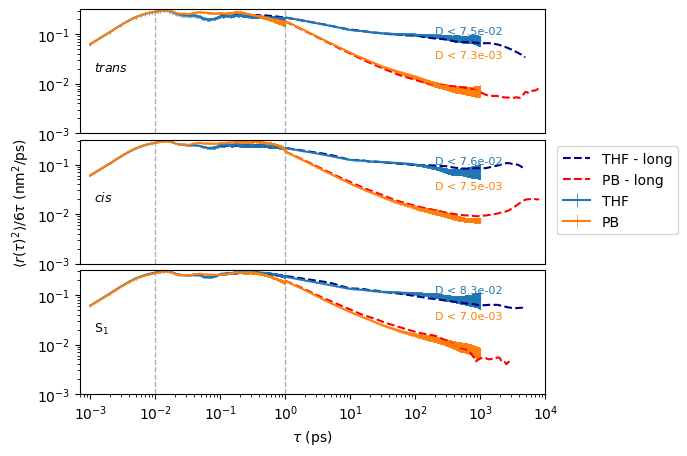

In [131]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,5))

fig.subplots_adjust(hspace=0.05, wspace=0.2)
# fig.suptitle(
#     "Mean square displacement",
#     fontweight="bold",
#     fontsize=10,
#     y=0.91,
#     x=0.5,
#     ha = "center"
# )

for i, iso in enumerate(MSDMeansGlob):
    for sol in MSDMeansGlob[iso]:
        msd = MSDMeansGlob[iso][sol]["mean"]
        std = MSDMeansGlob[iso][sol]["std"]
        # print(msd)
        #ax[i].plot(
        #   msd["time"], msd["msd"],
        #    "-", lw=2., ms=1., label=sol, color=colors[sol])
        
        # ax[i].errorbar(msd["time"], msd["msd"],
        #     yerr=std["msd"], capsize=0.0, #2.5,
        #     color=colors[sol],
        #     ecolor=colors[sol], elinewidth=0.9,
        #     label = sol,
        #     ls="-", marker="", ms=2., alpha=0.8)
        
        ax[i].errorbar(
            msd["time"], msd["msd"]/(6 * msd["time"]),
            color=colors[sol], label = sol, elinewidth=0.5,
            yerr=std["msd"]/(6 * msd["time"]), capsize=0.0, #2.5,
        )
        
        try:
            msd_long = MSDlong[sol][iso].copy()
            ax[i].plot(msd_long["time"],  msd_long["msd"]/(6 * msd_long["time"]), "--", color=longCol[sol], label=f"{sol} - long")
        except KeyError:
            pass
        
        # print(sol, iso, "\n", msd.tail(10)["time"], msd.tail(10)["msd"]/(6 * msd.tail(10)["time"]))
        msdDcoef = msd.tail(10)["msd"]/(6 * msd.tail(10)["time"])
        # print(sol, iso, "\n", msdDcoef.mean())
        ax[i].text(
            200, msdDcoef.mean() + 0.025,
            "D < %.1e" % msdDcoef.mean(),
            ha="left",
            rotation=0, fontsize=8, color=colors[sol]
        )
                
        # ax[i].set_title("{} - {}".format(labels[iso], sol), fontsize=9)
        
        # if sol == "THF":
        #     ax[i].plot(msd["time"], 3*msd["time"], "--", lw=1., color="red", label=r"$\propto\tau^1$", alpha=0.6)
        #     ax[i].plot(msd["time"], 350*msd["time"]**2, "--", lw=1., color="green", label=r"$\propto\tau^2$", alpha=0.6)
        #     ax[i].plot(msd["time"], 0.02*msd["time"], "--", lw=1., color="red", alpha=0.6)
    
    ax[i].text(
            0.03, 0.5,
            "{}".format(labels[iso]), transform=ax[i].transAxes,
            ha="left",
            rotation=0, fontsize=9
        )
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].set_xlim(0.7e-3, 10.0e3)
    ax[i].set_ylim(0.001, 0.32)
    ax[i].axvline(x=1e-2, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].axvline(x=1e0, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].set_xlabel(r"$\tau$ (ps)")
    
    
    
    
    if i != 2:
        # ax[i, j].set_yticks([])
        ax[i].get_xaxis().set_visible(False)

ax[1].set_ylabel(r"$\langle{r(\tau)^2}\rangle/6\tau$ (nm$^2$/ps)")
ax[1].legend(bbox_to_anchor=(1.3, 1.), fontsize=10)
            
# saveFig("MSD_comparison.png")
# SaveFigPaper.saveFig("MSD_comparison_allatoms.png")

plt.show()

**NOTA**

Cambiar la distancia del text D

Orden de la leyenda

Mismo tamano de letra para todos los textos

Agregar S1 PB long

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,5))

fig.subplots_adjust(hspace=0.05, wspace=0.2)
# fig.suptitle(
#     "Mean square displacement",
#     fontweight="bold",
#     fontsize=10,
#     y=0.91,
#     x=0.5,
#     ha = "center"
# )

for i, iso in enumerate(MSDMeansGlob):
    for sol in MSDMeansGlob[iso]:
        msd = MSDMeansGlob[iso][sol]["mean"]
        std = MSDMeansGlob[iso][sol]["std"]
        # print(msd)
        #ax[i].plot(
        #   msd["time"], msd["msd"],
        #    "-", lw=2., ms=1., label=sol, color=colors[sol])
        
        # ax[i].errorbar(msd["time"], msd["msd"],
        #     yerr=std["msd"], capsize=0.0, #2.5,
        #     color=colors[sol],
        #     ecolor=colors[sol], elinewidth=0.9,
        #     label = sol,
        #     ls="-", marker="", ms=2., alpha=0.8)
        
        ax[i].errorbar(
            msd["time"], msd["msd"]/(6 * msd["time"]),
            color=colors[sol], label = sol, elinewidth=0.5,
            yerr=std["msd"]/(6 * msd["time"]), capsize=0.0, #2.5,
        )
        
        # print(sol, iso, "\n", msd.tail(10)["time"], msd.tail(10)["msd"]/(6 * msd.tail(10)["time"]))
        msdDcoef = msd.tail(10)["msd"]/(6 * msd.tail(10)["time"])
        print(sol, iso, "\n", msdDcoef.mean())
        ax[i].text(
            200, msdDcoef.mean() + 0.025,
            "D < %.1e" % msdDcoef.mean(),
            ha="left",
            rotation=0, fontsize=8, color=colors[sol]
        )
                
        # ax[i].set_title("{} - {}".format(labels[iso], sol), fontsize=9)
        
        # if sol == "THF":
        #     ax[i].plot(msd["time"], 3*msd["time"], "--", lw=1., color="red", label=r"$\propto\tau^1$", alpha=0.6)
        #     ax[i].plot(msd["time"], 350*msd["time"]**2, "--", lw=1., color="green", label=r"$\propto\tau^2$", alpha=0.6)
        #     ax[i].plot(msd["time"], 0.02*msd["time"], "--", lw=1., color="red", alpha=0.6)
    
    ax[i].text(
            0.03, 0.75,
            "{}".format(labels[iso]), transform=ax[i].transAxes,
            ha="left",
            rotation=0, fontsize=9
        )
    ax[i].set_xscale("log")
    # ax[i].set_yscale("log")
    ax[i].set_xlim(0.7e-3, 3.0e3)
    ax[i].set_ylim(0, 0.32)
    ax[i].axvline(x=1e-2, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].axvline(x=1e0, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].set_xlabel(r"$\tau$ (ps)")
    ax[i].legend(fontsize=8, loc="upper right")
    
    
    
    if i != 2:
        # ax[i, j].set_yticks([])
        ax[i].get_xaxis().set_visible(False)

ax[1].set_ylabel(r"$\langle{r(\tau)^2}\rangle/6\tau$ (nm$^2$/ps)")
            
# saveFig("MSD_comparison.png")
# SaveFigPaper.saveFig("MSD_comparison_allatoms.png")

plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,5))

fig.subplots_adjust(hspace=0.05, wspace=0.2)
# fig.suptitle(
#     "Mean square displacement",
#     fontweight="bold",
#     fontsize=10,
#     y=0.91,
#     x=0.5,
#     ha = "center"
# )

markersStyle = {
    "THF": {"m": ".", "ms": 4.0},
    "PB": {"m": "x", "ms": 3.0}
}

for i, iso in enumerate(MSDMeansGlob):
    for sol in MSDMeansGlob[iso]:
        msd = MSDMeansGlob[iso][sol]["logAv"]
        msd["time"] = msd["logAv_tau"]
        
        ax[i].plot(
            msd["logAv_tau"], msd["logAv_msd"],
            color=colors[sol],
            label = sol,
            ls="",
            marker=markersStyle[sol]["m"],
            ms=5.,
            alpha=0.8)
        
        if sol == "THF":
            msdTHF = msd.copy()
                
        # ax[i].set_title("{} - {}".format(labels[iso], sol), fontsize=9)
        
    ax[i].plot(msdTHF["time"], 350*msdTHF["time"]**2, "--", lw=1., color="green", label=r"$\propto \tau^2$", alpha=0.5)
    ax[i].plot(msdTHF["time"], 3*msdTHF["time"], "--", lw=1., color="red", label=r"$\propto \tau^1$", alpha=0.5)
    ax[i].plot(msdTHF["time"], 0.02*msdTHF["time"], "--", lw=1., color="red", alpha=0.5)
    
    ax[i].text(
            0.03, 0.75,
            "{}".format(labels[iso]), transform=ax[i].transAxes,
            ha="left",
            rotation=0, fontsize=9
        )
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].set_xlim(0.7e-3, 3.0e3)
    ax[i].set_ylim(2.0e-4, 3.0e3)
    ax[i].axvline(x=1e-2, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].axvline(x=1e0, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].set_xlabel(r"$\tau$ (ps)")
    ax[i].legend(fontsize=8, loc="lower right")
    
    if i != 2:
        # ax[i, j].set_yticks([])
        ax[i].get_xaxis().set_visible(False)

ax[1].set_ylabel(r"MSD $\langle{r(\tau)^2}\rangle$ (nm$^2$)")
            
# saveFig("MSD_comparison.png")
# SaveFigPaper.saveFig("MSD_comparison_allatoms.png")

plt.show()

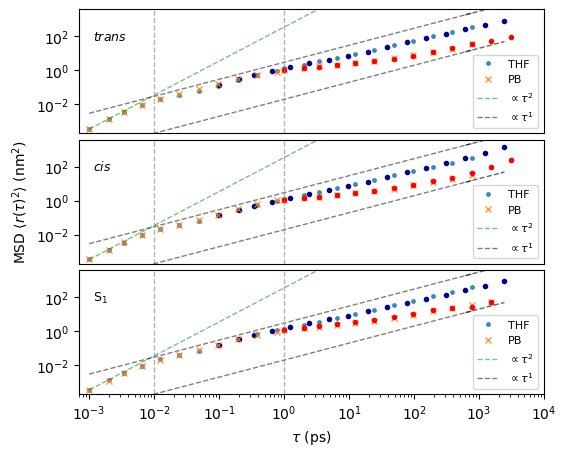

In [197]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,5))

fig.subplots_adjust(hspace=0.05, wspace=0.2)
# fig.suptitle(
#     "Mean square displacement",
#     fontweight="bold",
#     fontsize=10,
#     y=0.91,
#     x=0.5,
#     ha = "center"
# )

markersStyle = {
    "THF": {"m": ".", "ms": 4.0},
    "PB": {"m": "x", "ms": 3.0}
}

for i, iso in enumerate(MSDMeansGlob):
    for sol in MSDMeansGlob[iso]:
        msd = MSDMeansGlob[iso][sol]["logAv"]
        msd["time"] = msd["logAv_tau"]
        
        ax[i].plot(
            msd["logAv_tau"], msd["logAv_msd"],
            color=colors[sol],
            label = sol,
            ls="",
            marker=markersStyle[sol]["m"],
            ms=5.,
            alpha=0.8)
        
        msd_long = MSDlongAv[sol][iso].copy()
        ax[i].plot(msd_long["logAv_tau"],  msd_long["logAv_msd"], ".", color=longCol[sol])
        
        # print(iso, sol, "\n", msd_long.tail())
        
        if sol == "THF":
            msdTHF = msd.copy()
            msdTHF_long = msd_long.copy()
                
        # ax[i].set_title("{} - {}".format(labels[iso], sol), fontsize=9)
        
    ax[i].plot(msdTHF["time"], 350*msdTHF["time"]**2, "--", lw=1., color="green", label=r"$\propto \tau^2$", alpha=0.5)
    ax[i].plot(msdTHF["time"], 3*msdTHF["time"], "--", lw=1., color="k", label=r"$\propto \tau^1$", alpha=0.5)
    ax[i].plot(msdTHF["time"], 0.02*msdTHF["time"], "--", lw=1., color="k", alpha=0.5)
    
    msdTHF_long = msdTHF_long[msdTHF_long["logAv_tau"] >= msdTHF["time"].max() - 300]
    ax[i].plot(msdTHF_long["logAv_tau"], 350*msdTHF_long["logAv_tau"]**2, "--", lw=1., color="green", alpha=0.6)
    ax[i].plot(msdTHF_long["logAv_tau"], 3*msdTHF_long["logAv_tau"], "--", lw=1., color="k", alpha=0.6)
    ax[i].plot(msdTHF_long["logAv_tau"], 0.02*msdTHF_long["logAv_tau"], "--", lw=1., color="k", alpha=0.6)
    
    ax[i].text(
            0.03, 0.75,
            "{}".format(labels[iso]), transform=ax[i].transAxes,
            ha="left",
            rotation=0, fontsize=9
        )
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].set_xlim(0.7e-3, 10.0e3)
    ax[i].set_ylim(2.0e-4, 4.0e3)
    ax[i].axvline(x=1e-2, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].axvline(x=1e0, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].set_xlabel(r"$\tau$ (ps)")
    ax[i].legend(fontsize=8, loc="lower right")
    
    if i != 2:
        # ax[i, j].set_yticks([])
        ax[i].get_xaxis().set_visible(False)

ax[1].set_ylabel(r"MSD $\langle{r(\tau)^2}\rangle$ (nm$^2$)")
            
# saveFig("MSD_comparison.png")
# SaveFigPaper.saveFig("MSD_comparison_allatoms.png")

plt.show()

**NOTA**

Mismo tratamiento anterior


SI

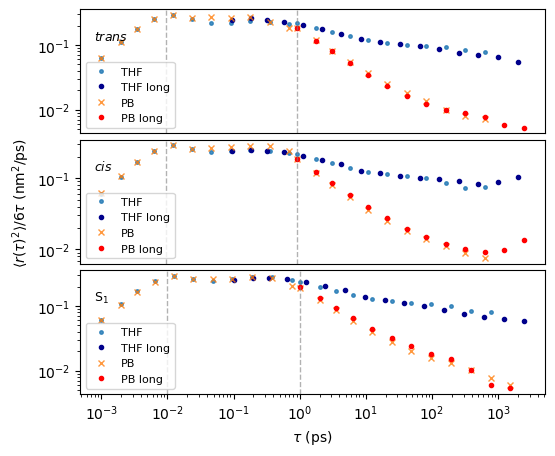

In [198]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,5))

fig.subplots_adjust(hspace=0.05, wspace=0.2)
# fig.suptitle(
#     "Mean square displacement",
#     fontweight="bold",
#     fontsize=10,
#     y=0.91,
#     x=0.5,
#     ha = "center"
# )

markersStyle = {
    "THF": {"m": ".", "ms": 4.0},
    "PB": {"m": "x", "ms": 3.0}
}

for i, iso in enumerate(MSDMeansGlob):
    for sol in MSDMeansGlob[iso]:
        msd = MSDMeansGlob[iso][sol]["logAv"]
        msd["time"] = msd["logAv_tau"]
        
        ax[i].plot(
            msd["logAv_tau"], msd["logAv_msd"]/(6*msd["logAv_tau"]),
            color=colors[sol],
            label = sol,
            ls="",
            marker=markersStyle[sol]["m"],
            ms=5.,
            alpha=0.8)
        
        msd_long = MSDlongAv[sol][iso].copy()
        ax[i].plot(msd_long["logAv_tau"],  msd_long["logAv_msd"]/(6*msd_long["logAv_tau"]), ".", color=longCol[sol], label=sol + " long")
        
        # print(iso, sol, "\n", msd_long.tail())
        
        if sol == "THF":
            msdTHF = msd.copy()
            msdTHF_long = msd_long.copy()
                
        # ax[i].set_title("{} - {}".format(labels[iso], sol), fontsize=9)
        
    
    ax[i].text(
            0.03, 0.75,
            "{}".format(labels[iso]), transform=ax[i].transAxes,
            ha="left",
            rotation=0, fontsize=9
        )
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    #ax[i].set_xlim(0.7e-3, 10.0e3)
    #ax[i].set_ylim(2.0e-4, 4.0e3)
    ax[i].axvline(x=1e-2, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].axvline(x=1e0, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].set_xlabel(r"$\tau$ (ps)")
    ax[i].legend(fontsize=8, loc="lower left")
    
    if i != 2:
        # ax[i, j].set_yticks([])
        ax[i].get_xaxis().set_visible(False)

ax[1].set_ylabel(r"$\langle{r(\tau)^2}\rangle/6\tau$ (nm$^2$/ps)")
            
# saveFig("MSD_comparison.png")
# SaveFigPaper.saveFig("MSD_comparison_allatoms.png")

plt.show()

**NOTA**

Mismo tratamiento anterior

Adicional agregar el resultado final S1 PB long

No agregar

SI, this figure

MSD allatoms using log average

**free difusion or diffusive regime** : 

$$ \langle{r(\tau)^2}\rangle \propto \tau^1$$


**ballistic regime**, *process is superdiffusive* : 

$$ \langle{r(\tau)^2}\rangle \propto \tau^2$$


**restricted diffusion or subdiffusion**:
$$ \langle{r(\tau)^2}\rangle \propto \tau^{<1}$$

In [ ]:
ecolors = {"THF": "#3ba9e6", "PB": "#ff9973"}

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,5))

fig.subplots_adjust(hspace=0.05, wspace=0.2)
# fig.suptitle(
#     "Mean square displacement",
#     fontweight="bold",
#     fontsize=10,
#     y=0.91,
#     x=0.5,
#     ha = "center"
# )

for i, iso in enumerate(MSDMeansGlob):
    for sol in MSDMeansGlob[iso]:
        msd = MSDMeansGlob[iso][sol]["mean"]
        std = MSDMeansGlob[iso][sol]["std"]
        alpha = MSDMeansGlob[iso][sol]["diff"]
        # print(alpha.iloc[-1, :])
        # print(msd)
        ax[i].plot(
           alpha["tau"], alpha["alpha"],
            ".", lw=2., ms=6., label=sol, color=colors[sol])
        #ax[i].errorbar(msd["time"], msd["msd"] / (6*msd["time"]),
        #    yerr=std["msd"] / (6*msd["time"]), capsize=2.5,
        #    color=colors[sol],
        #    ecolor=ecolors[sol], elinewidth=0.9,
        #    label = sol,
        #    ls="", marker=".", ms=2., alpha=0.4)
        
        #coeffdiff = np.mean(msd[msd["time"] >= 5e2]["msd"] / (6 * msd[msd["time"] >= 5e2]["time"]))
        #lastbarError = std.iloc[-1, 1] / (6*msd.iloc[-1, 0])
        #print("{}  {}  - {:.4} +- {:.4}".format(sol, iso, coeffdiff, lastbarError))
        #ax[i].axhline(y=coeffdiff, lw=1.0, ls="--", color=colors[sol], alpha=0.6)
                
        # ax[i].set_title("{} - {}".format(labels[iso], sol), fontsize=9)
        
        # if sol == "THF":
        #     ax[i].plot(msd["time"], 350*msd["time"]**2, "--", lw=1., color="green", label=r"$\tau^2$", alpha=0.6)
        #     ax[i].plot(msd["time"], 3*msd["time"], "--", lw=1., color="red", label=r"$\tau^1$", alpha=0.6)
        #     ax[i].plot(msd["time"], 0.02*msd["time"], "--", lw=1., color="red", alpha=0.6)
    
    ax[i].axhline(y=1., lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].text(
            0.03, 0.75,
            "{}".format(labels[iso]), transform=ax[i].transAxes,
            ha="left",
            rotation=0, fontsize=9
        )
    ax[i].set_xscale("log")
    # ax[i].set_yscale("log")
    ax[i].set_xlim(0.7e-3, 3.0e3)
    ax[i].set_ylim(0.0, 1.9)
    ax[i].axvline(x=1e-2, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].axvline(x=1e0, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].set_xlabel(r"$\tau$ (ps)")
    
    ax[i].legend(fontsize=8, loc="upper right")
    
    ax[i].axvline(x=5e2, lw=1.0, ls="--", color="gray", alpha=0.6) # hacer el promedio >=
    
    if i != 2:
        # ax[i, j].set_yticks([])
        ax[i].get_xaxis().set_visible(False)

ax[1].set_ylabel(r"$\alpha$")
# saveFig("MSD_comparison.png")

# SaveFigPaper.saveFig("MSD_alpha_comparison_allatoms.png")
plt.show()

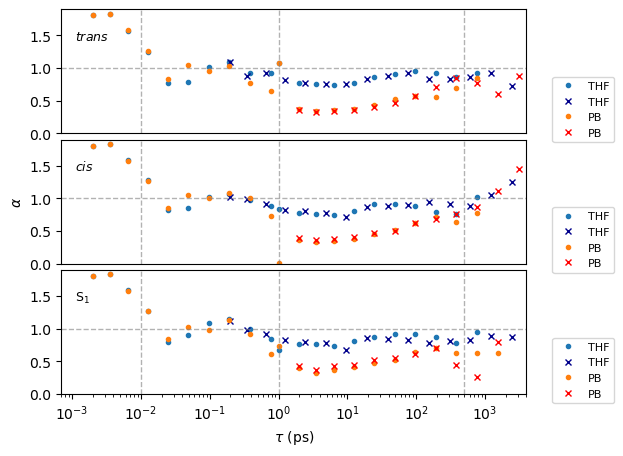

In [199]:
ecolors = {"THF": "#3ba9e6", "PB": "#ff9973"}

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,5))

fig.subplots_adjust(hspace=0.05, wspace=0.2)
# fig.suptitle(
#     "Mean square displacement",
#     fontweight="bold",
#     fontsize=10,
#     y=0.91,
#     x=0.5,
#     ha = "center"
# )

for i, iso in enumerate(MSDMeansGlob):
    for sol in MSDMeansGlob[iso]:
        msd = MSDMeansGlob[iso][sol]["mean"]
        std = MSDMeansGlob[iso][sol]["std"]
        alpha = MSDMeansGlob[iso][sol]["diff"]
        
        alpha_long = MSDlongAlpha[sol][iso]
        # print(alpha.iloc[-1, :])
        # print(msd)
        ax[i].plot(
           alpha["tau"], alpha["alpha"],
            ".", lw=2., ms=6., label=sol, color=colors[sol])
        
        ax[i].plot(
           alpha_long["tau"], alpha_long["alpha"],
            "x", lw=2., ms=4., label=sol, color=longCol[sol])
        #ax[i].errorbar(msd["time"], msd["msd"] / (6*msd["time"]),
        #    yerr=std["msd"] / (6*msd["time"]), capsize=2.5,
        #    color=colors[sol],
        #    ecolor=ecolors[sol], elinewidth=0.9,
        #    label = sol,
        #    ls="", marker=".", ms=2., alpha=0.4)
        
        #coeffdiff = np.mean(msd[msd["time"] >= 5e2]["msd"] / (6 * msd[msd["time"] >= 5e2]["time"]))
        #lastbarError = std.iloc[-1, 1] / (6*msd.iloc[-1, 0])
        #print("{}  {}  - {:.4} +- {:.4}".format(sol, iso, coeffdiff, lastbarError))
        #ax[i].axhline(y=coeffdiff, lw=1.0, ls="--", color=colors[sol], alpha=0.6)
                
        # ax[i].set_title("{} - {}".format(labels[iso], sol), fontsize=9)
        
        # if sol == "THF":
        #     ax[i].plot(msd["time"], 350*msd["time"]**2, "--", lw=1., color="green", label=r"$\tau^2$", alpha=0.6)
        #     ax[i].plot(msd["time"], 3*msd["time"], "--", lw=1., color="red", label=r"$\tau^1$", alpha=0.6)
        #     ax[i].plot(msd["time"], 0.02*msd["time"], "--", lw=1., color="red", alpha=0.6)
    
    ax[i].axhline(y=1., lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].text(
            0.03, 0.75,
            "{}".format(labels[iso]), transform=ax[i].transAxes,
            ha="left",
            rotation=0, fontsize=9
        )
    ax[i].set_xscale("log")
    # ax[i].set_yscale("log")
    ax[i].set_xlim(0.7e-3, 4.0e3)
    ax[i].set_ylim(0.0, 1.9)
    ax[i].axvline(x=1e-2, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].axvline(x=1e0, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].set_xlabel(r"$\tau$ (ps)")
    
    ax[i].legend(bbox_to_anchor=(1.2, 0.5),fontsize=8, loc="upper right")
    
    ax[i].axvline(x=5e2, lw=1.0, ls="--", color="gray", alpha=0.6) # hacer el promedio >=
    
    if i != 2:
        # ax[i, j].set_yticks([])
        ax[i].get_xaxis().set_visible(False)

ax[1].set_ylabel(r"$\alpha$")
# saveFig("MSD_comparison.png")

# SaveFigPaper.saveFig("MSD_alpha_comparison_allatoms.png")
plt.show()

**NOTA**

Mismo tratamiento

In [132]:
isomers = ["trans", "cis", "s1"]
systems = ["THF", "PB"]
replicas = ["0", "1", "2", "3", "4"]
MSDALLcm = {}
CHECK = []

for iso in isomers:
    MSDALLcm[iso] = {}
    for sol in systems:
        MSDALLcm[iso][sol] = {}
        for r in replicas:
            if sol == "PB":
                File_short = "../exp.azob.stamp.5/{}/6_prod_{}/msd_cm.csv".format(iso, r)
                File = "../exp.azob.stamp.3/{}/6_prod_{}/msd_cm.csv".format(iso, r)
            elif sol == "THF":
                File_short = "../exp.azob.gmx/azob_{}.thf.densf/md{}_10ps/msd_cm.csv".format(iso, r)
                File = "../exp.azob.gmx/azob_{}.thf.densf/md{}/msd_cm.csv".format(iso, r)
            
            ##print("Files:")
            ##print(File_short)
            ##print(File)
            data_short = pd.DataFrame()
            data = pd.DataFrame()
            
            try:
                data_short = pd.read_csv(File_short)
                CHECK.append({
                    "isomer": iso,
                    "system": sol,
                    "replica": r,
                    "type": "short",
                    "Done": ""
                })
            except FileNotFoundError:
                print("#" * 40)
                print("\tError, file not founded:\n", File_short)
                CHECK.append({
                    "isomer": iso,
                    "system": sol,
                    "replica": r,
                    "type": "short",
                    "Done": "x"
                })
                
            try:
                data = pd.read_csv(File)
                CHECK.append({
                    "isomer": iso,
                    "system": sol,
                    "replica": r,
                    "type": "long",
                    "Done": ""
                })
            except FileNotFoundError:
                print("#" * 40)
                print("\tError, file not founded:\n", File)
                CHECK.append({
                    "isomer": iso,
                    "system": sol,
                    "replica": r,
                    "type": "long",
                    "Done": "x"
                })
                
            try:
                data_short = data_short[data_short["time"] <= 1.]
                data_short["msd"][data_short["time"]==0.0] = 0.0
                data_short.drop(data_short[data_short['time'] == 0.0].index, inplace = True)
            except KeyError:
                pass
                
            try:
                data = data[data["time"] <= 1000.]
                data["msd"][data["time"]==0.0] = 0.0
                data.drop(data[data['time'] == 0.0].index, inplace = True)
            except KeyError:
                pass
            
            # data.drop(data[data[''] >= 24000].index, inplace = True)
            

            MSDALLcm[iso][sol][r] = pd.concat([data_short, data], ignore_index=True)
            # MSDALLcm[iso][sol][r] = data

print("#" * 40)
CHECK = pd.DataFrame(CHECK)
CHECK[CHECK["Done"] == "x"].style.format(subset=["Done"]).apply(isNotMSD, color="red")

########################################


In [133]:
MSDMeanscm = {}

for iso in MSDALLcm:
    MSDMeanscm[iso] = {}
    for sol in MSDALLcm[iso]:
        df_concat = []
        for r in MSDALLcm[iso][sol]:
            df_concat.append(MSDALLcm[iso][sol][r])
            
        df_concat = pd.concat(tuple(df_concat))    
        by_row_index = df_concat.groupby(df_concat.index)
        df_means = by_row_index.mean()
        
        try:
            MSDMeanscm[iso][sol] = df_means.sort_values(by=["time"])
        except KeyError:
            continue

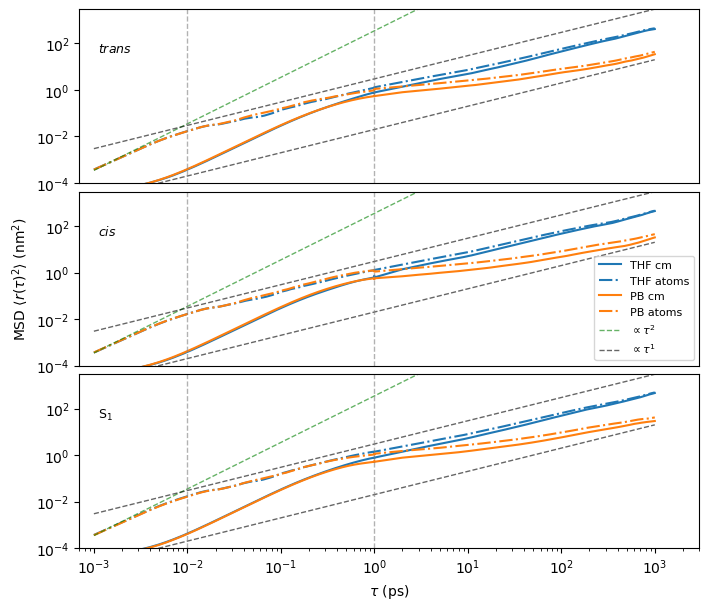

In [142]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,7))

fig.subplots_adjust(hspace=0.05, wspace=0.2)
# fig.suptitle(
#     "Mean square displacement using Center of Mass",
#     fontweight="bold",
#     fontsize=10,
#     y=0.91,
#     x=0.5,
#     ha = "center"
# )

for i, iso in enumerate(MSDMeanscm):
    for sol in MSDMeanscm[iso]:
        msd = MSDMeanscm[iso][sol]
        ax[i].plot(
            msd["time"], msd["msd"],
            "-", lw=1.5, ms=1., label=sol + " cm", color=colors[sol])
        msd_atoms = MSDMeansGlob[iso][sol]["mean"]
        ax[i].plot(
            msd_atoms["time"], msd_atoms["msd"],
            "-.", lw=1.5, ms=1., label=sol + " atoms", color=colors[sol])
                
        # ax[i].set_title("{} - {}".format(labels[iso], sol), fontsize=9)
        
        if sol == "PB":
            ax[i].plot(msd["time"], 350*msd["time"]**2, "--", lw=1., color="green", label=r"$\propto\tau^2$", alpha=0.6)
            ax[i].plot(msd["time"], 3*msd["time"], "--", lw=1., color="k", label=r"$\propto\tau^1$", alpha=0.6)
            ax[i].plot(msd["time"], 0.02*msd["time"], "--", lw=1., color="k", alpha=0.6)
    
    ax[i].text(
            0.03, 0.75,
            "{}".format(labels[iso]), transform=ax[i].transAxes,
            ha="left",
            rotation=0, fontsize=9
        )
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].set_xlim(0.7e-3, 3.0e3)
    ax[i].set_ylim(1.0e-4, 3.0e3)
    ax[i].axvline(x=1e-2, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].axvline(x=1e0, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].set_xlabel(r"$\tau$ (ps)")
    # ax[i].set_ylabel(r"MSD $\langle{r(\tau)^2}\rangle$ (nm$^2$)")
    # ax[i].legend(fontsize=8, loc="lower right")
    
    if i != 2:
        # ax[i, j].set_yticks([])
        ax[i].get_xaxis().set_visible(False)
        
ax[1].legend(fontsize=8, loc="lower right")
ax[1].set_ylabel(r"MSD $\langle{r(\tau)^2}\rangle$ (nm$^2$)")
            
# saveFig("MSD_comparison.png")

## SaveFigPaper.saveFig("MSD_comparison_atoms_cm.png")

plt.show()

Comparison of the MSD obtained for atoms and center of masses

**NOTA**

Agregar MSD cm de las simulaciones largas, MSD/6t

In [151]:
longCol

{'PB': 'red', 'THF': 'darkblue'}

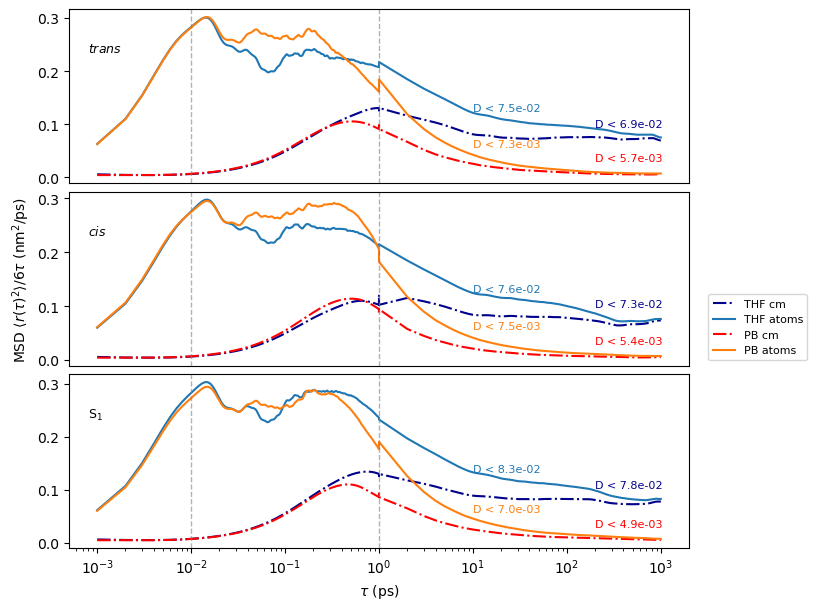

In [153]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,7))

fig.subplots_adjust(hspace=0.05, wspace=0.2)
# fig.suptitle(
#     "Mean square displacement using Center of Mass",
#     fontweight="bold",
#     fontsize=10,
#     y=0.91,
#     x=0.5,
#     ha = "center"
# )

for i, iso in enumerate(MSDMeanscm):
    for sol in MSDMeanscm[iso]:
        msd = MSDMeanscm[iso][sol]
        ax[i].plot(
            msd["time"], msd["msd"]/(6*msd["time"]),
            "-.", lw=1.5, ms=1., label=sol + " cm", color=longCol[sol])
        msd_atoms = MSDMeansGlob[iso][sol]["mean"]
        ax[i].plot(
            msd_atoms["time"], msd_atoms["msd"]/(6*msd_atoms["time"]),
            "-", lw=1.5, ms=1., label=sol + " atoms", color=colors[sol])
                
        # ax[i].set_title("{} - {}".format(labels[iso], sol), fontsize=9)
        
        msdDcoef = msd.tail(10)["msd"]/(6 * msd.tail(10)["time"])
        # print(sol, iso, "\n", msdDcoef.mean())
        ax[i].text(
            200, msdDcoef.mean() + 0.025,
            "D < %.1e" % msdDcoef.mean(),
            ha="left",
            rotation=0, fontsize=8, color=longCol[sol]
        )
        
        msdDcoef = msd_atoms.tail(10)["msd"]/(6 * msd_atoms.tail(10)["time"])
        # print(sol, iso, "\n", msdDcoef.mean())
        ax[i].text(
            10, msdDcoef.mean() + 0.05,
            "D < %.1e" % msdDcoef.mean(),
            ha="left",
            rotation=0, fontsize=8, color=colors[sol]
        )

    ax[i].text(
            0.03, 0.75,
            "{}".format(labels[iso]), transform=ax[i].transAxes,
            ha="left",
            rotation=0, fontsize=9
        )
    
    
    
    
    ax[i].set_xscale("log")
    # ax[i].set_yscale(77"log")
    ##ax[i].set_xlim(0.7e-3, 3.0e3)
    ##ax[i].set_ylim(1.0e-4, 3.0e3)
    ax[i].axvline(x=1e-2, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].axvline(x=1e0, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].set_xlabel(r"$\tau$ (ps)")
    # ax[i].set_ylabel(r"MSD $\langle{r(\tau)^2}\rangle$ (nm$^2$)")
    # ax[i].legend(fontsize=8, loc="lower right")
    
    if i != 2:
        # ax[i, j].set_yticks([])
        ax[i].get_xaxis().set_visible(False)
        
ax[1].legend(fontsize=8, loc="lower right", bbox_to_anchor=(1.2, 0.0))
ax[1].set_ylabel(r"MSD $\langle{r(\tau)^2}\rangle/6\tau$ (nm$^2$/ps)")
            
# saveFig("MSD_comparison.png")

## SaveFigPaper.saveFig("MSD_comparison_atoms_cm.png")

plt.show()

**NOTA**

Modifcar el texto de D

Observar formato de texto

Agregar sim long

### TD-DFT sampling analysis

Creating UV/Visible Plots from the Results of Excited States Calculations

$$\varepsilon_i(\tilde{\nu}) = \varepsilon_i^{{max}}\exp\left[-\left(\frac{\tilde{\nu} - \tilde{\nu}_i}{\sigma}\right)^2\right] $$


[reference](https://gaussian.com/uvvisplot/)

#### News analysis

In [25]:
# GLOBAL

# time

isomers = ["trans", "cis"]
times = ["0_2000", "2000_4000", "4000_6000", "6000_8000", "8000_10000"]  # "0_2000", "2000_4000", "4000_6000", "6000_8000", "8000_10000"
systems = {"solvent": "", "vacuum": "_notSolvent"}
environment = {
    "THF": {
        "path": "../exp.azob.gmx/azob_ISO.thf/md/SamplingUV-Vis_TIMESYS/*.log",
        "dtype": "GMX"
    },
    "PB": {
        "path": "../exp.azob.stamp.3/ISO/6_prod_0_long/SamplingUV-Vis_TIMESYS/*.log",
        "dtype": "GMX"
    }
}
UVVisGLOB = {}
CHECK = []


for iso in isomers:
    UVVisGLOB[iso] = {}
    for sol in environment:
        UVVisGLOB[iso][sol] = {}
        for s in systems:
            UVVisGLOB[iso][sol][s] = {}
            paths = []
            for t in times:
                path = environment[sol]["path"].replace("ISO", iso).replace("TIME", t).replace("SYS", systems[s])
                #print(path)
                #print("N logs:", len(glob.glob(path)))
                paths += glob.glob(path)
                
                
            spectra, info = nbconfig.get_spectre_info(
                paths,
                dtype=environment[sol]["dtype"]
            )
            
            
            if len(spectra) > 0 and len(info) > 0:
                UVVisGLOB[iso][sol][s]["spectre"] = spectra
                UVVisGLOB[iso][sol][s]["info"] = info
                CHECK.append({
                        "isomer": iso,
                        "environment": sol,
                        "system": s,
                        "N": len(info),
                        "Done": ""
                    })
            else:
                CHECK.append({
                        "isomer": iso,
                        "environment": sol,
                        "system": s,
                        "N": len(info),
                        "Done": "x"
                    })
                                
            #print(path)
            #print(spectra)
            #print(info)
            
        


print("#" * 40)
CHECK = pd.DataFrame(CHECK)

##CHECK[CHECK["Done"] == "x"].style.format(subset=["Done"]).apply(isNotMSD, color="red")
CHECK.style.format(subset=["Done"]).apply(isNotMSD, color="red")
     # .hide(subset=list(CHECK["Done"] == "x"))

ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_8000_10000/azoT_THF_08754.log
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_8000_10000/send.log
Number of files analyzed: 465
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_2000_4000_notSolvent/azoT_THF_11401.log
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_2000_4000_notSolvent/send.log
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_4000_6000_notSolvent/azoT_THF_11509.log
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_4000_6000_notSolvent/send.log
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_6000_8000_notSolvent/azoT_THF_08579.log
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_6000_8000_notSolvent/send.log
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_6000_8000_notSolvent/azoT_THF_06768.log
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_8000_10000_notSolvent/send.log

In [26]:
%%time

isomers = ["trans", "cis"]
solvents = ["THF", "PB"]
# replicas = ["0", "1", "2", "3", "4"]
UVVisG = {}
sigma = 0.3
dtype = "cont"


for iso in isomers:
    UVVisG[iso] = {}
    for sol in solvents:
        UVVisG[iso][sol] = {}
        dtype = "cont"
        print(iso, sol)
        path = ""
        if sol == "THF":
            path = f"{home_gro}/{iso}.thf/*/md/SamplingUV-Vis_0_2000/*.log"
        elif sol == "PB":
            path = f"{home_stamp}/{iso}/6_prod_*/SamplingUV-Vis_500_2500/*.log"
            
        if "THF" in sol:
            dtype = "GMX"

        spectre, info = nbconfig.get_spectre_info(
            glob.glob(path),
            dtype=dtype,
            sigma=sigma
        )
            
            
        ## info["d_cnnc"] = get_geom_properties(info, geom, "d_cnnc")
        # info["a_coh"] = get_geom_properties(info, geom, "a_coh_1")
        # info["r_oh"] = get_geom_properties(info, geom, "r_oh_1")
        
        #except KeyError:
        #    print(info)
        #    print(geom)
        #    raise KeyError
        # print(info)
        
        UVVisG[iso][sol]["spectre"] = spectre
        UVVisG[iso][sol]["info"] = info
        
        if sol == "PB":
            path = f"{home_stamp}/{iso}/6_prod_*/SamplingUV-Vis_notSolvent/*.log"
            
            spectre, info = nbconfig.get_spectre_info(
                glob.glob(path),
                dtype=dtype,
                sigma=sigma
            )
    
            UVVisG[iso][f"{sol}-Vac"] = {}
            UVVisG[iso][f"{sol}-Vac"]["spectre"] = spectre
            UVVisG[iso][f"{sol}-Vac"]["info"] = info

trans THF
Number of files analyzed: 500
trans PB
Number of files analyzed: 500
Number of files analyzed: 500
cis THF
Number of files analyzed: 500
cis PB
Number of files analyzed: 500
Number of files analyzed: 500
CPU times: user 40.2 s, sys: 273 ms, total: 40.5 s
Wall time: 40.7 s


IndexError: index 2 is out of bounds for axis 1 with size 2

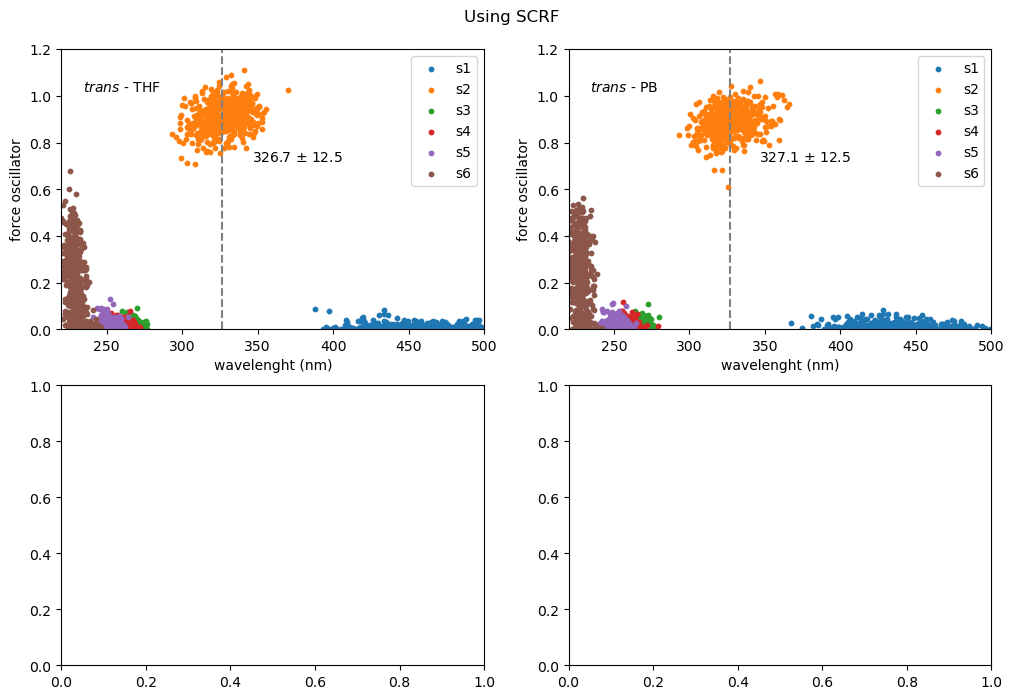

In [27]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))

fig.suptitle("Using SCRF", y=0.93)

for i, iso in enumerate(UVVisG):
    for j, sol in enumerate(UVVisG[iso]):
        ax[i,j].text(
            0.05, 0.85,
            labels[iso] + " - " + sol,
            transform=ax[i, j].transAxes, ha="left", rotation=0, fontsize=10
        )
        
        try:
            data = UVVisG[iso][sol]["info"].copy()
        except KeyError:
            continue
        
        for n in range(1, 7):
            Sn = f"s{n}"
            Fn = f"f{n}"
            ax[i, j].scatter(data[Sn], data[Fn], label=Sn, s=10.)
            
            if Sn == "s2" and iso == "trans":
                ax[i, j].axvline(x=data[Sn].mean(), color="gray", ls="--")
                ax[i, j].text(
                    0.45, 0.6,
                    r"{:.1f} $\pm$ {:.1f}".format(data[Sn].mean(), data[Sn].std()),
                    transform=ax[i, j].transAxes, ha="left", rotation=0, fontsize=10
                )
            
        # ax[i, j].title("Isomer cis")
        ax[i, j].set_xlabel("wavelenght (nm)")
        ax[i, j].set_ylabel("force oscillator")
        ax[i, j].set_xlim(220, 500)
        ax[i, j].set_ylim(0, 1.2)
        ax[i, j].legend()
        

saveFig("foscillator_time_usingSCRF_replicasNews.png")

In [231]:
Table = {}

for iso in ["trans", "cis"]:
    print(iso)
    for sol in UVVisG[iso]:
        print(sol)
        name = f"{iso} - {sol}"
        # print(UVVisG[iso][sol])
        print(UVVisG[iso][sol]["info"]["s2"].mean())
        print(UVVisG[iso][sol]["info"]["s2"].std())
        #    # print("")
        Table[name] = {
                "mean": UVVisG[iso][sol]["info"]["s2"].mean(),
                "std": UVVisG[iso][sol]["info"]["s2"].std()
        }

Table = pd.DataFrame(Table)
Table.round(2).to_csv("table_mean_std.csv", index=True)

trans
THF
326.68752
12.527766173592179
PB
327.05884
12.510669300524812
PB-Vac
315.70394000000005
11.125549459597751
cis
THF
314.7257
13.505187057754139
PB
314.15838
14.614506134478486
PB-Vac
310.57108
14.210754516261364


In [237]:
col_exp = []

for iso in ["trans", "cis"]:
    spec_exp = experiments[iso]["abs"]
    w_exp = experiments[iso]["wl"]
    spec_exp /= spec_exp.max()

    col_exp.append(w_exp[spec_exp ==  spec_exp.max()].values[0])

In [248]:
tabUVVis = {}

for iso in ["trans", "cis"]:
    # print(iso)
    tabUVVis[iso] = {}
    for sol in UVVisG[iso]:
        # print(sol)
        # print(UVVisGLOB[iso][sol])
        name = sol
        # print(name)
        # print(UVVisGLOB[iso][sol][env]["info"]["s2"].mean())
        # print(UVVisGLOB[iso][sol][env]["info"]["s2"].std())
        # print("")
        
        spectre = UVVisG[iso][sol]["spectre"]
        spectre = spectre / spectre.max()
        # print(w_nm[spectre == spectre.max()][0])
        
        # tabUVVis[iso].append({name: w_nm[spectre == spectre.max()][0]})
        tabUVVis[iso][name] = w_nm[spectre == spectre.max()][0]
        ##    "std": UVVisGLOB[iso][sol][env]["info"]["s2"].std()
        ##}
        
        # plt.plot(w_nm, UVVisGLOB[iso][sol][env]["spectre"])

# pd.DataFrame(tabUVVis)
# print(tabUVVis)
tabUVVis = pd.DataFrame(tabUVVis).T
tabUVVis["Exp"] = col_exp
tabUVVis.round(1) # .to_csv("table_lambdamax.csv", index=True)

THF     PB  PB-Vac    Exp
trans  326.5  326.5   315.5  355.1
cis    283.0  293.0   289.5  252.0

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(7, 6))
fig.subplots_adjust(hspace=0.06)
# fig.suptitle("Using SCRF", y=0.93)

for i, iso in enumerate(["trans", "cis"]):
    #ax[i].text(
    #    0.02, 0.85,
    #    labels[iso],
    #    transform=ax[i].transAxes, ha="left", rotation=0, fontsize=12
    #)
    ax[i].set_title(labels[iso], horizontalalignment="left", loc="left", fontsize=10, y=0.85, x=.02)
    
    dexp = experiments[iso].copy()
    ax[i].plot(
        dexp["wl"], dexp["abs"],
        color="k",
        alpha=0.4,
        ls="--",
        lw=2.0,
        label="Exp. (THF solution)"
    )
    
    for sol in UVVisGLOB[iso]:        
        for env in UVVisGLOB[iso][sol]:
            try:
                absorb = UVVisGLOB[iso][sol][env]["spectre"].copy()
            except KeyError:
                continue
                
            ax[i].plot(
                w_nm, absorb/absorb.max(),
                label = sol + " " + env.replace("solvent",""),
                color=formatUV[sol]["color"],
                ls=formatUV[sol][env], lw=1.
            )

            
        # ax[i, j].title("Isomer cis")
    ax[i].set_xlabel("Wavelength (nm)")
    ax[i].set_xlim(230, 600)
    ax[i].set_ylim(0,1.1)
    #ax[i].legend()
    
ax[0].legend(loc='upper right') # , bbox_to_anchor=(1, 0.5))
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylabel("normalized absorbance", y=0.)

# saveFig("spectres_long.png")

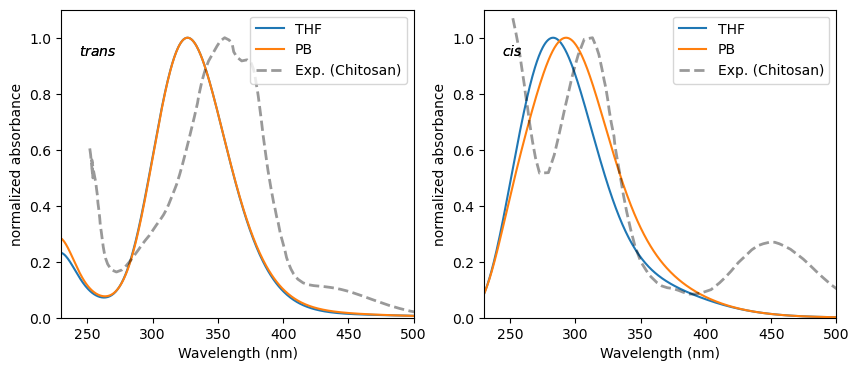

In [221]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

# fig.suptitle("Using SCRF", y=0.93)
w_nm = nbconfig.w_nm

for i, iso in enumerate(UVVisG):
    for sol in UVVisG[iso]:
        ax[i].text(
            0.05, 0.85,
            labels[iso],
            transform=ax[i].transAxes, ha="left", rotation=0, fontsize=10
        )
        
        absorb = UVVisG[iso][sol]["spectre"].copy()
                
        ax[i].plot(w_nm, absorb/absorb.max(), label=sol)
        
    dexp = experiments[iso].copy()
    
    ax[i].plot(
        dexp["wl"], dexp["abs"],
        color="k",
        alpha=0.4,
        ls="--",
        lw=2.0,
        label="Exp. (Chitosan)"
    )
    
    # ax[i, j].title("Isomer cis")
    ax[i].set_ylabel("normalized absorbance")
    ax[i].set_xlabel("Wavelength (nm)")
    ax[i].set_xlim(230, 500)
    ax[i].set_ylim(0, 1.1)
    ax[i].legend()
    
saveFig("UVVis-spectres_news.png")

#### New analysis geomtries

In [28]:
def get_geom_properties(dfinfo, geom, prop="d_cnnc"):
    # GEOM[iso][r] structure
    dfinfo = dfinfo.copy()
    samples = []
    for i in dfinfo.index:
        iso = dfinfo.loc[i, "isomer"]
        r = str(dfinfo.loc[i, "replica"])
        frame = dfinfo.loc[i, "frame"]
        try:
            samples.append(geom.loc[frame, prop])
        except KeyError:
            print(frame, prop)
            print(dfinfo)
            print(geom)
            
            return _
        
    return samples

In [29]:
%%time

isomers = ["trans", "cis"]
solvents = ["THF", "PB"]
replicas = ["0", "1", "2", "3", "4"]
UVVisR = {}
sigma = 0.3

for iso in isomers:
    UVVisR[iso] = {}
    for sol in solvents:
        UVVisR[iso][sol] = {}
        for r in replicas:
            UVVisR[iso][sol][r] = {}
            dtype = "cont"
            print(iso, sol, r)
            path = ""
            path_geom = ""
            if sol == "THF":
                path = f"{home_gro}/{iso}.thf/{r}/md/SamplingUV-Vis_0_2000/*.log"
                path_geom = f"{home_gro}/{iso}.thf/{r}/md/Geometry_mol.csv"
            elif sol == "PB":
                path = f"{home_stamp}/{iso}/6_prod_{r}/SamplingUV-Vis_500_2500/*.log"
                path_geom = f"{home_stamp}/{iso}/6_prod_{r}/Geometry_mol.csv"
            
            if "THF" in sol:
                dtype = "GMX"
                
            if path_geom != "":
                geom = read_geometry_file(
                    path_geom,
                    freq=1.,
                    t0=1.
                )
                if sol == "THF" or sol == "THF vacuum":
                    geom.index -= 1
                #print(geom)
                #break

                
            #print(path)
            #print(dtype)
            
            spectre, info = nbconfig.get_spectre_info(
                glob.glob(path),
                dtype=dtype,
                sigma=sigma
            )
            
            
            info["d_cnnc"] = get_geom_properties(info, geom, "d_cnnc")
            info["a_coh"] = get_geom_properties(info, geom, "a_coh_1")
            info["r_oh"] = get_geom_properties(info, geom, "r_oh_1")
            
            #except KeyError:
            #    print(info)
            #    print(geom)
            #    raise KeyError
            # print(info)
            
            UVVisR[iso][sol][r]["spectre"] = spectre
            UVVisR[iso][sol][r]["info"] = info


trans THF 0
Number of files analyzed: 100
trans THF 1
Number of files analyzed: 100
trans THF 2
Number of files analyzed: 100
trans THF 3
Number of files analyzed: 100
trans THF 4
Number of files analyzed: 100
trans PB 0
Number of files analyzed: 100
trans PB 1
Number of files analyzed: 100
trans PB 2
Number of files analyzed: 100
trans PB 3
Number of files analyzed: 100
trans PB 4
Number of files analyzed: 100
cis THF 0
Number of files analyzed: 100
cis THF 1
Number of files analyzed: 100
cis THF 2
Number of files analyzed: 100
cis THF 3
Number of files analyzed: 100
cis THF 4
Number of files analyzed: 100
cis PB 0
Number of files analyzed: 100
cis PB 1
Number of files analyzed: 100
cis PB 2
Number of files analyzed: 100
cis PB 3
Number of files analyzed: 100
cis PB 4
Number of files analyzed: 100
CPU times: user 27.1 s, sys: 261 ms, total: 27.3 s
Wall time: 27.5 s


In [24]:
GEOMvis = {}

for sol in ["THF", "PB"]:
    tabList = []
    path = ""
    if sol == "PB":
        path += "../exp.azob.stamp.3/trans/6_prod_R/Geometry_mol.csv"
    elif sol == "THF":
        path += "../exp.azob.gmx/trans.thf/R/md/Geometry_mol.csv"
    elif sol == "DCN":
        path += "../exp.azob.gmx/azob_trans.dcn/md/Geometry_mol.csv"
        
        data = read_geometry_file(
            path,
            freq=1.,
            t0=1.
        )
        
        GEOMvis[sol] = data
        continue
        
    
    for i in range(5):
        data = read_geometry_file(
            path.replace("R", str(i)),
                freq=1.,
                t0=1.
            )
        # print(data)
        tabList.append(data)
        
    GEOMvis[sol] = pd.concat(tabList, ignore_index=True)


In [26]:
GEOMvisC = {}

for sol in ["THF", "PB"]:
    tabList = []
    path = ""
    if sol == "PB":
        path += "../exp.azob.stamp.3/cis/6_prod_R/Geometry_mol.csv"
    elif sol == "THF":
        path += "../exp.azob.gmx/cis.thf/R/md/Geometry_mol.csv"
    elif sol == "DCN":
        path += "../exp.azob.gmx/azob_cis.dcn/md/Geometry_mol.csv"
        
        data = read_geometry_file(
            path,
            freq=1.,
            t0=1.
        )
        
        GEOMvisC[sol] = data
        continue
        
    
    for i in range(5):
        data = read_geometry_file(
            path.replace("R", str(i)),
                freq=1.,
                t0=1.
            )
        # print(data)
        tabList.append(data)
        
    GEOMvisC[sol] = pd.concat(tabList, ignore_index=True)


In [ ]:
iso = "trans"
nisomers = len(UVVisR)
nsolvent = len(UVVis[iso])
state = "s2"
# sol = "Polybutadiene"

fig, ax = plt.subplots(nrows=2, figsize=(8, 5))

fig.suptitle(
    "Wavelength distributions - isomer trans", # fontweight="bold",
    fontsize=10,
    y=.92
)

fig.subplots_adjust(hspace=.1)

for i, sol in enumerate(["THF", "PB"]):
    data = []
    for r in range(5):
        data.append(UVVis[iso][sol][str(r)]["info"])
        
    data = pd.concat(data, ignore_index=True)
    ax[i].set_title(sol, fontsize=10, horizontalalignment="left", loc="left", y=0.85, x=0.04)
    # print(data)
    sns.histplot(
            data=data,
            y="s2",
            x="a_coh",
            binwidth=[1.0, 8.0],
            stat="density",
            ax=ax[i],
            color=colors[sol], cbar=True
        )

    ax[i].set_xlabel("angle C-O-H (degree)")
    ax[i].set_ylabel("wavelength [s2] (nm)")
    
    ax[i].set_ylim(290,400)
    ax[i].set_xlim(90,125)
    
    ax[i].axvline(x=data["a_coh"].mean(), ls="--", color="gray", lw=1.0)

ax[0].get_xaxis().set_visible(False)

saveFig("dens_maps_trans_s2_coh.png")

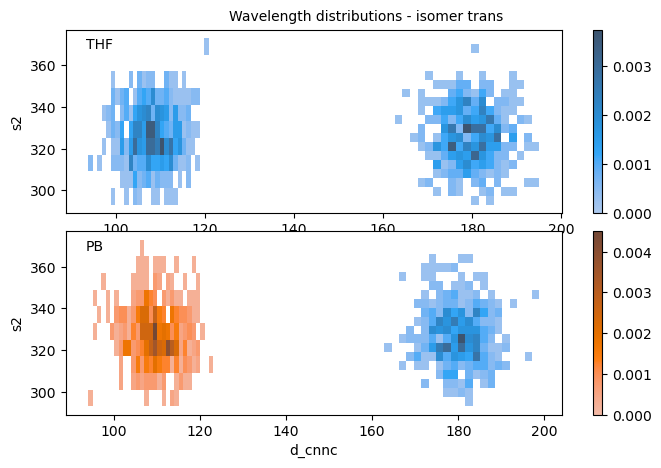

In [157]:
fig, ax = plt.subplots(nrows=2, figsize=(8, 5))
state = "s2"
iso = "trans"
prop = "a_coh"

fig.suptitle(
    "Wavelength distributions - isomer trans", # fontweight="bold",
    fontsize=10,
    y=.92
)

fig.subplots_adjust(hspace=.1)

for i, sol in enumerate(UVVisR[iso]):
    # print(iso + " - " + sol)
    ax[i].set_title(sol, fontsize=10, horizontalalignment="left", loc="left", y=0.85, x=0.04)
        
    ALLDAT = []
    for r in UVVisR[iso][sol]:
        dat = UVVisR[iso][sol][r].copy()
        ALLDAT.append(dat["info"])
        
    alldat = pd.concat(ALLDAT, ignore_index=True)
    alldat["d_cnnc"] = alldat["d_cnnc"].apply(nbconfig.rot)
    
    sns.histplot(data=alldat, x="d_cnnc", y="s2", ax=ax[i])

    sns.histplot(
            data=alldat,
            y="s2",
            x=prop,
            binwidth=[1.0, 8.0],
            stat="density",
            ax=ax[i],
            color=colors[sol], cbar=True
        )
        
    

In [103]:
GEOMvis.keys()

dict_keys(['THF', 'PB'])

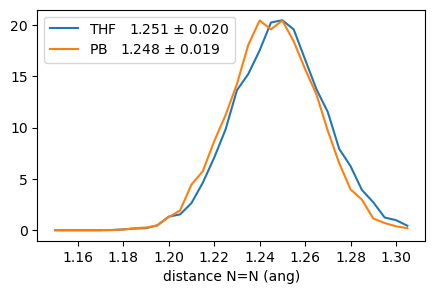

In [27]:
fig, ax = plt.subplots(figsize=(5,3))

for env in GEOMvisC:
    data = GEOMvisC[env].copy()
    dco = data["r_nn"].values
    bins = np.arange(1.15, 1.31, 0.005)
    
    hist, _ = np.histogram(dco, bins=bins, density=True)
    # print(env, dco.mean(), dco.std())
    # 1.354 - 1.343
    ax.plot(
        bins[:-1],
        hist, "-", ms = 3,
        label = "{}   {:.3f} $\pm$ {:.3f}".format(env,dco.mean(),dco.std()))

ax.legend()
ax.set_xlabel(r"distance N=N (ang)")
saveFig("dist_cis_d_nn.png")
plt.show()

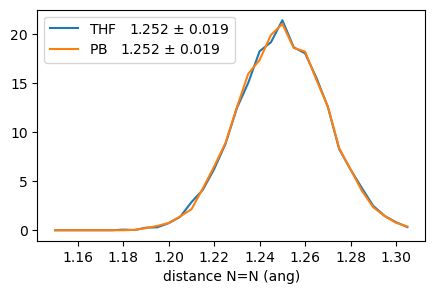

In [28]:
fig, ax = plt.subplots(figsize=(5,3))

for env in GEOMvis:
    data = GEOMvis[env].copy()
    dco = data["r_nn"].values
    bins = np.arange(1.15, 1.31, 0.005)
    
    hist, _ = np.histogram(dco, bins=bins, density=True)
    # print(env, dco.mean(), dco.std())
    # 1.354 - 1.343
    ax.plot(
        bins[:-1],
        hist, "-", ms = 3,
        label = "{}   {:.3f} $\pm$ {:.3f}".format(env,dco.mean(),dco.std()))

ax.legend()
ax.set_xlabel(r"distance N=N (ang)")
saveFig("dist_trans_d_nn.png")
plt.show()

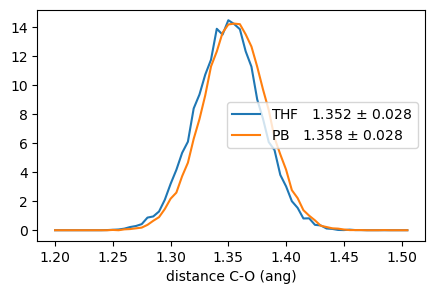

In [29]:
fig, ax = plt.subplots(figsize=(5,3))

for env in GEOMvis:
    data = GEOMvis[env].copy()
    dco = pd.concat([data["r_co_1"], data["r_co_2"]], ignore_index=True).values
    bins = np.arange(1.2, 1.51, 0.005)
    
    hist, _ = np.histogram(dco, bins=bins, density=True)
    # print(env, dco.mean(), dco.std())
    # 1.354 - 1.343
    ax.plot(
        bins[:-1],
        hist, "-", ms = 3,
        label = "{}   {:.3f} $\pm$ {:.3f}".format(env,dco.mean(),dco.std()))

ax.legend()
ax.set_xlabel(r"distance C-O (ang)")
saveFig("dist_trans_d_co.png")
plt.show()

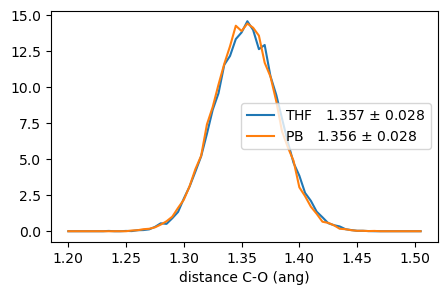

In [30]:
fig, ax = plt.subplots(figsize=(5,3))

for env in GEOMvisC:
    data = GEOMvisC[env].copy()
    dco = pd.concat([data["r_co_1"], data["r_co_2"]], ignore_index=True).values
    bins = np.arange(1.2, 1.51, 0.005)
    
    hist, _ = np.histogram(dco, bins=bins, density=True)
    # print(env, dco.mean(), dco.std())
    # 1.354 - 1.343
    ax.plot(
        bins[:-1],
        hist, "-", ms = 3,
        label = "{}   {:.3f} $\pm$ {:.3f}".format(env,dco.mean(),dco.std()))

ax.legend()
ax.set_xlabel(r"distance C-O (ang)")
saveFig("dist_trans_d_coC.png")
plt.show()

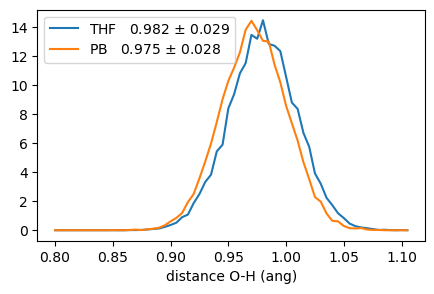

In [31]:
fig, ax = plt.subplots(figsize=(5,3))

for env in GEOMvis:
    data = GEOMvis[env].copy()
    dco = pd.concat([data["r_oh_1"], data["r_oh_2"]], ignore_index=True).values
    bins = np.arange(.8, 1.11, 0.005)
    
    hist, _ = np.histogram(dco, bins=bins, density=True)
    # print(env, dco.mean(), dco.std())
    # 1.354 - 1.343
    ax.plot(
        bins[:-1],
        hist, "-", ms = 3,
        label = "{}   {:.3f} $\pm$ {:.3f}".format(env,dco.mean(),dco.std()))

ax.legend()
ax.set_xlabel(r"distance O-H (ang)")
saveFig("dist_trans_d_oh.png")
plt.show()

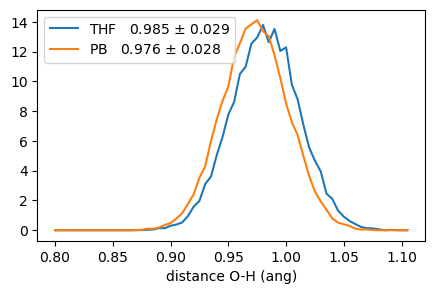

In [32]:
fig, ax = plt.subplots(figsize=(5,3))

for env in GEOMvisC:
    data = GEOMvisC[env].copy()
    dco = pd.concat([data["r_oh_1"], data["r_oh_2"]], ignore_index=True).values
    bins = np.arange(.8, 1.11, 0.005)
    
    hist, _ = np.histogram(dco, bins=bins, density=True)
    # print(env, dco.mean(), dco.std())
    # 1.354 - 1.343
    ax.plot(
        bins[:-1],
        hist, "-", ms = 3,
        label = "{}   {:.3f} $\pm$ {:.3f}".format(env,dco.mean(),dco.std()))

ax.legend()
ax.set_xlabel(r"distance O-H (ang)")
saveFig("dist_trans_d_ohC.png")
plt.show()

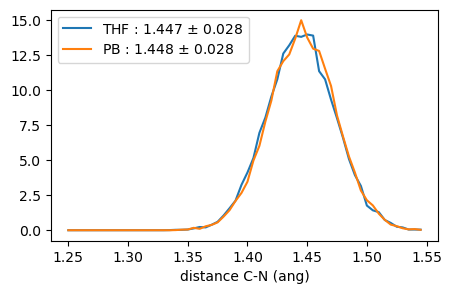

In [34]:
fig, ax = plt.subplots(figsize=(5,3))

for env in GEOMvis:
    data = GEOMvis[env].copy()
    dco = pd.concat([data["r_cn_1"], data["r_cn_2"]], ignore_index=True).values
    bins = np.arange(1.25, 1.55, 0.005)
    
    hist, _ = np.histogram(dco, bins=bins, density=True)
    # print(env, dco.mean(), dco.std())
    # 1.354 - 1.343
    ax.plot(
        bins[:-1],
        hist, "-", ms = 3,
        label = "{} : {:.3f} $\pm$ {:.3f}".format(env,dco.mean(),dco.std()))

ax.legend()
ax.set_xlabel(r"distance C-N (ang)")
saveFig("dist_trans_d_cn.png")
plt.show()

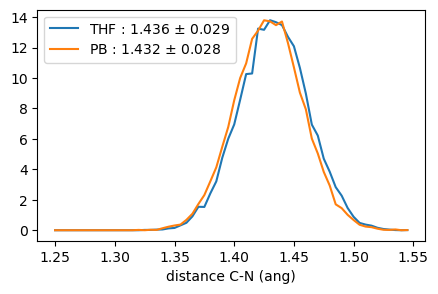

In [35]:
fig, ax = plt.subplots(figsize=(5,3))

for env in GEOMvisC:
    data = GEOMvisC[env].copy()
    dco = pd.concat([data["r_cn_1"], data["r_cn_2"]], ignore_index=True).values
    bins = np.arange(1.25, 1.55, 0.005)
    
    hist, _ = np.histogram(dco, bins=bins, density=True)
    # print(env, dco.mean(), dco.std())
    # 1.354 - 1.343
    ax.plot(
        bins[:-1],
        hist, "-", ms = 3,
        label = "{} : {:.3f} $\pm$ {:.3f}".format(env,dco.mean(),dco.std()))

ax.legend()
ax.set_xlabel(r"distance C-N (ang)")
saveFig("dist_trans_d_cnC.png")
plt.show()

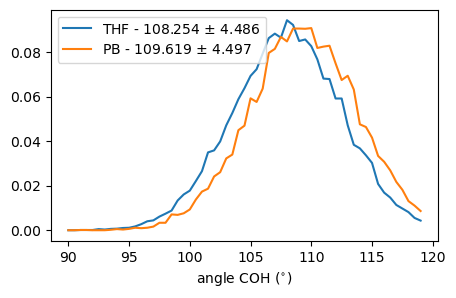

In [36]:
fig, ax = plt.subplots(figsize=(5,3))

for env in GEOMvis:
    data = GEOMvis[env].copy()
    dco = pd.concat([data["a_coh_1"], data["a_coh_2"]], ignore_index=True).values
    bins = np.arange(90., 120, 0.5)
    
    hist, _ = np.histogram(dco, bins=bins, density=True)
    # print(env, dco.mean(), dco.std())
    # 1.354 - 1.343
    ax.plot(
        bins[:-1],
        hist, "-", ms = 3,
        label = "{} - {:.3f} $\pm$ {:.3f}".format(env,dco.mean(),dco.std()))

ax.legend()
ax.set_xlabel(r"angle COH ($^{\circ}$)")
saveFig("dist_trans_a_coh.png")
plt.show()

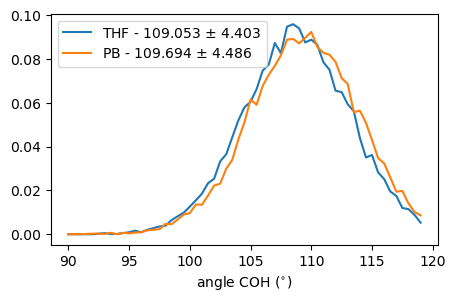

In [216]:
fig, ax = plt.subplots(figsize=(5,3))

for env in GEOMvisC:
    data = GEOMvisC[env].copy()
    dco = pd.concat([data["a_coh_1"], data["a_coh_2"]], ignore_index=True).values
    bins = np.arange(90., 120, 0.5)
    
    hist, _ = np.histogram(dco, bins=bins, density=True)
    # print(env, dco.mean(), dco.std())
    # 1.354 - 1.343
    ax.plot(
        bins[:-1],
        hist, "-", ms = 3,
        label = "{} - {:.3f} $\pm$ {:.3f}".format(env,dco.mean(),dco.std()))

ax.legend()
ax.set_xlabel(r"angle COH ($^{\circ}$)")
saveFig("dist_trans_a_cohC.png")
plt.show()

#### Long simulations

In [77]:
# GLOBAL

# time

isomers = ["trans", "cis"]
times = ["0_2000", "2000_4000", "4000_6000", "6000_8000", "8000_10000"]  # "0_2000", "2000_4000", "4000_6000", "6000_8000", "8000_10000"
systems = {"solvent": "", "vacuum": "_notSolvent"}
environment = {
    "THF": {
        "path": "../exp.azob.gmx/azob_ISO.thf/md/SamplingUV-Vis_TIMESYS/*.log",
        "dtype": "GMX"
    },
    "PB": {
        "path": "../exp.azob.stamp.3/ISO/6_prod_0_long/SamplingUV-Vis_TIMESYS/*.log",
        "dtype": "GMX"
    }
}
UVVisGLOB = {}
CHECK = []


for iso in isomers:
    UVVisGLOB[iso] = {}
    for sol in environment:
        UVVisGLOB[iso][sol] = {}
        for s in systems:
            UVVisGLOB[iso][sol][s] = {}
            paths = []
            for t in times:
                path = environment[sol]["path"].replace("ISO", iso).replace("TIME", t).replace("SYS", systems[s])
                #print(path)
                #print("N logs:", len(glob.glob(path)))
                paths += glob.glob(path)
                
                
            spectra, info = nbconfig.get_spectre_info(
                paths,
                dtype=environment[sol]["dtype"]
            )
            
            
            if len(spectra) > 0 and len(info) > 0:
                UVVisGLOB[iso][sol][s]["spectre"] = spectra
                UVVisGLOB[iso][sol][s]["info"] = info
                CHECK.append({
                        "isomer": iso,
                        "environment": sol,
                        "system": s,
                        "N": len(info),
                        "Done": ""
                    })
            else:
                CHECK.append({
                        "isomer": iso,
                        "environment": sol,
                        "system": s,
                        "N": len(info),
                        "Done": "x"
                    })
                                
            #print(path)
            #print(spectra)
            #print(info)
            
        


print("#" * 40)
CHECK = pd.DataFrame(CHECK)

##CHECK[CHECK["Done"] == "x"].style.format(subset=["Done"]).apply(isNotMSD, color="red")
CHECK.style.format(subset=["Done"]).apply(isNotMSD, color="red")
     # .hide(subset=list(CHECK["Done"] == "x"))

ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_8000_10000/azoT_THF_08754.log
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_8000_10000/send.log
Number of files analyzed: 465
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_2000_4000_notSolvent/azoT_THF_11401.log
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_2000_4000_notSolvent/send.log
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_4000_6000_notSolvent/azoT_THF_11509.log
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_4000_6000_notSolvent/send.log
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_6000_8000_notSolvent/azoT_THF_08579.log
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_6000_8000_notSolvent/send.log
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_6000_8000_notSolvent/azoT_THF_06768.log
ERROR in file: ../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_8000_10000_notSolvent/send.log

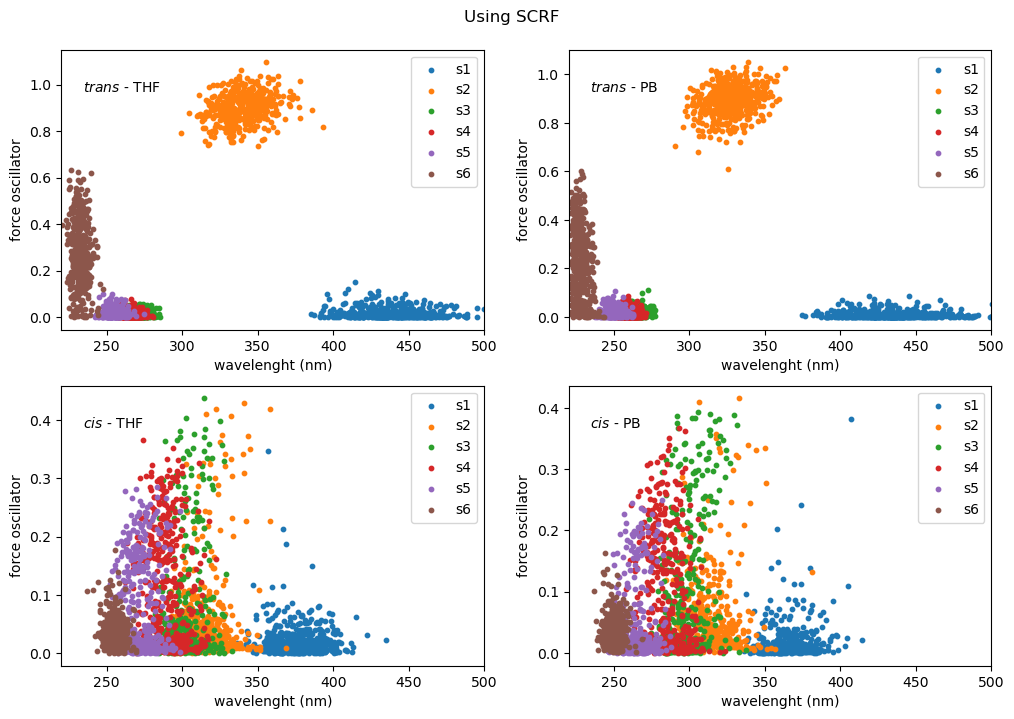

In [23]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))

fig.suptitle("Using SCRF", y=0.93)

for i, iso in enumerate(UVVisGLOB):
    for j, sol in enumerate(UVVisGLOB[iso]):
        ax[i,j].text(
            0.05, 0.85,
            labels[iso] + " - " + sol,
            transform=ax[i, j].transAxes, ha="left", rotation=0, fontsize=10
        )
        
        try:
            data = UVVisGLOB[iso][sol]["solvent"]["info"].copy()
        except KeyError:
            continue
        
        for n in range(1, 7):
            Sn = f"s{n}"
            Fn = f"f{n}"
            ax[i, j].scatter(data[Sn], data[Fn], label=Sn, s=10.)
            
        # ax[i, j].title("Isomer cis")
        ax[i, j].set_xlabel("wavelenght (nm)")
        ax[i, j].set_ylabel("force oscillator")
        ax[i, j].set_xlim(220, 500)
        ax[i, j].legend()
        

# saveFig("foscillator_time_usingSCRF_long.png")
        

In [44]:
Table = {}

for iso in ["trans"]:
    # print(iso)
    for sol in UVVisGLOB[iso]:
        # print(sol)
        # print(UVVisGLOB[iso][sol])
        for env in UVVisGLOB[iso][sol]:
            name = sol + env.replace("solvent","").replace("vacuum"," vac")
            # print(name)
            # print(UVVisGLOB[iso][sol][env]["info"]["s2"].mean())
            # print(UVVisGLOB[iso][sol][env]["info"]["s2"].std())
            # print("")
            Table[name] = {
                "mean": UVVisGLOB[iso][sol][env]["info"]["s2"].mean(),
                "std": UVVisGLOB[iso][sol][env]["info"]["s2"].std()
            }

Table = pd.DataFrame(Table)
Table.round(2)

THF  THF vac      PB  PB vac
mean  339.93   326.03  326.93  315.84
std    13.76    12.22   12.20   10.87

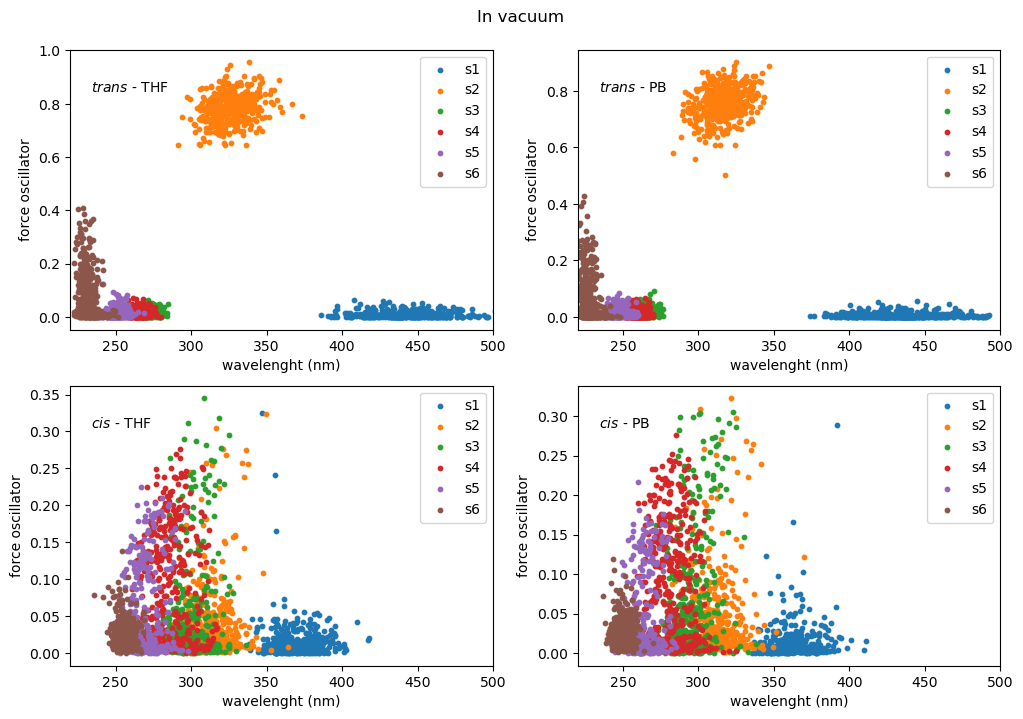

In [46]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))

fig.suptitle("In vacuum", y=0.93)

for i, iso in enumerate(UVVisGLOB):
    for j, sol in enumerate(UVVisGLOB[iso]):
        ax[i,j].text(
            0.05, 0.85,
            labels[iso] + " - " + sol,
            transform=ax[i, j].transAxes, ha="left", rotation=0, fontsize=10
        )
        
        try:
            data = UVVisGLOB[iso][sol]["vacuum"]["info"].copy()
        except KeyError:
            continue
        
        for n in range(1, 7):
            Sn = f"s{n}"
            Fn = f"f{n}"
            ax[i, j].scatter(data[Sn], data[Fn], label=Sn, s=10.)
            
        # ax[i, j].title("Isomer cis")
        ax[i, j].set_xlabel("wavelenght (nm)")
        ax[i, j].set_ylabel("force oscillator")
        ax[i, j].set_xlim(220, 500)
        ax[i, j].legend()
        
# saveFig("foscillator_time_usingSCRF_long_vide.png")

In [114]:
# Experimental data
trans_exp = pd.read_csv("UV-cis.csv", header=None, names=["wl", "abs", "2", "3"])
cis_exp = pd.read_csv("UV-trans.csv", header=None, names=["wl", "abs", "2", "3"])

cis_exp["abs"] = cis_exp["abs"]/cis_exp["abs"][cis_exp["wl"] > 300].max()
trans_exp["abs"] = trans_exp["abs"]/trans_exp["abs"][trans_exp["wl"] > 300].max()

experiments = {
    "trans": trans_exp,
    "cis": cis_exp
}

w_nm = nbconfig.w_nm

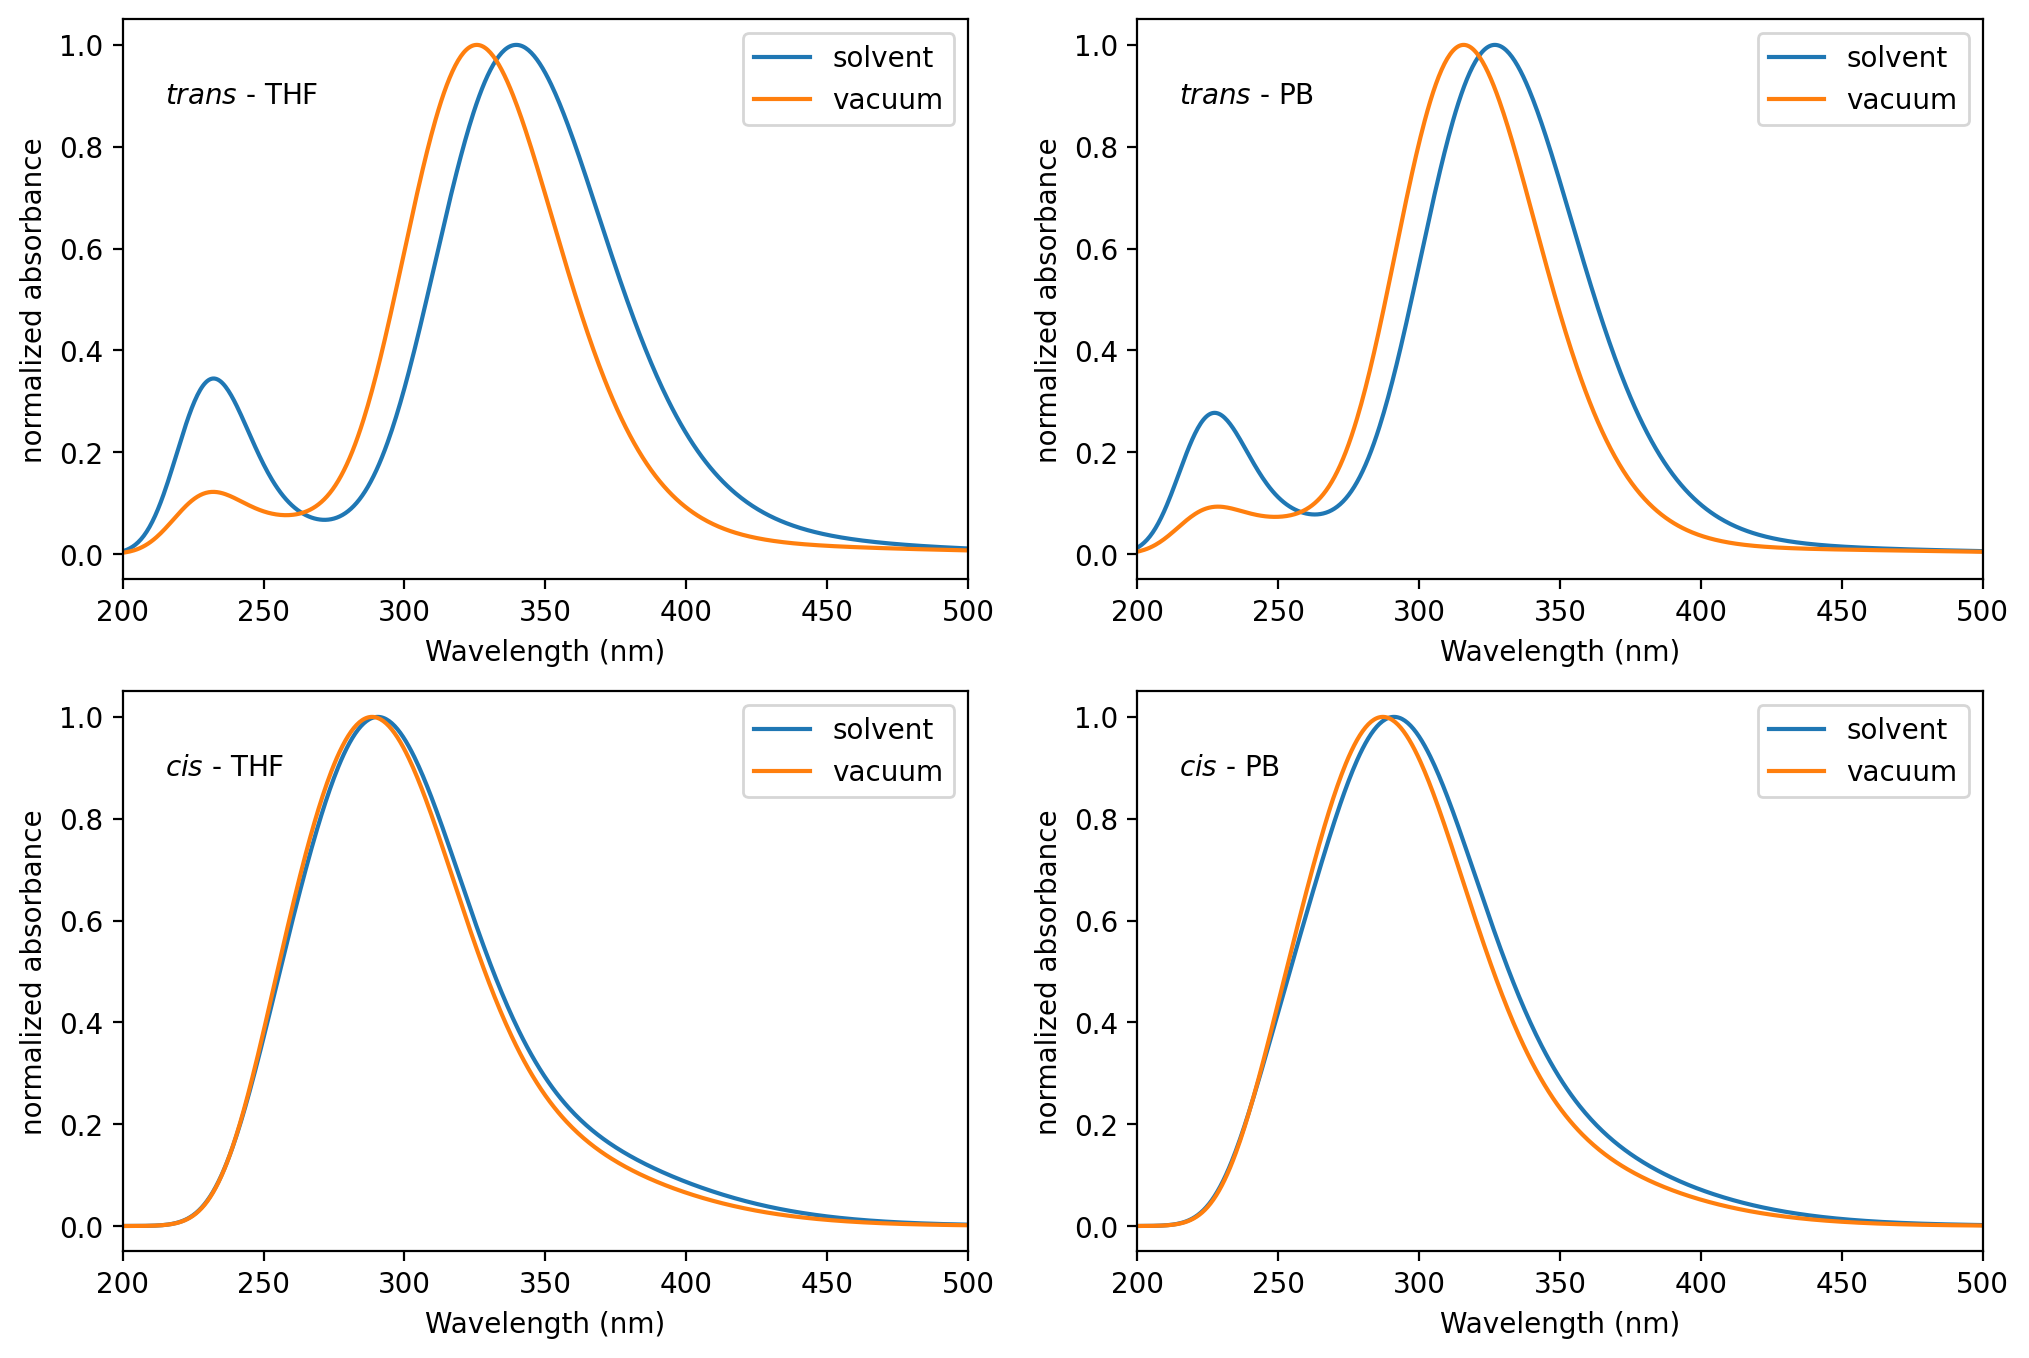

In [87]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), dpi=200.)

# fig.suptitle("Using SCRF", y=0.93)

for i, iso in enumerate(UVVisGLOB):
    for j, sol in enumerate(UVVisGLOB[iso]):
        ax[i,j].text(
            0.05, 0.85,
            labels[iso] + " - " + sol,
            transform=ax[i, j].transAxes, ha="left", rotation=0, fontsize=10
        )
        
        for env in UVVisGLOB[iso][sol]:
            try:
                absorb = UVVisGLOB[iso][sol][env]["spectre"].copy()
            except KeyError:
                continue
                
            ax[i, j].plot(w_nm, absorb/absorb.max(), label=env)
            
            
        # ax[i, j].title("Isomer cis")
        ax[i, j].set_ylabel("normalized absorbance")
        ax[i, j].set_xlabel("Wavelength (nm)")
        ax[i, j].set_xlim(200, 500)
        ax[i, j].legend()
        

In [59]:
formatUV = {
    "THF": {
        "color": "tab:blue",
        "vacuum": "--",
        "solvent": "-"
    },
    "PB": {
        "color": "tab:orange",
        "vacuum": "--",
        "solvent": "-"
    }
}

Text(0, 0.0, 'normalized absorbance')

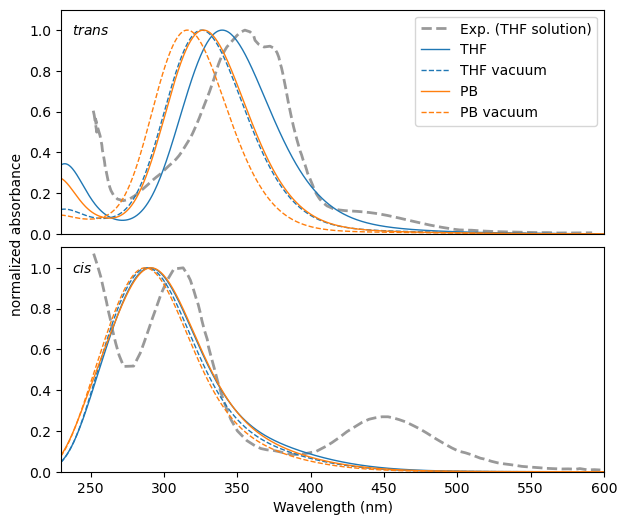

In [63]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(7, 6))
fig.subplots_adjust(hspace=0.06)
# fig.suptitle("Using SCRF", y=0.93)

for i, iso in enumerate(["trans", "cis"]):
    #ax[i].text(
    #    0.02, 0.85,
    #    labels[iso],
    #    transform=ax[i].transAxes, ha="left", rotation=0, fontsize=12
    #)
    ax[i].set_title(labels[iso], horizontalalignment="left", loc="left", fontsize=10, y=0.85, x=.02)
    
    dexp = experiments[iso].copy()
    ax[i].plot(
        dexp["wl"], dexp["abs"],
        color="k",
        alpha=0.4,
        ls="--",
        lw=2.0,
        label="Exp. (THF solution)"
    )
    
    for sol in UVVisGLOB[iso]:        
        for env in UVVisGLOB[iso][sol]:
            try:
                absorb = UVVisGLOB[iso][sol][env]["spectre"].copy()
            except KeyError:
                continue
                
            ax[i].plot(
                w_nm, absorb/absorb.max(),
                label = sol + " " + env.replace("solvent",""),
                color=formatUV[sol]["color"],
                ls=formatUV[sol][env], lw=1.
            )

            
        # ax[i, j].title("Isomer cis")
    ax[i].set_xlabel("Wavelength (nm)")
    ax[i].set_xlim(230, 600)
    ax[i].set_ylim(0,1.1)
    #ax[i].legend()
    
ax[0].legend(loc='upper right') # , bbox_to_anchor=(1, 0.5))
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylabel("normalized absorbance", y=0.)

# saveFig("spectres_long.png")

In [ ]:
Table = {}

for iso in ["trans"]:
    # print(iso)
    for sol in UVVisGLOB[iso]:
        # print(sol)
        # print(UVVisGLOB[iso][sol])
        for env in UVVisGLOB[iso][sol]:
            name = sol + env.replace("solvent","").replace("vacuum"," vac")
            # print(name)
            # print(UVVisGLOB[iso][sol][env]["info"]["s2"].mean())
            # print(UVVisGLOB[iso][sol][env]["info"]["s2"].std())
            # print("")
            Table[name] = {
                "mean": UVVisGLOB[iso][sol][env]["info"]["s2"].mean(),
                "std": UVVisGLOB[iso][sol][env]["info"]["s2"].std()
            }

Table = pd.DataFrame(Table)
Table.round(2)

In [107]:
tabUVVis = {}

for iso in ["trans", "cis"]:
    # print(iso)
    tabUVVis[iso] = {}
    for sol in UVVisGLOB[iso]:
        # print(sol)
        # print(UVVisGLOB[iso][sol])
        for env in UVVisGLOB[iso][sol]:
            name = sol + env.replace("solvent","").replace("vacuum"," vac")
            # print(name)
            # print(UVVisGLOB[iso][sol][env]["info"]["s2"].mean())
            # print(UVVisGLOB[iso][sol][env]["info"]["s2"].std())
            # print("")
            
            spectre = UVVisGLOB[iso][sol][env]["spectre"]
            spectre = spectre / spectre.max()
            # print(w_nm[spectre == spectre.max()][0])
            
            tabUVVis[iso][name] = w_nm[spectre == spectre.max()][0]
            ##    "std": UVVisGLOB[iso][sol][env]["info"]["s2"].std()
            ##}
            
            # plt.plot(w_nm, UVVisGLOB[iso][sol][env]["spectre"])

# pd.DataFrame(tabUVVis)
tabUVVis = pd.DataFrame(tabUVVis).T
tabUVVis["Exp"] = col_exp
tabUVVis.round(1)

THF  THF vac     PB  PB vac    Exp
trans  339.5    325.5  327.0   316.0  355.1
cis    290.5    288.5  291.0   287.0  252.0

In [ ]:
# GLOBAL

# time

isomers = ["trans", "cis"]
times = ["0_2000", "2000_4000", "4000_6000", "6000_8000", "8000_10000"]  # "0_2000", "2000_4000", "4000_6000", "6000_8000", "8000_10000"
systems = {"solvent": "", "vacuum": "_notSolvent"}
environment = {
    "THF": {
        "path": "../exp.azob.gmx/azob_ISO.thf/md/SamplingUV-Vis_TIMESYS/*.log",
        "dtype": "GMX"
    },
    "PB": {
        "path": "../exp.azob.stamp.3/ISO/6_prod_0_long/SamplingUV-Vis_TIMESYS/*.log",
        "dtype": "GMX"
    }
}
UVVisGLOB = {}
CHECK = []


for iso in isomers:
    UVVisGLOB[iso] = {}
    for sol in environment:
        UVVisGLOB[iso][sol] = {}
        for s in systems:
            UVVisGLOB[iso][sol][s] = {}
            paths = []
            for t in times:
                path = environment[sol]["path"].replace("ISO", iso).replace("TIME", t).replace("SYS", systems[s])
                print(path)
                print("N logs:", len(glob.glob(path)))
                paths += glob.glob(path)
                
                
            spectra, info = nbconfig.get_spectre_info(
                paths,
                dtype=environment[sol]["dtype"]
            )
            
            
            if len(spectra) > 0 and len(info) > 0:
                UVVisGLOB[iso][sol][s]["spectre"] = spectra
                UVVisGLOB[iso][sol][s]["info"] = info
                CHECK.append({
                        "isomer": iso,
                        "environment": sol,
                        "system": s,
                        "N": len(info),
                        "Done": ""
                    })
            else:
                CHECK.append({
                        "isomer": iso,
                        "environment": sol,
                        "system": s,
                        "N": len(info),
                        "Done": "x"
                    })
                                
            #print(path)
            #print(spectra)
            #print(info)
            
        


print("#" * 40)
CHECK = pd.DataFrame(CHECK)

##CHECK[CHECK["Done"] == "x"].style.format(subset=["Done"]).apply(isNotMSD, color="red")
CHECK.style.format(subset=["Done"]).apply(isNotMSD, color="red")
     # .hide(subset=list(CHECK["Done"] == "x"))

In [60]:
%%time

isomers = ["trans", "cis"]
times = ["0_2000", "2000_4000", "4000_6000", "6000_8000"]
systems = {"solvent": "", "vacuum": "_notSolvent"}
environment = {
    "thf": {
        "path": "../exp.azob.gmx/azob_ISO.thf/md/SamplingUV-Vis_TIMESYS/*.log",
        "dtype": "GMX"
    }
}
UVVisLong = {}
CHECK = []


for iso in isomers:
    UVVisLong[iso] = {}
    for sol in environment:
        UVVisLong[iso][sol] = {}
        for s in systems:
            UVVisLong[iso][sol][s] = {}
            UVVisLong[iso][sol][s]["times"] = {}
            for t in times:
                path = environment[sol]["path"].replace("ISO", iso).replace("TIME", t).replace("SYS", systems[s])
                print(path)
                spectra, info = nbconfig.get_spectre_info(
                    glob.glob(path),
                    dtype=environment[sol]["dtype"]
                )
                
                if len(spectra) > 0 and len(info) > 0:
                    UVVisLong[iso][sol][s]["times"][t] = {}
                    UVVisLong[iso][sol][s]["times"][t]["spectre"] = spectra
                    UVVisLong[iso][sol][s]["times"][t]["info"] = info
                    CHECK.append({
                        "isomer": iso,
                        "environment": sol,
                        "time": t,
                        "system": s,
                        "Done": ""
                    })
                
                else:
                    CHECK.append({
                        "isomer": iso,
                        "environment": sol,
                        "time": t,
                        "system": s,
                        "Done": "x"
                    })
                                
            #print(path)
            #print(spectra)
            #print(info)
            
        
UVVisLong

print("#" * 40)
CHECK = pd.DataFrame(CHECK)

##CHECK[CHECK["Done"] == "x"].style.format(subset=["Done"]).apply(isNotMSD, color="red")
CHECK.style.format(subset=["Done"]).apply(isNotMSD, color="red")
     # .hide(subset=list(CHECK["Done"] == "x"))

../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_0_2000/*.log
Number of files analyzed: 100
../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_2000_4000/*.log
Number of files analyzed: 100
../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_4000_6000/*.log
Number of files analyzed: 100
../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_6000_8000/*.log
Number of files analyzed: 100
../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_0_2000_notSolvent/*.log
Number of files analyzed: 100
../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_2000_4000_notSolvent/*.log
../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_4000_6000_notSolvent/*.log
../exp.azob.gmx/azob_trans.thf/md/SamplingUV-Vis_6000_8000_notSolvent/*.log
../exp.azob.gmx/azob_cis.thf/md/SamplingUV-Vis_0_2000/*.log
Number of files analyzed: 100
../exp.azob.gmx/azob_cis.thf/md/SamplingUV-Vis_2000_4000/*.log
Number of files analyzed: 100
../exp.azob.gmx/azob_cis.thf/md/SamplingUV-Vis_4000_6000/*.log
Number of files analyzed: 100
../exp.azob.gmx/

#### Per replicas

In [34]:
def get_geom_properties(dfinfo, geom, prop="d_cnnc"):
    # GEOM[iso][r] structure
    dfinfo = dfinfo.copy()
    samples = []
    for i in dfinfo.index:
        iso = dfinfo.loc[i, "isomer"]
        r = str(dfinfo.loc[i, "replica"])
        frame = dfinfo.loc[i, "frame"]
        try:
            samples.append(geom.loc[frame, prop])
        except KeyError:
            print(frame, prop, geom, dfinfo)
            continue
        
    return samples

In [ ]:
%%time

isomers = ["trans", "cis"]
solvents = ["THF", "PB"]
replicas = ["0", "1", "2", "3", "4"]
UVVis = {}
sigma = 0.3
dtype = "cont"


for iso in isomers:
    UVVis[iso] = {}
    for sol in solvents:
        UVVis[iso][sol] = {}
        for r in replicas:
            UVVis[iso][sol][r] = {}
            print(iso, sol, r)
            path = ""
            path_geom = ""
            if sol == "THF":
                path = f"{home_gro}/{iso}.thf/{r}/md/SamplingUV-Vis_0_2000/*.log"
                path_geom = f"{home_gro}/{iso}.thf/{r}/md/Geometry_mol.csv"
            elif sol == "PB":
                path = f"{home_stamp}/{iso}/6_prod_{r}/SamplingUV-Vis_500_2500/*.log"
                path_geom = f"{home_stamp}/{iso}/6_prod_{r}/Geometry_mol.csv"
            
            if "THF" in sol:
                dtype = "GMX"
                
            if path_geom != "":
                geom = read_geometry_file(
                    path_geom,
                    freq=1.,
                    t0=1.
                )
                if sol == "THF" or sol == "THF vacuum":
                    geom.index -= 1
                #print(geom)
                #break

                
            #print(path)
            #print(dtype)
            
            spectre, info = nbconfig.get_spectre_info(
                glob.glob(path),
                dtype=dtype,
                sigma=sigma
            )
            
            
            ## info["d_cnnc"] = get_geom_properties(info, geom, "d_cnnc")
            # info["a_coh"] = get_geom_properties(info, geom, "a_coh_1")
            # info["r_oh"] = get_geom_properties(info, geom, "r_oh_1")
            
            #except KeyError:
            #    print(info)
            #    print(geom)
            #    raise KeyError
            # print(info)
            
            UVVis[iso][sol][r]["spectre"] = spectre
            UVVis[iso][sol][r]["info"] = info
            
            dtype = "cont"


In [36]:
%%time

isomers = ["trans", "cis"]
solvents = ["THF", "PB"]
replicas = ["0", "1", "2", "3", "4"]
UVVis = {}
sigma = 0.3
dtype = "cont"


for iso in isomers:
    UVVis[iso] = {}
    for sol in solvents:
        UVVis[iso][sol] = {}
        for r in replicas:
            UVVis[iso][sol][r] = {}
            print(iso, sol, r)
            path = ""
            path_geom = ""
            if sol == "THF":
                path = f"{home_gro}/{iso}.thf/{r}/md/SamplingUV-Vis_0_2000/*.log"
                path_geom = f"{home_gro}/{iso}.thf/{r}/md/Geometry_mol.csv"
            elif sol == "PB":
                path = f"{home_stamp}/{iso}/6_prod_{r}/SamplingUV-Vis_500_2500/*.log"
                path_geom = f"{home_stamp}/{iso}/6_prod_{r}/Geometry_mol.csv"
            
            if "THF" in sol:
                dtype = "GMX"
                
            if path_geom != "":
                geom = read_geometry_file(
                    path_geom,
                    freq=1.,
                    t0=1.
                )
                if sol == "THF" or sol == "THF vacuum":
                    geom.index -= 1
                #print(geom)
                #break

                
            #print(path)
            #print(dtype)
            
            spectre, info = nbconfig.get_spectre_info(
                glob.glob(path),
                dtype=dtype,
                sigma=sigma
            )
            
            
            ## info["d_cnnc"] = get_geom_properties(info, geom, "d_cnnc")
            # info["a_coh"] = get_geom_properties(info, geom, "a_coh_1")
            # info["r_oh"] = get_geom_properties(info, geom, "r_oh_1")
            
            #except KeyError:
            #    print(info)
            #    print(geom)
            #    raise KeyError
            # print(info)
            
            UVVis[iso][sol][r]["spectre"] = spectre
            UVVis[iso][sol][r]["info"] = info
            
            dtype = "cont"


trans THF 0
Number of files analyzed: 100
trans THF 1
Number of files analyzed: 100
trans THF 2
Number of files analyzed: 100
trans THF 3
Number of files analyzed: 100
trans THF 4
Number of files analyzed: 100
trans PB 0
Number of files analyzed: 100
trans PB 1
Number of files analyzed: 100
trans PB 2
Number of files analyzed: 100
trans PB 3
Number of files analyzed: 100
trans PB 4
Number of files analyzed: 100
cis THF 0
Number of files analyzed: 100
cis THF 1
Number of files analyzed: 100
cis THF 2
Number of files analyzed: 100
cis THF 3
Number of files analyzed: 100
cis THF 4
Number of files analyzed: 100
cis PB 0
Number of files analyzed: 100
cis PB 1
Number of files analyzed: 100
cis PB 2
Number of files analyzed: 100
cis PB 3
Number of files analyzed: 100
cis PB 4
Number of files analyzed: 100
CPU times: user 26.2 s, sys: 223 ms, total: 26.5 s
Wall time: 26.7 s


In [ ]:
%%time

isomers = ["trans"]
solvents = ["THF", "THF vacuum", "PB", "PB vacuum"]
replicas = ["0", "1", "2", "3", "4"]
UVVis = {}
sigma = 0.3
dtype = "cont"


for iso in isomers:
    UVVis[iso] = {}
    for sol in solvents:
        UVVis[iso][sol] = {}
        for r in replicas:
            UVVis[iso][sol][r] = {}
            print(iso, sol, r)
            path = ""
            path_geom = ""
            if sol == "THF":
                path = f"{home_gro}/azob_{iso}.thf.densf/md{r}/SamplingUV-Vis_0_2000/*.log"
                path_geom = f"{home_gro}/azob_{iso}.thf.densf/md{r}/Geometry_mol.csv"
            elif sol == "THF vacuum":
                path = f"{home_gro}/azob_{iso}.thf.densf/md{r}/SamplingUV-Vis_notSolvent/*.log"
                path_geom = f"{home_gro}/azob_{iso}.thf.densf/md{r}/Geometry_mol.csv"
            elif sol == "PB":
                path = f"{home_stamp}/{iso}/6_prod_{r}/SamplingUV-Vis_500_2500/*.log"
                path_geom = f"{home_stamp}/{iso}/6_prod_{r}/Geometry_mol.csv"
            elif sol == "PB vacuum":
                path = f"{home_stamp}/{iso}/6_prod_{r}/SamplingUV-Vis_notSolvent/*.log"
                path_geom = f"{home_stamp}/{iso}/6_prod_{r}/Geometry_mol.csv"
            
            if "THF" in sol:
                dtype = "GMX"
                
            if path_geom != "":
                geom = read_geometry_file(
                    path_geom,
                    freq=1.,
                    t0=1.
                )
                if sol == "THF" or sol == "THF vacuum":
                    geom.index -= 1
                #print(geom)
                #break

                
            #print(path)
            #print(dtype)
            
            spectre, info = nbconfig.get_spectre_info(
                glob.glob(path),
                dtype=dtype,
                sigma=sigma
            )
            
            
            info["d_cnnc"] = get_geom_properties(info, geom, "d_cnnc")
            info["a_coh"] = get_geom_properties(info, geom, "a_coh_1")
            info["r_oh"] = get_geom_properties(info, geom, "r_oh_1")
            
            #except KeyError:
            #    print(info)
            #    print(geom)
            #    raise KeyError
            # print(info)
            
            UVVis[iso][sol][r]["spectre"] = spectre
            UVVis[iso][sol][r]["info"] = info
            
            dtype = "cont"


In [ ]:
%%time

isomers = ["trans"]
solvents = ["THF", "THF vacuum", "PB", "PB vacuum"]
replicas = ["0", "1", "2", "3", "4"]
UVVis = {}
sigma = 0.3
dtype = "cont"


for iso in isomers:
    UVVis[iso] = {}
    for sol in solvents:
        UVVis[iso][sol] = {}
        for r in replicas:
            UVVis[iso][sol][r] = {}
            print(iso, sol, r)
            path = ""
            path_geom = ""
            if sol == "THF":
                path = f"{home_gro}/azob_{iso}.thf.densf/md{r}/SamplingUV-Vis_0_2000/*.log"
                path_geom = f"{home_gro}/azob_{iso}.thf.densf/md{r}/Geometry_mol.csv"
            elif sol == "THF vacuum":
                path = f"{home_gro}/azob_{iso}.thf.densf/md{r}/SamplingUV-Vis_notSolvent/*.log"
                path_geom = f"{home_gro}/azob_{iso}.thf.densf/md{r}/Geometry_mol.csv"
            elif sol == "PB":
                path = f"{home_stamp}/{iso}/6_prod_{r}/SamplingUV-Vis_500_2500/*.log"
                path_geom = f"{home_stamp}/{iso}/6_prod_{r}/Geometry_mol.csv"
            elif sol == "PB vacuum":
                path = f"{home_stamp}/{iso}/6_prod_{r}/SamplingUV-Vis_notSolvent/*.log"
                path_geom = f"{home_stamp}/{iso}/6_prod_{r}/Geometry_mol.csv"
            
            if "THF" in sol:
                dtype = "GMX"
                
            if path_geom != "":
                geom = read_geometry_file(
                    path_geom,
                    freq=1.,
                    t0=1.
                )
                if sol == "THF" or sol == "THF vacuum":
                    geom.index -= 1
                #print(geom)
                #break

                
            #print(path)
            #print(dtype)
            
            spectre, info = nbconfig.get_spectre_info(
                glob.glob(path),
                dtype=dtype,
                sigma=sigma
            )
            
            
            info["d_cnnc"] = get_geom_properties(info, geom, "d_cnnc")
            info["a_coh"] = get_geom_properties(info, geom, "a_coh_1")
            info["r_oh"] = get_geom_properties(info, geom, "r_oh_1")
            
            #except KeyError:
            #    print(info)
            #    print(geom)
            #    raise KeyError
            # print(info)
            
            UVVis[iso][sol][r]["spectre"] = spectre
            UVVis[iso][sol][r]["info"] = info
            
            dtype = "cont"


In [50]:
%%time

# cis in THF
cis_thf_spectra, cis_thf_info = nbconfig.get_spectre_info(
    glob.glob(f"{home_gro}/azob_cis.thf.densf/md*/SamplingUV-Vis_0_2000/*.log"),
    dtype="GMX", sigma=0.3
)

# trans in THF
trans_thf_spectra, trans_thf_info = nbconfig.get_spectre_info(
    glob.glob(f"{home_gro}/azob_trans.thf.densf/md*/SamplingUV-Vis_0_2000/*.log"),
    dtype="GMX", sigma=0.3
)

# cis in polybutadiene
cis_pol_spectra, cis_pol_info = nbconfig.get_spectre_info(
    glob.glob(f"{home_stamp}/cis/*/SamplingUV-Vis_500_2500/*.log"), sigma=0.3
)

# trans in polybutadiene
trans_pol_spectra, trans_pol_info = nbconfig.get_spectre_info(
    glob.glob(f"{home_stamp}/trans/*/SamplingUV-Vis_500_2500/*.log"), sigma=0.3
)

#############################

# cis in THF vacumm
cis_thf_spectra_v, cis_thf_info_v = nbconfig.get_spectre_info(
    glob.glob(f"{home_gro}/azob_cis.thf.densf/md*/SamplingUV-Vis_notSolvent/*.log"),
    dtype="GMX", sigma=0.3
)

# trans in THF vacumm
trans_thf_spectra_v, trans_thf_info_v = nbconfig.get_spectre_info(
    glob.glob(f"{home_gro}/azob_trans.thf.densf/md*/SamplingUV-Vis_notSolvent/*.log"),
    dtype="GMX", sigma=0.3
)

# cis in polybutadiene vacumm
cis_pol_spectra_v, cis_pol_info_v = nbconfig.get_spectre_info(
    glob.glob(f"{home_stamp}/cis/*/SamplingUV-Vis_notSolvent/*.log"), sigma=0.3
)

# trans in polybutadiene vacumm
trans_pol_spectra_v, trans_pol_info_v = nbconfig.get_spectre_info(
    glob.glob(f"{home_stamp}/trans/*/SamplingUV-Vis_notSolvent/*.log"), sigma=0.3
)

Number of files analyzed: 500
Number of files analyzed: 500
Number of files analyzed: 500
Number of files analyzed: 500
Number of files analyzed: 500
Number of files analyzed: 500
Number of files analyzed: 500
Number of files analyzed: 500
CPU times: user 48.9 s, sys: 539 ms, total: 49.4 s
Wall time: 50.2 s


In [89]:
UVVIS = {
    "trans": {
        "THF": {"solvent": trans_thf_info, "vacuum": trans_thf_info_v},
        "PB": {"solvent": trans_pol_info, "vacuum": trans_pol_info_v}
    },
    "cis": {
        "THF": {"solvent": cis_thf_info, "vacuum": cis_thf_info_v},
        "PB": {"solvent": cis_pol_info, "vacuum": cis_pol_info_v}
        }
}

UVVISspect = {
    "trans": {
        "THF": {"solvent": trans_thf_spectra, "vacuum": trans_thf_spectra_v},
        "PB": {"solvent": trans_pol_spectra, "vacuum": trans_pol_spectra_v}
    },
    "cis": {
        "THF": {"solvent": cis_thf_spectra, "vacuum": cis_thf_spectra_v},
        "PB": {"solvent": cis_pol_spectra, "vacuum": cis_pol_spectra_v}
        }
}

In [49]:
w_nm = nbconfig.w_nm

In [37]:
# Nuevas replicas

In [44]:
UVVis["trans"]["THF"].keys()

dict_keys(['0', '1', '2', '3', '4'])

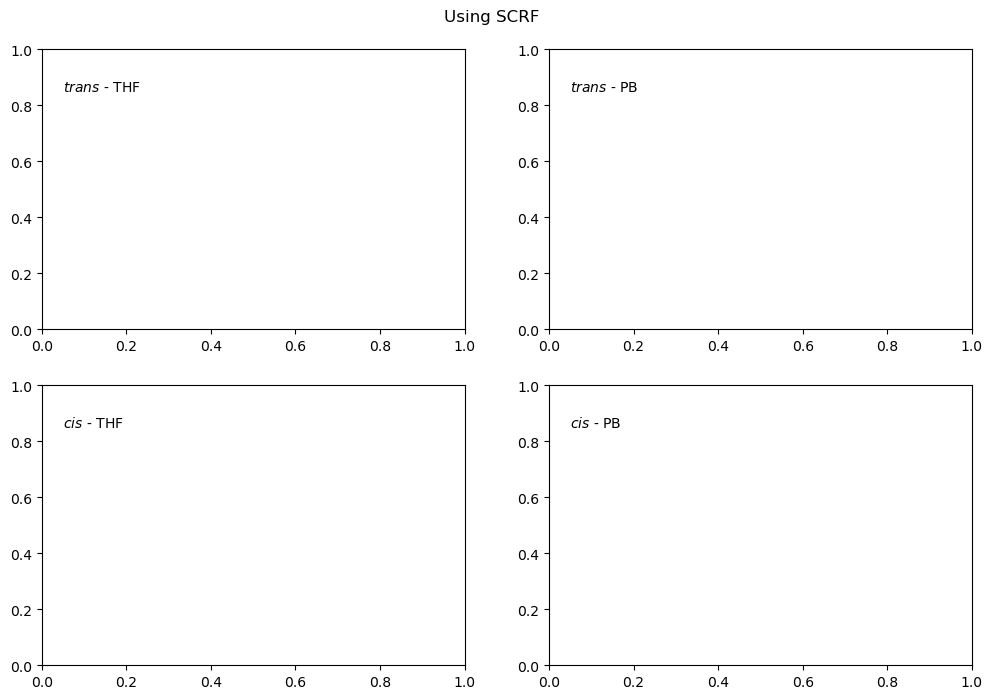

In [39]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))

fig.suptitle("Using SCRF", y=0.93)

for i, iso in enumerate(UVVis):
    for j, sol in enumerate(UVVis[iso]):
        ax[i,j].text(
            0.05, 0.85,
            labels[iso] + " - " + sol,
            transform=ax[i, j].transAxes, ha="left", rotation=0, fontsize=10
        )
        
        
        try:
            data = UVVis[iso][sol]["solvent"].copy()
        except KeyError:
            continue
        
        for n in range(1, 7):
            Sn = f"s{n}"
            Fn = f"f{n}"
            ax[i, j].scatter(data[Sn], data[Fn], label=Sn, s=10.)
            
        # ax[i, j].title("Isomer cis")
        ax[i, j].set_xlabel("wavelenght (nm)")
        ax[i, j].set_ylabel("force oscillator")
        ax[i, j].set_xlim(220, 500)
        ax[i, j].legend()
        
#saveFig("foscillator_time_usingSCRF_5rep.png")

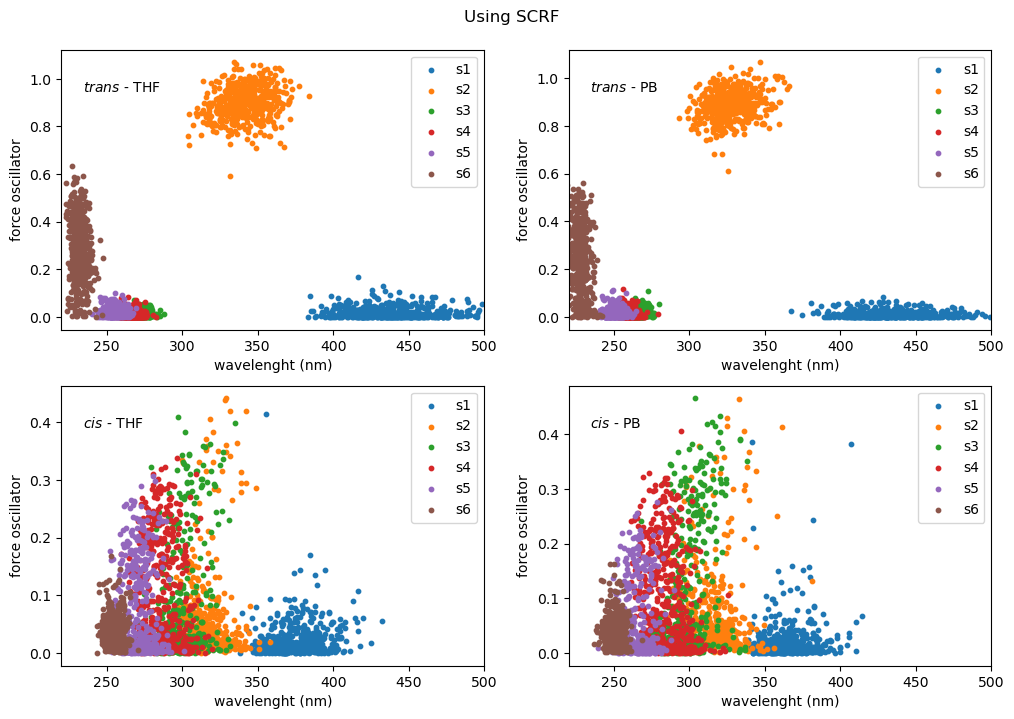

In [52]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))

fig.suptitle("Using SCRF", y=0.93)

for i, iso in enumerate(UVVIS):
    for j, sol in enumerate(UVVIS[iso]):
        ax[i,j].text(
            0.05, 0.85,
            labels[iso] + " - " + sol,
            transform=ax[i, j].transAxes, ha="left", rotation=0, fontsize=10
        )
        
        
        try:
            data = UVVIS[iso][sol]["solvent"].copy()
        except KeyError:
            continue
        
        for n in range(1, 7):
            Sn = f"s{n}"
            Fn = f"f{n}"
            ax[i, j].scatter(data[Sn], data[Fn], label=Sn, s=10.)
            
        # ax[i, j].title("Isomer cis")
        ax[i, j].set_xlabel("wavelenght (nm)")
        ax[i, j].set_ylabel("force oscillator")
        ax[i, j].set_xlim(220, 500)
        ax[i, j].legend()
        
#saveFig("foscillator_time_usingSCRF_5rep.png")

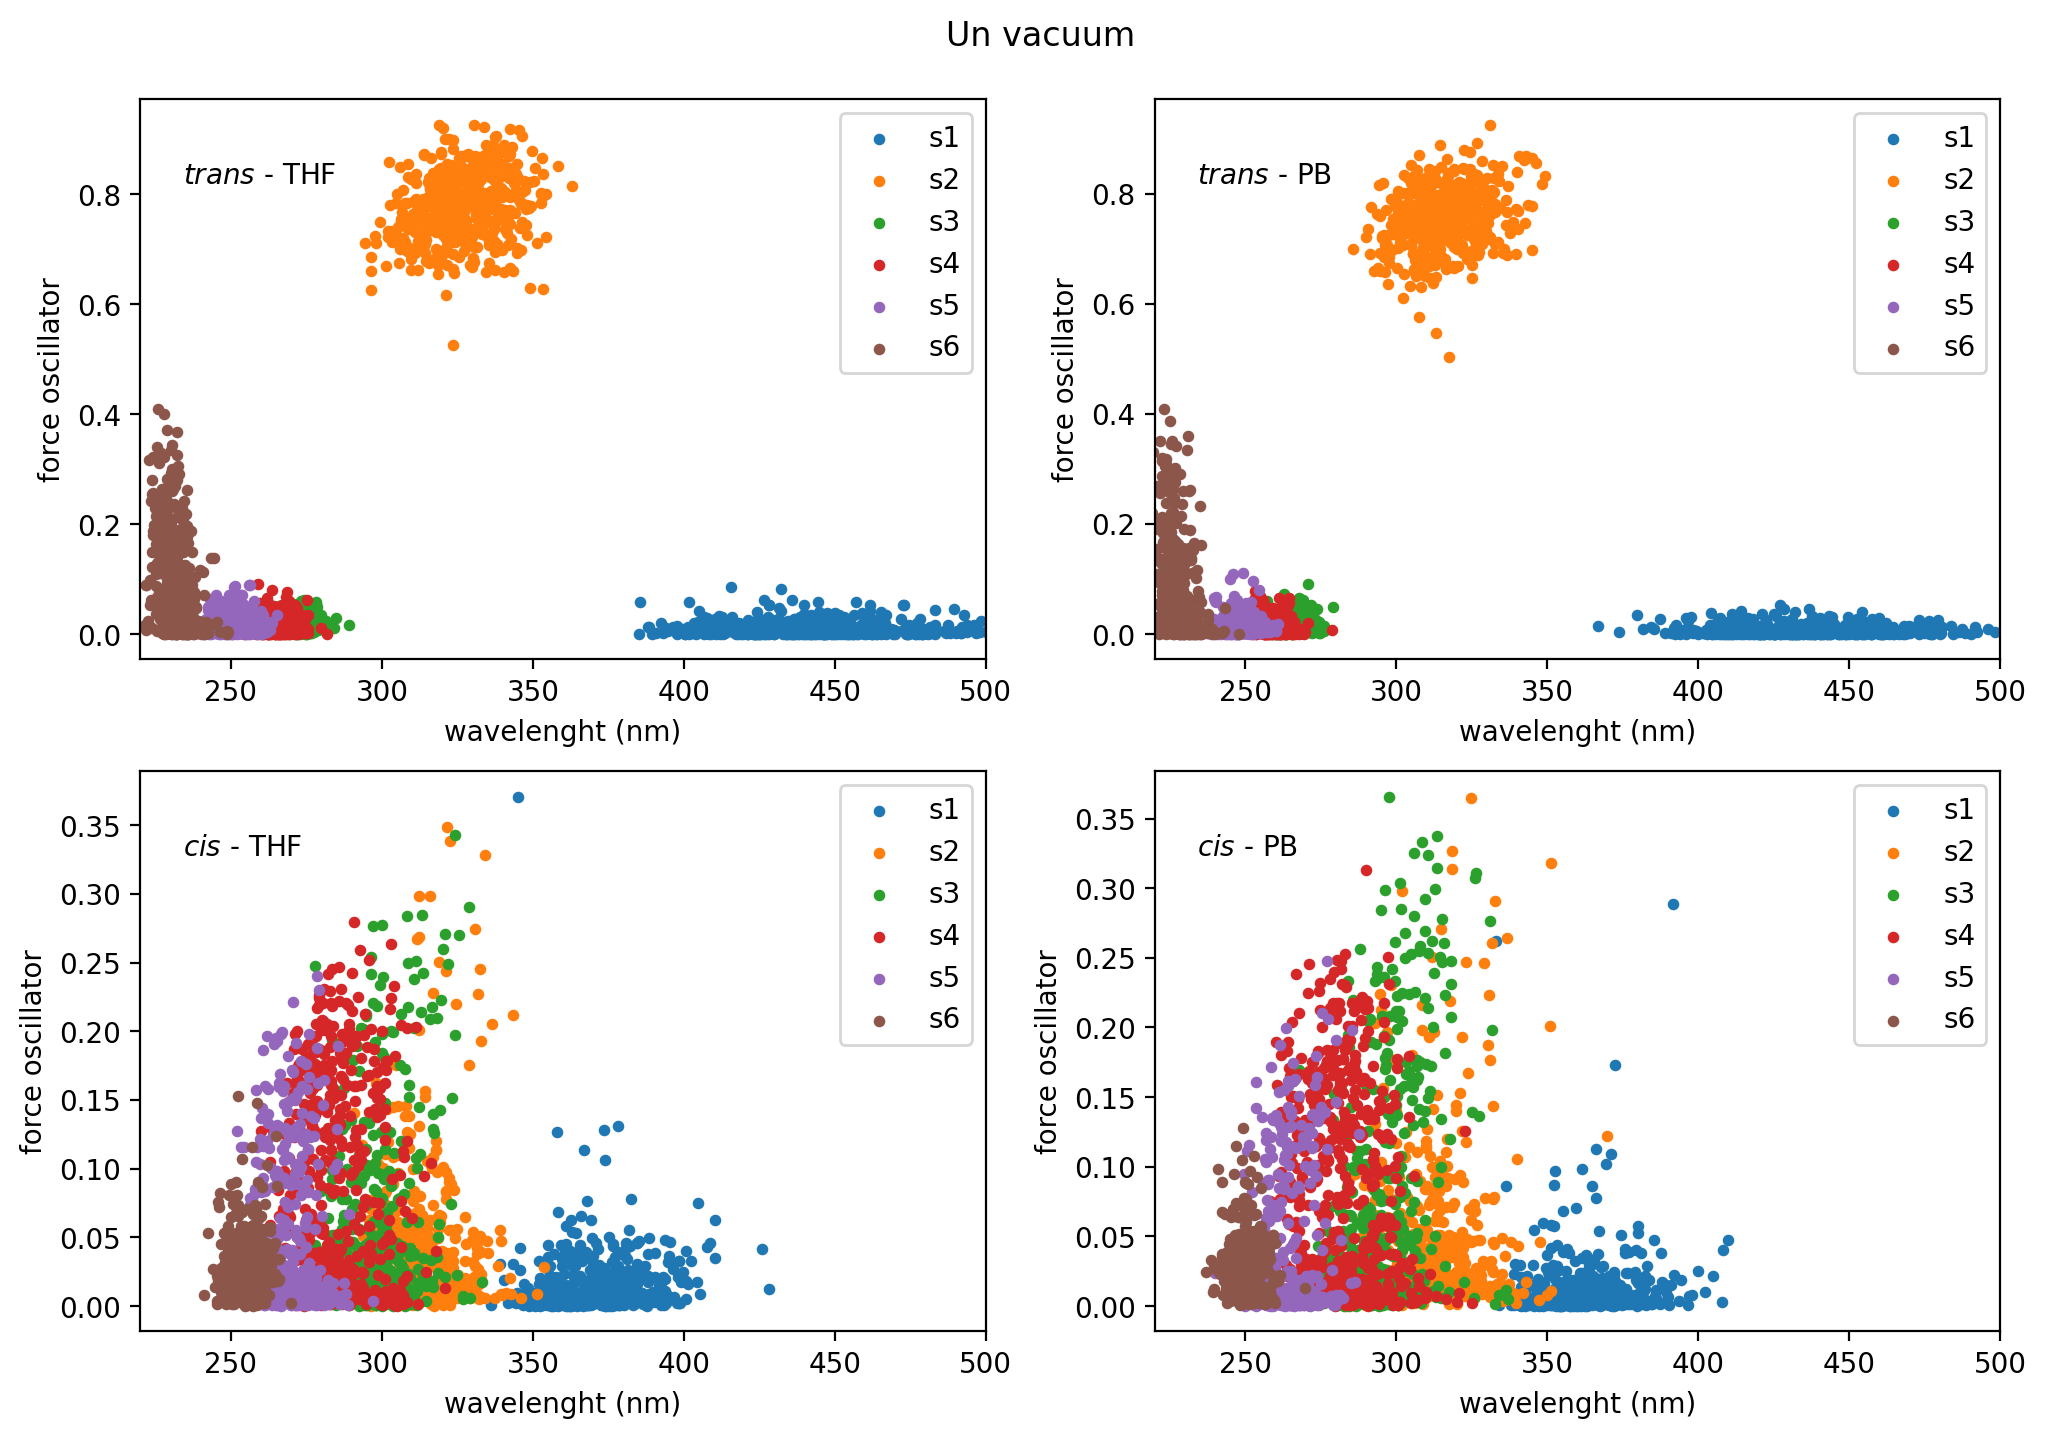

In [55]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), dpi=200.)

fig.suptitle("Un vacuum", y=0.93)

for i, iso in enumerate(UVVIS):
    for j, sol in enumerate(UVVIS[iso]):
        ax[i,j].text(
            0.05, 0.85,
            labels[iso] + " - " + sol,
            transform=ax[i, j].transAxes, ha="left", rotation=0, fontsize=10
        )
        
        
        try:
            data = UVVIS[iso][sol]["vacuum"].copy()
        except KeyError:
            continue
        
        for n in range(1, 7):
            Sn = f"s{n}"
            Fn = f"f{n}"
            ax[i, j].scatter(data[Sn], data[Fn], label=Sn, s=10.)
            
        # ax[i, j].title("Isomer cis")
        ax[i, j].set_xlabel("wavelenght (nm)")
        ax[i, j].set_ylabel("force oscillator")
        ax[i, j].set_xlim(220, 500)
        ax[i, j].legend()
        
# saveFig("foscillator_time_usingSCRF_5rep_vide.png")

In [54]:
Table = {}

for iso in ["trans"]:
    # print(iso)
    for sol in UVVIS[iso]:
        # print(sol)
        # print(UVVisGLOB[iso][sol])
        for env in UVVIS[iso][sol]:
            name = sol + env.replace("solvent","").replace("vacuum"," vac")
            # print(name)
            # print(UVVisGLOB[iso][sol][env]["info"]["s2"].mean())
            # print(UVVisGLOB[iso][sol][env]["info"]["s2"].std())
            # print("")
            Table[name] = {
                "mean": UVVIS[iso][sol][env]["s2"].mean(),
                "std": UVVIS[iso][sol][env]["s2"].std()
            }

Table = pd.DataFrame(Table)
Table.round(2)

THF  THF vac      PB  PB vac
mean  340.60   326.62  327.06  315.70
std    13.97    12.26   12.51   11.13

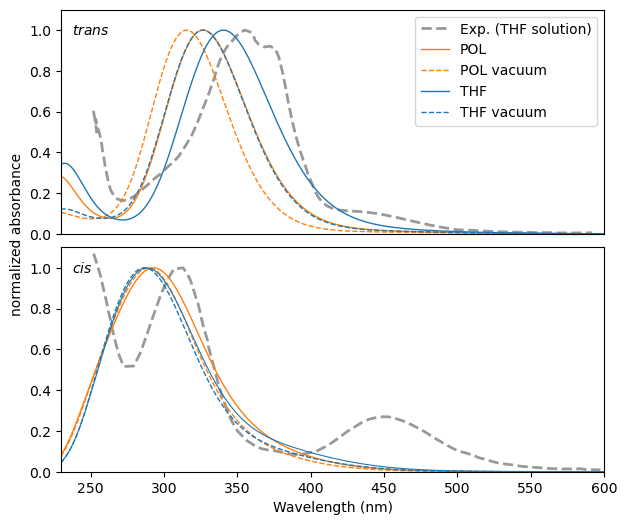

In [67]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 6))
plt.subplots_adjust(hspace=0.06)

#fig.suptitle(
#    "Comparison of the spectra, solution - polymer", fontweight="bold", y=0.95
#)

# CIS
# --- exp
ax[1].plot(
    cis_exp["wl"], cis_exp["abs"]/cis_exp["abs"][cis_exp["wl"] > 300].max(),
    color="k",
    alpha=0.4,
    ls="--",
    lw=2.0,
    label="Exp. (chitosan film)"
)

# --- POL
ax[1].plot(
    nbconfig.w_nm,
    cis_pol_spectra / cis_pol_spectra.max(),
    label="POL",
    color="tab:orange",
    lw=1.,
)

ax[1].plot(
    nbconfig.w_nm,
    cis_pol_spectra_v / cis_pol_spectra_v.max(),
    label="POL vacuum",
    color="tab:orange",
    ls="--",
    lw=1.,
)

# THF
cis_thf_wl = w_nm[np.where(cis_thf_spectra == cis_thf_spectra.max())][0]
ax[1].plot(
    nbconfig.w_nm,
    cis_thf_spectra / cis_thf_spectra.max(),
    label="THF",
    color="tab:blue",
    lw=.8,
)

ax[1].plot(
    nbconfig.w_nm,
    cis_thf_spectra_v / cis_thf_spectra_v.max(),
    label="THF vacuum",
    color="tab:blue",
    ls="--",
    lw=1.,
)

# TRANS
# --- exp
ax[0].plot(
    trans_exp["wl"], trans_exp["abs"]/trans_exp["abs"][trans_exp["wl"] > 300].max(),
    color="k",
    alpha=0.4,
    ls="--",
    lw=2.0,
    label="Exp. (THF solution)"
)

# --- POL
ax[0].plot(
    nbconfig.w_nm,
    trans_pol_spectra / trans_pol_spectra.max(),
    label="POL",
    color="tab:orange",
    lw=1.
)

ax[0].plot(
    nbconfig.w_nm,
    trans_pol_spectra_v / trans_pol_spectra_v.max(),
    label="POL vacuum",
    color="tab:orange",
    ls="--",
    lw=1.
)

# THF
trans_thf_wl = w_nm[np.where(trans_thf_spectra == trans_thf_spectra.max())][0]
ax[0].plot(
    nbconfig.w_nm,
    trans_thf_spectra / trans_thf_spectra.max(),
    label="THF",
    color="tab:blue",
    lw=1.
)

ax[0].plot(
    nbconfig.w_nm,
    trans_thf_spectra_v / trans_thf_spectra_v.max(),
    label="THF vacuum",
    color="tab:blue",
    ls="--",
    lw=1.
)

ax[0].get_xaxis().set_visible(False)
ax[0].set_ylabel("normalized absorbance", y=0.)

isomer = ["trans", "cis"]
for i, a in enumerate(ax):
    a.set_xlim(230,600)
    a.set_ylim(0,1.1)
    a.set_xlabel("Wavelength (nm)")
    # a.xaxis.set_ticks(np.arange(250, 450, 50))
    a.set_title(labels[isomer[i]], horizontalalignment="left", loc="left", fontsize=10, y=0.85, x=.02)

ax[0].legend(loc='upper right') # , bbox_to_anchor=(1, 0.5))
# plt.tight_layout()

# SaveFigPaper.saveFig("UVVIS_comparison_spectreCov.png")
# saveFig("UVVIS_comparison_spectreCov.png")

# saveFig("spectres_5rep.png")

plt.show()

In [101]:
col_exp = []

for iso in ["trans", "cis"]:
    spec_exp = experiments[iso]["abs"]
    w_exp = experiments[iso]["wl"]
    spec_exp /= spec_exp.max()

    col_exp.append(w_exp[spec_exp ==  spec_exp.max()].values[0])

In [102]:
col_exp

[355.1116502534905, 251.98853634370096]

In [106]:
tabUVVis = {}

for iso in ["trans", "cis"]:
    # print(iso)
    tabUVVis[iso] = {}
    for sol in UVVISspect[iso]:
        # print(sol)
        # print(UVVisGLOB[iso][sol])
        for env in UVVISspect[iso][sol]:
            name = sol + env.replace("solvent","").replace("vacuum"," vac")
            # print(name)
            # print(UVVisGLOB[iso][sol][env]["info"]["s2"].mean())
            # print(UVVisGLOB[iso][sol][env]["info"]["s2"].std())
            # print("")
            
            spectre = UVVISspect[iso][sol][env]
            spectre = spectre / spectre.max()
            # print(w_nm[spectre == spectre.max()][0])
            
            tabUVVis[iso][name] = w_nm[spectre == spectre.max()][0]
            ##    "std": UVVisGLOB[iso][sol][env]["info"]["s2"].std()
            ##}
            
            # plt.plot(w_nm, UVVisGLOB[iso][sol][env]["spectre"])

# pd.DataFrame(tabUVVis)
tabUVVis = pd.DataFrame(tabUVVis).T
tabUVVis["Exp"] = col_exp
tabUVVis.round(1)

THF  THF vac     PB  PB vac    Exp
trans  340.5    326.5  326.5   315.5  355.1
cis    288.5    286.5  293.0   289.5  252.0

#### Some geomtries

In [143]:
GEOMs = {}

for sol in ["THF", "PB", "DCN"]:
    tabList = []
    path = ""
    if sol == "PB":
        path += "../exp.azob.stamp.3/trans/6_prod_R/Geometry_mol.csv"
    elif sol == "THF":
        path += "../exp.azob.gmx/azob_trans.thf.densf/mdR/Geometry_mol.csv"
    elif sol == "DCN":
        path += "../exp.azob.gmx/azob_trans.dcn/md/Geometry_mol.csv"
        
        data = read_geometry_file(
            path,
            freq=1.,
            t0=1.
        )
        
        GEOMs[sol] = data
        continue
        
    
    for i in range(4):
        data = read_geometry_file(
            path.replace("R", str(i)),
                freq=1.,
                t0=1.
            )
        # print(data)
        tabList.append(data)
        
    GEOMs[sol] = pd.concat(tabList, ignore_index=True)


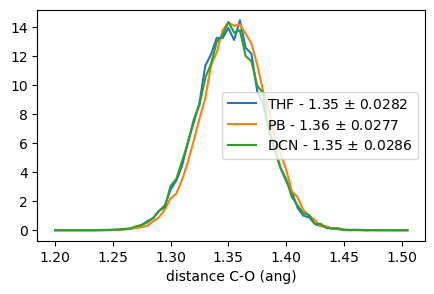

In [144]:
fig, ax = plt.subplots(figsize=(5,3))

for env in GEOMs:
    data = GEOMs[env].copy()
    dco = pd.concat([data["r_co_1"], data["r_co_2"]], ignore_index=True).values
    bins = np.arange(1.2, 1.51, 0.005)
    
    hist, _ = np.histogram(dco, bins=bins, density=True)
    # print(env, dco.mean(), dco.std())
    # 1.354 - 1.343
    ax.plot(
        bins[:-1],
        hist, "-", ms = 3,
        label = "{} - {:.3} $\pm$ {:.3}".format(env,dco.mean(),dco.std()))

ax.legend()
ax.set_xlabel(r"distance C-O (ang)")
# saveFig("dist_trans_d_co.png")
plt.show()

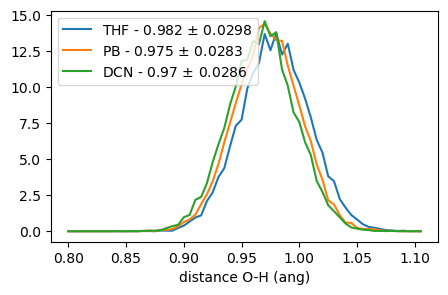

In [145]:
fig, ax = plt.subplots(figsize=(5,3))

for env in GEOMs:
    data = GEOMs[env].copy()
    dco = pd.concat([data["r_oh_1"], data["r_oh_2"]], ignore_index=True).values
    bins = np.arange(.8, 1.11, 0.005)
    
    hist, _ = np.histogram(dco, bins=bins, density=True)
    # print(env, dco.mean(), dco.std())
    # 1.354 - 1.343
    ax.plot(
        bins[:-1],
        hist, "-", ms = 3,
        label = "{} - {:.3} $\pm$ {:.3}".format(env,dco.mean(),dco.std()))

ax.legend()
ax.set_xlabel(r"distance O-H (ang)")
# saveFig("dist_trans_d_oh.png")
plt.show()

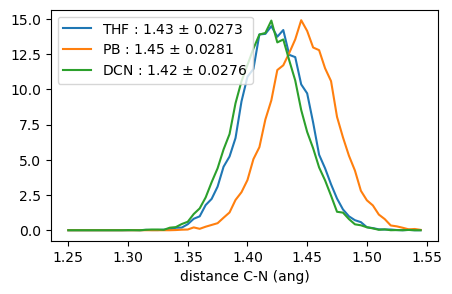

In [146]:
fig, ax = plt.subplots(figsize=(5,3))

for env in GEOMs:
    data = GEOMs[env].copy()
    dco = pd.concat([data["r_cn_1"], data["r_cn_2"]], ignore_index=True).values
    bins = np.arange(1.25, 1.55, 0.005)
    
    hist, _ = np.histogram(dco, bins=bins, density=True)
    # print(env, dco.mean(), dco.std())
    # 1.354 - 1.343
    ax.plot(
        bins[:-1],
        hist, "-", ms = 3,
        label = "{} : {:.3} $\pm$ {:.3}".format(env,dco.mean(),dco.std()))

ax.legend()
ax.set_xlabel(r"distance C-N (ang)")
# saveFig("dist_trans_d_oh.png")
plt.show()

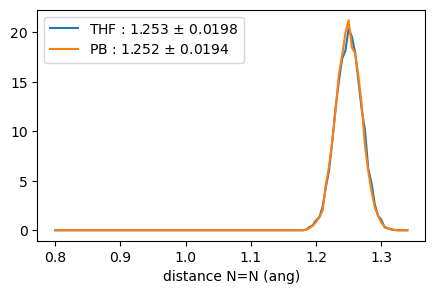

In [225]:
fig, ax = plt.subplots(figsize=(5,3))

for env in GEOMs:
    if env == "DCN":
        continue
    data = GEOMs[env].copy()
    dco = data["r_nn"].values
    bins = np.arange(0.8, 1.35, 0.005)
    
    hist, _ = np.histogram(dco, bins=bins, density=True)
    # print(env, dco.mean(), dco.std())
    # 1.354 - 1.343
    ax.plot(
        bins[:-1],
        hist, "-", ms = 3,
        label = "{} : {:.4} $\pm$ {:.3}".format(env,dco.mean(),dco.std()))

ax.legend()
ax.set_xlabel(r"distance N=N (ang)")
# saveFig("dist_trans_d_oh.png")
plt.show()

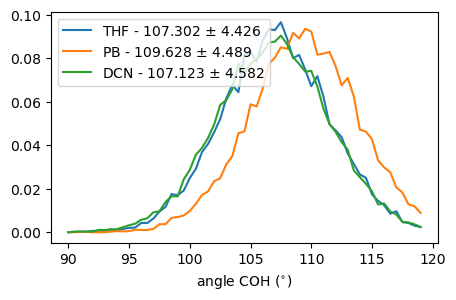

In [148]:
fig, ax = plt.subplots(figsize=(5,3))

for env in GEOMs:
    data = GEOMs[env].copy()
    dco = pd.concat([data["a_coh_1"], data["a_coh_2"]], ignore_index=True).values
    bins = np.arange(90., 120, 0.5)
    
    hist, _ = np.histogram(dco, bins=bins, density=True)
    # print(env, dco.mean(), dco.std())
    # 1.354 - 1.343
    ax.plot(
        bins[:-1],
        hist, "-", ms = 3,
        label = "{} - {:.3f} $\pm$ {:.3f}".format(env,dco.mean(),dco.std()))

ax.legend()
ax.set_xlabel(r"angle COH ($^{\circ}$)")
# saveFig("dist_trans_a_coh.png")
plt.show()

## Impact of the Photochrome on the Polymeric Matrix

### RDF all atoms

In [154]:
RDFS = {
    "POL": {"trans": {}, "cis": {}, "s1": {}},
    "THF": {"cis": {}, "trans": {}, "s1": {}}
}

replicas = ["0", "1", "2", "3", "4"]

for system in RDFS:
    for iso in RDFS[system]:
        for r in replicas: 
            if system == "POL":
                path_file = "{}/{}/6_prod_{}/rdf_all_at_pc_env.csv".format(home_stamp, iso, r)
            elif system == "THF":
                path_file = "{}/azob_{}.thf.densf/md{}/rdf_all_at_pc_env.csv".format(home_gro, iso, r)
            try:
                RDFS[system][iso][r] = pd.read_csv(path_file)
            except FileNotFoundError:
                print("ERROR: File not found")
                print(path_file)

                
                
RDFStot = {}

for sol in RDFS:
    RDFStot[sol] = {}
    for iso in RDFS[sol]:
        RDFStot[sol][iso] = []
        for r in RDFS[sol][iso]:
            RDFStot[sol][iso].append(RDFS[sol][iso][r])
        RDFStot[sol][iso] = pd.DataFrame(np.mean(RDFStot[sol][iso], axis=0), columns=["r", "g_r"])

In [57]:
data = CMSizesGLOB["trans"][" 0 1 2 3 4"]["dprop"].copy()

In [60]:
data["time"].unique()

array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.998e+03, 1.999e+03,
       2.000e+03])

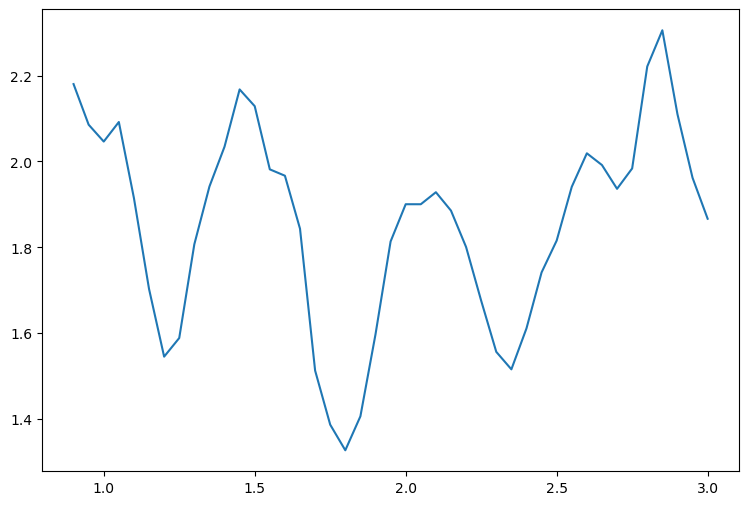

In [52]:
/rdf = CMSizesGLOB["trans"][" 0 1 2 3 4"]["rdf"].copy()

plt.plot(rdf["bin"], rdf["gr"])

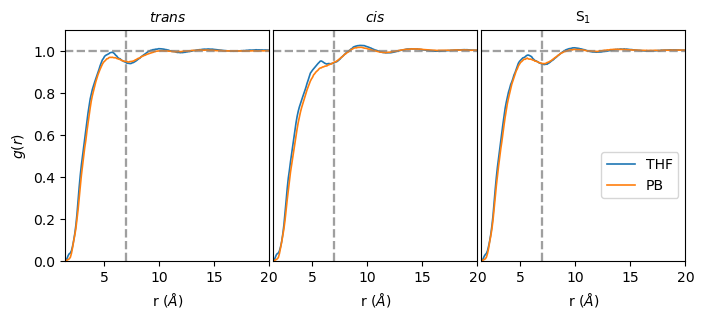

In [155]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,3))
fig.subplots_adjust(hspace=0.05, wspace=0.02)

# fig.suptitle(
#     f"RDFs all atoms",
#     fontweight="bold",
#     fontsize=12,
#     y=1.05,
#     x=0.5,
#     ha = "center"
# )

for i, iso in enumerate(["trans", "cis", "s1"]):
    for sol in ["THF", "POL"]:
        dataM = RDFStot[sol][iso].copy()
        if sol == "POL":
            sol = "PB"
        if iso == "s1":
            ax[i].set_title(r"S$_1$", fontsize=10)
        else:
            ax[i].set_title(r"$%s$" % iso, fontsize=10)
        
        ax[i].plot(dataM["r"], dataM["g_r"], label=f"{sol}", ls="-", lw=1.2)
        
        ax[i].set_xlim(1.5, 20.)
        ax[i].set_ylim(0.0, 1.1)
        ax[i].set_xlabel(r"r ($\AA$)")
        ax[i].set_ylabel(r"$g(r)$")
        ax[i].axvline(x=7., ls="--", color="gray", lw=1.6, alpha=0.5)
        ax[i].axhline(y=1., ls="--", color="gray", lw=1.6, alpha=0.5)
        
        if i > 0:
            # ax[i].set_yticks([])
            ax[i].get_yaxis().set_visible(False)
            
ax[2].legend(fontsize=10, bbox_to_anchor=(1., 0.5))
        
# saveFig("RDFS_all_means.png")
plt.show()

RDF all atoms between photochrome and its environment

### Size and shape analysis

In [24]:
POLPROP = {
    "Rg": {
        "color": "#2a90a6",
        "binwidth": .1,
        "xlim": [0.5, 3.0],
        "label": "Radius of gyration (nm)",
        "units": "nm"
    },
    "dmax": {
        "color": "#5b557b",
        "binwidth": .3,
        "xlim": [1.0, 9.0],
        "label": "Max. distance (nm)",
        "units": "nm"
    },
    "k2": {
        "color": "#fea6ad",
        "binwidth": .05,
        "xlim": [0, 1],
        "label": "Shape anisotropy",
        "units": ""
    },
    "rdf": {
        "color": "#3293f0",
        "xlim": [0.25, 2.5],
        "label": "g(r) PC - POL",
        "units": ""
        
    },
    "distance": {
        "color": "#66c0c0",
        "binwidth": .1,
        "xlim": [0, 4.0],
        "label": "distance",
        "units": "nm"
    }
}

In [25]:
r_azo = ["0", "1", "2", "3", "4"]
SIZES = {"cis": {}, "trans": {}}
ALLSIZES = {"cis": {}, "trans": {}}

for iso in SIZES:
    for r in r_azo:
        path_mol = f"../exp.azob.stamp.3/{iso}/6_prod_{r}"
        dat = pd.read_csv(f"{path_mol}/molprop.csv")
        dat["time"] = dat["frame"].apply(nbconfig.toTime, freq=2.5, t0=502.5)
        dat["Rg"] *= 0.1
        dat["dmax"] *= 0.1
        
        SIZES[iso][r] = dat[dat["idx"] != 0]
        ALLSIZES[iso][r] = dat

        
SIZESM = {"cis": None, "trans": None}

for iso in SIZESM:
    SIZESM[iso] = pd.concat([SIZES[iso][d] for d in SIZES[iso]], ignore_index=True)

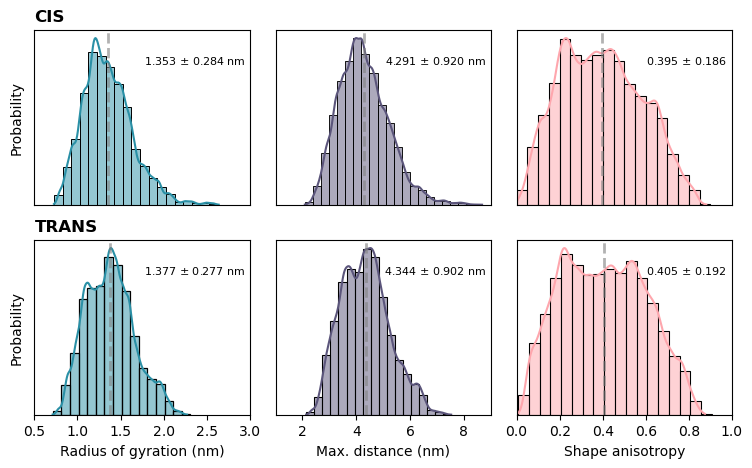

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9,5))

fig.subplots_adjust(hspace=0.2, wspace=0.12)

# fig.suptitle(
#     "Sizes and shape analysis of the polymeric matrix",
#     fontweight="bold",
#     fontsize=15,
#     y=0.95
# )

for i, iso in enumerate(SIZESM):
    ax[i, 0].set_title(iso.upper(), horizontalalignment="left", fontweight="bold", loc="left")
    for j, prop in enumerate(["Rg", "dmax", "k2"]):
        data = SIZESM[iso]
        formProp = POLPROP[prop]
        
        sns.histplot(
            data=data,
            x=prop,
            ax=ax[i, j],
            kde=True,
            color=formProp["color"],
            binwidth=formProp["binwidth"],
            stat="probability",
            alpha=0.5
        )
        
        ax[i, j].set_xlabel(formProp["label"])
        ax[i, j].set_xlim(formProp["xlim"])
        
        ax[i, j].text(
            0.98, 0.8,
            "{:.3f} $\pm$ {:.3f} {}".format(
                data[prop].mean(),
                data[prop].std(),
                formProp["units"]
            ),
            transform=ax[i, j].transAxes, ha="right", rotation=0, fontsize=8
        )
        
        ax[i, j].axvline(x=data[prop].mean(), ls="--", color="gray", lw=2.0, alpha=0.6)
        
        if i != 1:
            ax[i, j].get_xaxis().set_visible(False)
            
        if j == 0:
            ax[i, j].get_yaxis().set_ticks([])
        else:
            ax[i, j].get_yaxis().set_visible(False)

            
# saveFig("sizes_shapes_systems.png")
plt.show()
plt.close()

![](sizes_shapes_all-scatter.png)

Sizes and shape analysis of the polymeric matrix

**NOTA**

Agregar ticks

Colocar en le mismo grafico

Color por systema: trans, cis, s1, pb

NO titulo

Agregar mean y std en la leyenda

Un valor despues de la coma

### CM distance from photochrome

In [61]:
%%time 

CMSizes = {"trans": {}, "cis": {}}
replicas = ["0", "1", "2", "3", "4"]
kwargs_bins = {"rmin":1.0, "rmax":3.05, "binwidth":0.05}

for iso in CMSizes:
    for r in replicas:
        print(f"Isomer {iso} - Replica {r}")
        CMSizes[iso][r] = {}
        path_mol = f"../exp.azob.stamp.3/{iso}/6_prod_{r}"
        
        mol = STAMP(f"{path_mol}/DONNEES.in")
        box_in_frame = mol.box_in_frame
        
        dat = pd.read_csv(f"{path_mol}/molprop.csv")
        dat["time"] = dat["frame"].apply(nbconfig.toTime, freq=1.0, t0=1.0)
        dat["Rg"] *= 0.1
        dat["dmax"] *= 0.1
        
        pol = dat[dat["idx"] != 0].copy()
        dist = get_distances_from_cm(0, dat, box_in_frame)
        
        dprop = pd.DataFrame({
            "distance": dist["distance"].values * 0.1,
            "Rg": pol["Rg"].values,
            "k2": pol["k2"].values,
            "dmax": pol["dmax"].values,
            "time": pol["time"].values,
            "frame": pol["frame"].values
        })

        CMSizes[iso][r]["dprop"] = dprop
        
        box_in_frame[:, 0:3] *= 0.1
        
        rdf = rdf_from_dist(dprop, box_in_frame, rmin=1.0, rmax=3.05, binwidth=0.05, n_mol=72) # rmin=1.0, rmax=3.05, binwidth=0.05
        rdf_bin = rdf.set_index("bin", inplace=False)
        # print(rdf_bin)
        
        dprop_binned = dprop.copy()
        dprop_binned["distance"] = dprop_binned["distance"].apply(nbconfig.binned_distance, **kwargs_bins)
        dprop_binned.dropna(axis=0, inplace=True)
        
        # print(dprop_binned)
        dprop_binned["gr"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "gr"])
        dprop_binned["w"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "weihts"])
        
        CMSizes[iso][r]["rdf"] = rdf
        CMSizes[iso][r]["dbind"] = dprop_binned
        
        print(80 * "=")

print("Finish")

Isomer trans - Replica 0
Reading log file - done in 0.20 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 2.23 s
Number of frames 2000
Isomer trans - Replica 1
Reading log file - done in 0.20 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.92 s
Number of frames 2000
Isomer trans - Replica 2
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.89 s
Number of frames 2000
Isomer trans - Replica 3
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 2.21 s
Number of frames 2000
Isomer trans - Replica 4
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 2.00 s
Number of frames 2000
Isomer cis - Replica 0
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 2.27 s
Number of frames 2000
Isomer cis - Replica 1
Reading log file - done i

In [77]:
%%time 

#RDFGLOB = {}

replicas = ["0", "1", "2", "3", "4"]
isomers = ["trans", "cis"]
CMSizesGLOB = {}
CMSTDCUM = {}


for iso in isomers:
    CMSTDCUM[iso] = {}
    CMSizesGLOB[iso] = {}
    data_list = []
    box_list = []
    isoms = ""
    count_frames = 0
    for r in replicas:
        isoms += " " + r
        print(f"Isomer: {iso} - Replicas: {isoms}")

        CMSizesGLOB[iso][isoms] = {}
        data = CMSizes[iso][r]["dprop"].copy()
        data["bin"] = data["distance"].apply(nbconfig.binned_distance, rmin=.5, rmax=3.05, binwidth=0.05)
        data.dropna(axis=0, inplace=True)
        frames_ndx = list(data["frame"].unique())
        data["frame"] += count_frames
        
        frames = data["frame"].unique()
        print("Numbers of frames:", len(frames), count_frames + len(frames))
        
        # data.drop(columns=["time", "frame"], inplace=True)
        
        data_list.append(data)
        print(len(data_list))
        newData = pd.concat(data_list, ignore_index=True)
        print("Data size:", newData.shape)

        #-------------
        # Calcule
        #-------------
        dfresume = newData.groupby("bin").agg(nbconfig.aggregation)
        dfresume.reset_index(inplace=True)
        # print(dfresume)
        CMSTDCUM[iso][isoms] = dfresume.copy()
        #-------------
        # RDF
        #-------------
        print("rdf")
        path_mol = f"../exp.azob.stamp.3/{iso}/6_prod_{r}"
        mol = STAMP(f"{path_mol}/DONNEES.in", loadConnect=False)
        box_in_frame = mol.box_in_frame[frames_ndx, 0:3]
        box_in_frame[:, 0:3] *= 0.1
        
        box_list.append(box_in_frame)
        newBoxs = np.concatenate(box_list)
        print(newBoxs.shape)
        
        rdf = rdf_from_dist(newData, newBoxs, rmin=.5, rmax=3.05, binwidth=0.05, n_mol=72)
        rdf_bin = rdf.set_index("bin", inplace=False)
        
        dprop_binned = newData.copy()
        dprop_binned["distance"] = dprop_binned["distance"].apply(nbconfig.binned_distance, rmin=.5, rmax=3.05, binwidth=0.05)
        
        dprop_binned.dropna(axis=0, inplace=True)
        
        dprop_binned["gr"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "gr"])
        dprop_binned["w"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "weihts"])
        
        # Save data
        CMSizesGLOB[iso][isoms]["dprop"] = newData
        CMSizesGLOB[iso][isoms]["rdf"] = rdf
        CMSizesGLOB[iso][isoms]["dbinned"] = dprop_binned
        
        count_frames += len(frames)
        
        
        print(80 * "=")
        
    print("")
        
print("Finish!")

Isomer: trans - Replicas:  0
Numbers of frames: 2000 2000
1
Data size: (74311, 7)
rdf
Reading log file - done in 0.20 s
Number of frames 2000
(2000, 3)
Isomer: trans - Replicas:  0 1
Numbers of frames: 2000 4000
2
Data size: (141368, 7)
rdf
Reading log file - done in 0.20 s
Number of frames 2000
(4000, 3)
Isomer: trans - Replicas:  0 1 2
Numbers of frames: 2000 6000
3
Data size: (218113, 7)
rdf
Reading log file - done in 0.20 s
Number of frames 2000
(6000, 3)
Isomer: trans - Replicas:  0 1 2 3
Numbers of frames: 2000 8000
4
Data size: (292139, 7)
rdf
Reading log file - done in 0.61 s
Number of frames 2000
(8000, 3)
Isomer: trans - Replicas:  0 1 2 3 4
Numbers of frames: 2000 10000
5
Data size: (371998, 7)
rdf
Reading log file - done in 0.20 s
Number of frames 2000
(10000, 3)

Isomer: cis - Replicas:  0
Numbers of frames: 2000 2000
1
Data size: (80361, 7)
rdf
Reading log file - done in 0.20 s
Number of frames 2000
(2000, 3)
Isomer: cis - Replicas:  0 1
Numbers of frames: 2000 4000
2
Dat

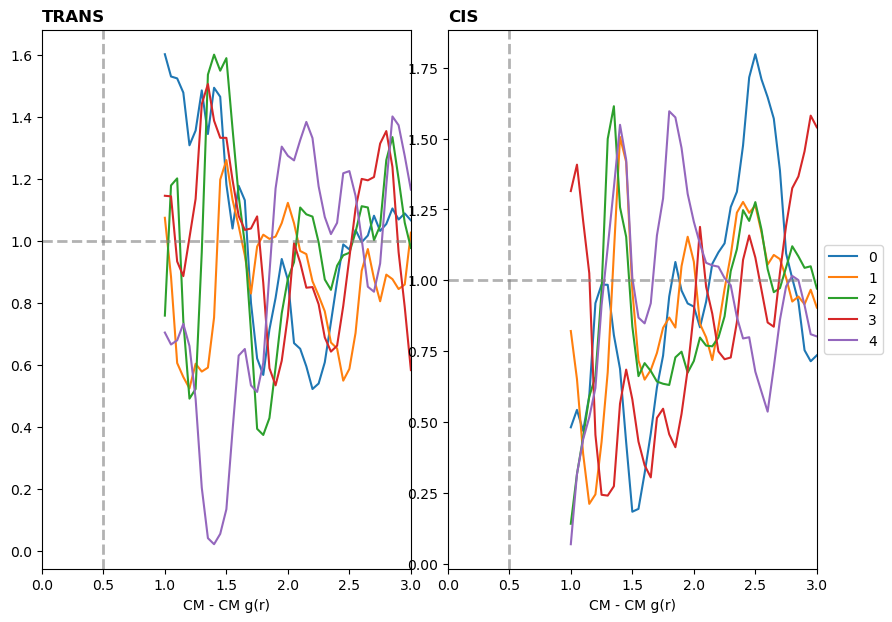

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,7))

fig.subplots_adjust(hspace=0.2, wspace=0.1)

# fig.suptitle(
#     "RDF from closest distance per replica",
#     fontweight="bold",
#     fontsize=15,
#     y=0.95
# )


for j, iso in enumerate(CMSizes):
    ax[j].set_title(iso.upper(), horizontalalignment="left", fontweight="bold", loc="left")

    for i, r in enumerate(CMSizes[iso]):
        rdf = CMSizes[iso][r]["rdf"]
        ax[j].plot(rdf["bin"], rdf["gr"], label=r)

    ax[j].set_xlabel("r (nm)")
    ax[j].set_xlabel("CM - CM g(r)")
    ax[j].set_xlim(0., 3.0)
        
    ax[j].axhline(y=1., ls="--", color="gray", lw=2.0, alpha=0.6)
    ax[j].axvline(x=.5, ls="--", color="gray", lw=2.0, alpha=0.6)
    
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# saveFig("rdf_closest_distance.png")
plt.show()
plt.close()

NOTA

Corregir labels

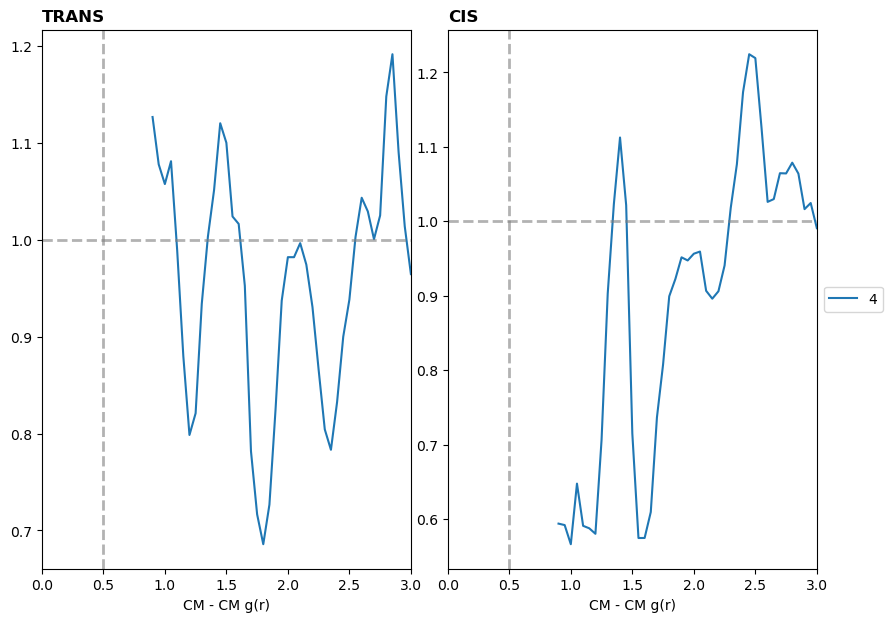

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,7))

fig.subplots_adjust(hspace=0.2, wspace=0.1)

# fig.suptitle(
#     "RDF from closest distance per replica",
#     fontweight="bold",
#     fontsize=15,
#     y=0.95
# )


for j, iso in enumerate(CMSizesGLOB):
    ax[j].set_title(iso.upper(), horizontalalignment="left", fontweight="bold", loc="left")

    #for i, r in enumerate(CMSizesGLOB[iso]):
    #    rdf = CMSizesGLOB[iso][r]["rdf"]
    #    ax[j].plot(rdf["bin"], rdf["gr"], label=r)
    rdf = CMSizesGLOB[iso][" 0 1 2 3 4"]["rdf"]
    ax[j].plot(rdf["bin"], rdf["gr"], label=r)

    ax[j].set_xlabel("r (nm)")
    ax[j].set_xlabel("CM - CM g(r)")
    ax[j].set_xlim(0., 3.0)
        
    ax[j].axhline(y=1., ls="--", color="gray", lw=2.0, alpha=0.6)
    ax[j].axvline(x=.5, ls="--", color="gray", lw=2.0, alpha=0.6)
    
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# saveFig("rdf_closest_distance.png")
plt.show()
plt.close()

<AxesSubplot: >

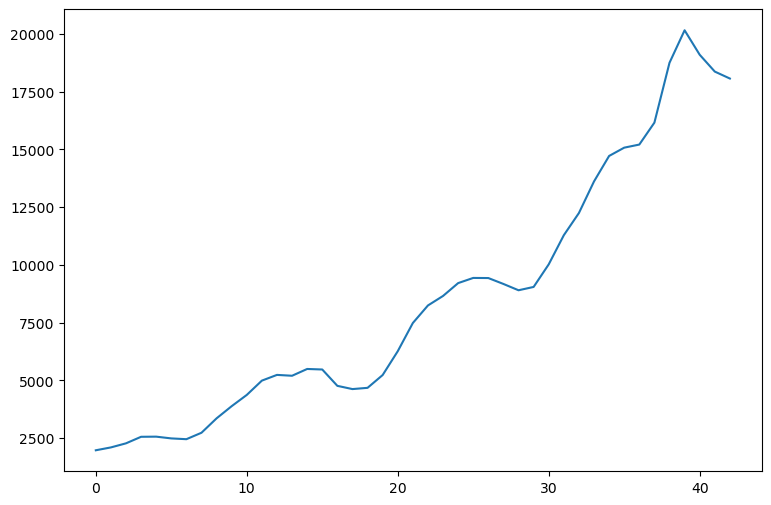

In [67]:
CMSizesGLOB["trans"][" 0 1 2 3 4"]["rdf"]["distance"].plot()

In [68]:
def get_dict_2w4_rdf(df):
    DICT = {}
    for i in df.index:
        DICT[round(df.loc[i, "bin"], 2)] = df.loc[i, "distance"]
    return DICT

In [69]:
dictW = get_dict_2w4_rdf(CMSizesGLOB["trans"][" 0 1 2 3 4"]["rdf"])

In [70]:
for iso in CMSizesGLOB:
    CMSizesGLOB[iso][" 0 1 2 3 4"]["dprop"]["w"] = CMSizesGLOB[iso][" 0 1 2 3 4"]["dprop"]["bin"].apply(lambda x: dictW[round(x, 2)])

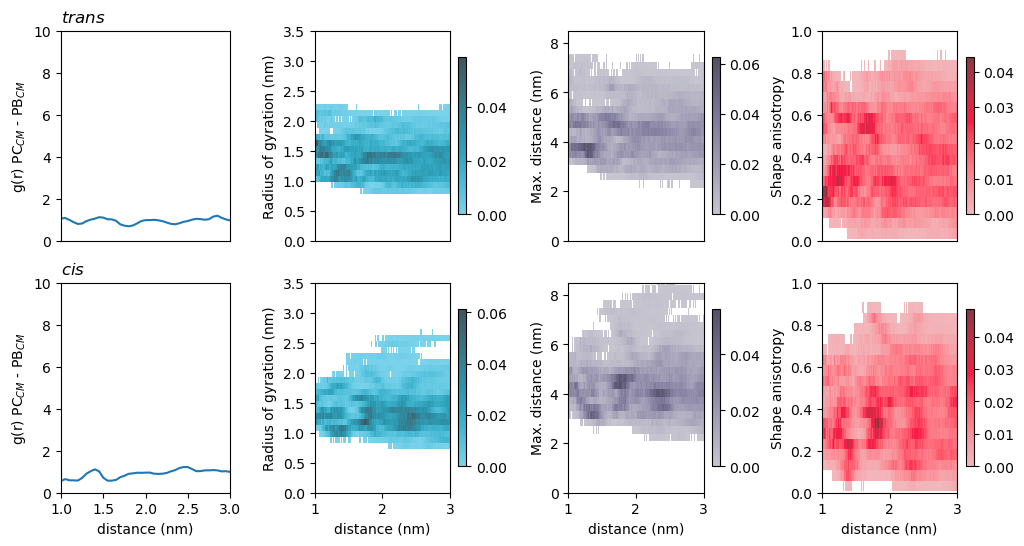

In [71]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,6))

fig.subplots_adjust(hspace=0.2, wspace=0.5)

#fig.suptitle(
#    "Evolution of desviation standard as a function of distance",
#    fontweight="bold",
#    fontsize=15,
#    y=0.97
#)

propLims = {
    "rdf": [0, 10],
    "Rg": [0.0, 3.5],
    "dmax": [0., 8.5],
    "k2": [0.0, 1.]
}

#sns.set_palette("rocket")
for i, iso in enumerate(["trans", "cis"]):
    ax[i, 0].set_title(r"$%s$" % iso, horizontalalignment="left", fontweight="bold", loc="left")  # - Replicas 0 1 2 3 4
    
    # data = STDCUM3[iso][" 0 1 2 3 4"].copy()
    data = CMSizesGLOB[iso][" 0 1 2 3 4"]["dprop"].copy()
    data = data[data["distance"] >= 1.0]
    # data = data[data["bin"] > data["bin"].min() + 0.02]
    rdf = CMSizesGLOB[iso][" 0 1 2 3 4"]["rdf"].copy()
    # data.drop(index=0, inplace=True)
    # print(data)
    
    for j, prop in enumerate(["rdf", "Rg", "dmax", "k2"]):
        formProp = POLPROP2[prop.replace("rdf", "rdf_CM")]
        
        if prop == "rdf":
            ax[i, j].plot(rdf["bin"], rdf["gr"], label=r)
            
        else:
            """
            ax[i, j].errorbar(
                    data["bin"][""],
                    y=data[prop]["mean"],
                    yerr=data[prop]["std"],
                    fmt=".",
                    capsize=4,
                    color="black",
                    ecolor=POLPROP2[prop]["color"],
            )
            """
            plot = sns.histplot(
                    data=data,
                    x="distance",
                    y=prop,
                    weights=1/data["w"],
                    stat="count",
                    ax=ax[i, j],
                    binwidth=[POLPROP2["distance"]["binwidth"], POLPROP2[prop]["binwidth"]],
                    color=POLPROP2[prop]["color"],
                    cbar=True, cbar_kws=dict(shrink=.75)
                )
            
            # Set the color bar limits
            #cbar_limits = (0, 0.3)  # Change these values to your desired limits
            # plot.collections[0].colorbar.set_ticks([0, 0.1, 0.2, 0.3])  # Optional: Set custom tick values
            # plot.collections[0].colorbar.set_clim(*cbar_limits)


        ax[i, j].set_ylabel(formProp["label"])
        ax[i, j].set_xlabel("distance (nm)")
        ax[i, j].set_xlim(1., 3.)
        ax[i, j].set_ylim(propLims[prop])
        
        if i == 0:
            ax[i, j].get_xaxis().set_visible(False)
                
#ax[0, 2].legend(loc='center left', bbox_to_anchor=(1, 0.))

# saveFig("sumReps_meansVals_closest_distance.png")
#saveFig("PB_dist_prop_map.png")
plt.show()
plt.close()

<AxesSubplot: xlabel='distance', ylabel='Rg'>

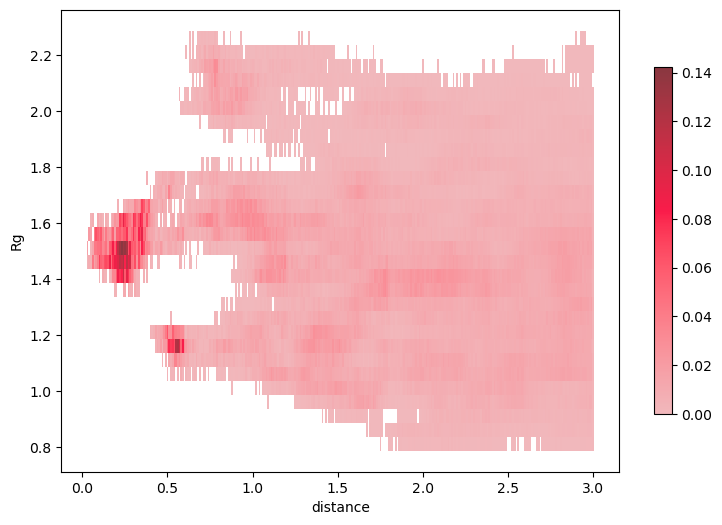

In [214]:
data = CMSizesGLOB["trans"][" 0 1 2 3 4"]["dprop"]

sns.histplot(
             data=data,
             x="distance",
             y="Rg",
             weights=1/data["w"],
             stat="count",
             binwidth=[POLPROP2["distance"]["binwidth"], POLPROP2[prop]["binwidth"]],
             color=POLPROP2[prop]["color"],
             cbar=True, cbar_kws=dict(shrink=.75)
         )

In [ ]:
# Crea una figura y ejes
fig, ax = plt.subplots()

# Crea un histplot y especifica el eje de la barra de colores
plot = sns.histplot(data=data, x="flipper_length_mm", y="bill_length_mm", cbar=True, cbar_ax=ax)

# Establece los límites de la barra de colores
cbar_limits = (0, 100)  # Cambia estos valores según tus límites deseados
plot.collections[0].colorbar.set_ticks([0, 25, 50, 75, 100])  # Opcional: Define valores de marcas personalizados
plot.collections[0].colorbar.set_clim(*cbar_limits)

# Muestra el gráfico
plt.show()


In [88]:
np

<module 'numpy' from '/home/ovillegas/.anaconda3/envs/SimMOL/lib/python3.10/site-packages/numpy/__init__.py'>

### Closest distance from photochrome

In [28]:
%%time

r_azo = ["0", "1", "2", "3", "4"]
DISTCLOSE = {"cis": {}, "trans": {}}
kwargs_bin_CD = {"rmin": 0.0, "rmax": 3.05, "binwidth": 0.05}


for iso in DISTCLOSE:
    for r in r_azo:
        print(f"Isomer {iso} - Replica {r}")
        DISTCLOSE[iso][r] = {}
        path_mol = f"../exp.azob.stamp.3/{iso}/6_prod_{r}"
        
        dist = pd.read_csv(f"{path_mol}/closest_d_To_0.csv")
        dist["distance"] *= 0.1
        
        dat = pd.read_csv(f"{path_mol}/molprop.csv")
        dat["time"] = dat["frame"].apply(nbconfig.toTime, freq=2.5, t0=502.5)
        dat["Rg"] *= 0.1
        dat["dmax"] *= 0.1
        
        pol = dat[dat["idx"] != 0].copy()
        
        dprop = pd.DataFrame({
            "distance": dist["distance"].values,
            "Rg": pol["Rg"].values,
            "k2": pol["k2"].values,
            "dmax": pol["dmax"].values,
            "time": pol["time"].values,
            "frame": pol["frame"].values
        })
        
        DISTCLOSE[iso][r]["dprop"] = dprop
        
        mol = STAMP(f"{path_mol}/DONNEES.in")
        box_in_frame = mol.box_in_frame
        
        box_in_frame[:, 0:3] *= 0.1
        
        rdf = rdf_from_dist(dprop, box_in_frame, **kwargs_bin_CD)
        rdf_bin = rdf.set_index("bin", inplace=False)
        
        dprop_binned = dprop.copy()
        dprop_binned["distance"] = dprop_binned["distance"].apply(nbconfig.binned_distance, **kwargs_bin_CD)
        
        dprop_binned.dropna(axis=0, inplace=True)
        
        dprop_binned["gr"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "gr"])
        dprop_binned["w"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "weihts"])
        
        
        DISTCLOSE[iso][r]["rdf"] = rdf
        DISTCLOSE[iso][r]["dbind"] = dprop_binned
        print(80 * "=")

print("Finish!")

Isomer cis - Replica 0
Reading log file - done in 0.20 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.94 s
Number of frames 2000
Isomer cis - Replica 1
Reading log file - done in 0.20 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 2.09 s
Number of frames 2000
Isomer cis - Replica 2
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.93 s
Number of frames 2000
Isomer cis - Replica 3
Reading log file - done in 0.20 s
Reading fatomes file - done in 0.35 s
Searching connectivity - done in 1.91 s
Number of frames 2000
Isomer cis - Replica 4
Reading log file - done in 0.20 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 2.08 s
Number of frames 2000
Isomer trans - Replica 0
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.92 s
Number of frames 2000
Isomer trans - Replica 1
Reading log file - done in 0.19

In [29]:
%%time

STDCUM2 = {}
RDFGLOB2 = {}
kwargs_bin_CD = {"rmin": 0.0, "rmax": 3.05, "binwidth": 0.05}

for iso in DISTCLOSE:
    STDCUM2[iso] = {}
    RDFGLOB2[iso] = {}
    data_list = []
    box_list = []
    isoms = ""
    count_frames = 0
    for r in DISTCLOSE[iso]:
        isoms += " " + r
        print(f"Isomer: {iso} - Replicas: {isoms}")
        RDFGLOB2[iso][isoms] = {}
        data = DISTCLOSE[iso][r]["dprop"].copy()
        data["bin"] = data["distance"].apply(nbconfig.binned_distance, **kwargs_bin_CD)
        data.dropna(axis=0, inplace=True)
        frames_ndx = list(data["frame"].unique())
        data["frame"] += count_frames
        
        frames = data["frame"].unique()
        print("Numbers of frames:", len(frames), count_frames + len(frames))
        
        # data.drop(columns=["time", "frame"], inplace=True)
        
        data_list.append(data)
        print(len(data_list))
        newData = pd.concat(data_list, ignore_index=True)
        print("Data size:", newData.shape)
                
        #-------------
        # Calcule
        #-------------
        dfresume = newData.groupby("bin").agg(nbconfig.aggregation)
        dfresume.reset_index(inplace=True)
        # print(dfresume)
        STDCUM2[iso][isoms] = dfresume.copy()
        #-------------
        # RDF
        #-------------
        print("rdf")
        path_mol = f"../exp.azob.stamp.3/{iso}/6_prod_{r}"
        mol = STAMP(f"{path_mol}/DONNEES.in", loadConnect=False)
        box_in_frame = mol.box_in_frame[frames_ndx, 0:3]
        box_in_frame[:, 0:3] *= 0.1
        
        box_list.append(box_in_frame)
        newBoxs = np.concatenate(box_list)
        print(newBoxs.shape)
        
        rdf = rdf_from_dist(newData, newBoxs, **kwargs_bin_CD)
        rdf_bin = rdf.set_index("bin", inplace=False)
        
        dprop_binned = newData.copy()
        dprop_binned["distance"] = dprop_binned["distance"].apply(nbconfig.binned_distance, **kwargs_bin_CD)
        
        dprop_binned.dropna(axis=0, inplace=True)
        
        dprop_binned["gr"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "gr"])
        dprop_binned["w"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "weihts"])
        
        RDFGLOB2[iso][isoms]["dprop"] = newData
        RDFGLOB2[iso][isoms]["rdf"] = rdf
        RDFGLOB2[iso][isoms]["dbinned"] = dprop_binned
        
        count_frames += len(frames)
        
        
        print(80 * "=")
        
    print("")
        
print("Finish!")

Isomer: cis - Replicas:  0
Numbers of frames: 2000 2000
1
Data size: (143628, 7)
rdf
Reading log file - done in 0.20 s
Number of frames 2000
(2000, 3)
Isomer: cis - Replicas:  0 1
Numbers of frames: 2000 4000
2
Data size: (286554, 7)
rdf
Reading log file - done in 0.20 s
Number of frames 2000
(4000, 3)
Isomer: cis - Replicas:  0 1 2
Numbers of frames: 2000 6000
3
Data size: (429241, 7)
rdf
Reading log file - done in 0.20 s
Number of frames 2000
(6000, 3)
Isomer: cis - Replicas:  0 1 2 3
Numbers of frames: 2000 8000
4
Data size: (573220, 7)
rdf
Reading log file - done in 0.20 s
Number of frames 2000
(8000, 3)
Isomer: cis - Replicas:  0 1 2 3 4
Numbers of frames: 2000 10000
5
Data size: (714929, 7)
rdf
Reading log file - done in 0.20 s
Number of frames 2000
(10000, 3)

Isomer: trans - Replicas:  0
Numbers of frames: 2000 2000
1
Data size: (143295, 7)
rdf
Reading log file - done in 0.20 s
Number of frames 2000
(2000, 3)
Isomer: trans - Replicas:  0 1
Numbers of frames: 2000 4000
2
Data si

In [48]:
def get_dict2w(df):
    DICT = {}
    for i in df.index:
        DICT[round(df.loc[i, "bin"], 2)] = df.loc[i, "distance"]
    return DICT

In [50]:
for iso in RDFGLOB2:
    RDFGLOB2[iso][" 0 1 2 3 4"]["dprop"]["w"] = RDFGLOB2[iso][" 0 1 2 3 4"]["dprop"]["bin"].apply(lambda x: dictW[round(x, 2)])

In [49]:
dictW = get_dict2w(RDFGLOB2["trans"][" 0 1 2 3 4"]["rdf"])

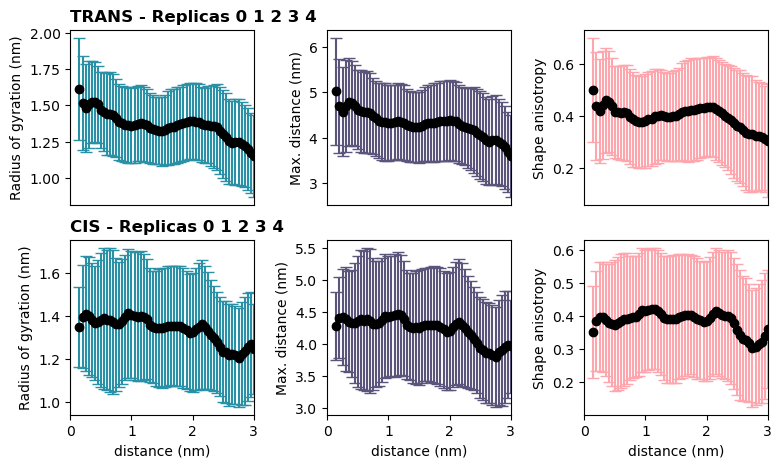

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9,5))

fig.subplots_adjust(hspace=0.2, wspace=0.4)

#fig.suptitle(
#    "Evolution of desviation standard as a function of distance",
#    fontweight="bold",
#    fontsize=15,
#    y=0.97
#)

for i, iso in enumerate(["trans", "cis"]):
    ax[i, 0].set_title(iso.upper() + " - Replicas 0 1 2 3 4", horizontalalignment="left", fontweight="bold", loc="left")
    
    data = STDCUM2[iso][" 0 1 2 3 4"].copy()
    for j, prop in enumerate(["Rg", "dmax", "k2"]):
        formProp = POLPROP[prop]
            
        ax[i, j].errorbar(
                    data["bin"][""],
                    y=data[prop]["mean"],
                    yerr=data[prop]["std"],
                    fmt="o",
                    capsize=4,
                    color="black",
                    ecolor=POLPROP[prop]["color"],
            )


        ax[i, j].set_ylabel(formProp["label"])
        ax[i, j].set_xlabel("distance (nm)")
        ax[i, j].set_xlim(0, 3)
        # ax[i, j].set_ylim(ymin=0)
        
        if i == 0:
            ax[i, j].get_xaxis().set_visible(False)
                
#ax[0, 2].legend(loc='center left', bbox_to_anchor=(1, 0.))

# saveFig("sumReps_meansVals_closest_distance.png")
plt.show()
plt.close()

Evolution of polymer properties as a function of distance

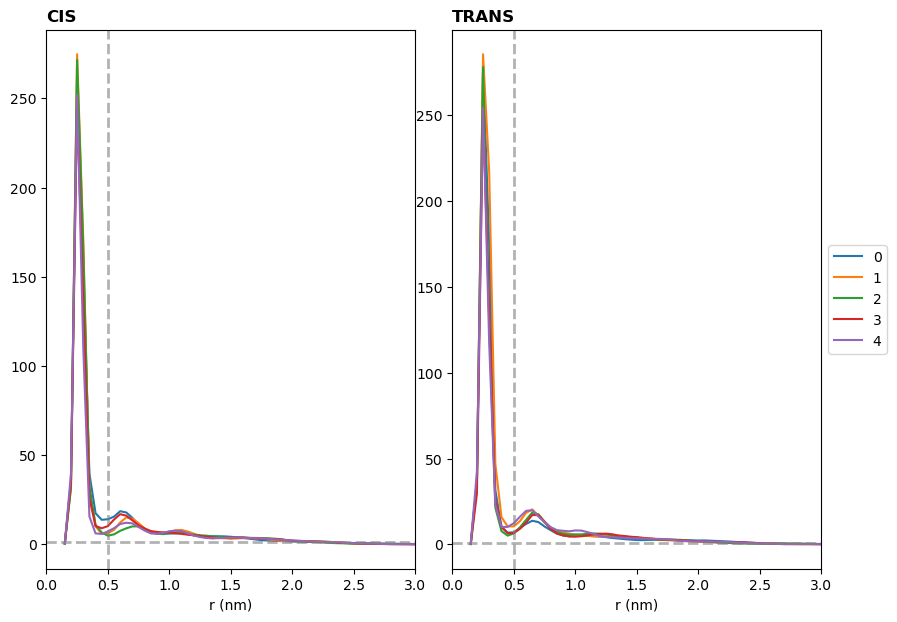

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,7))

fig.subplots_adjust(hspace=0.2, wspace=0.1)

# fig.suptitle(
#     "RDF from closest distance per replica",
#     fontweight="bold",
#     fontsize=15,
#     y=0.95
# )


for j, iso in enumerate(DISTCLOSE):
    ax[j].set_title(iso.upper(), horizontalalignment="left", fontweight="bold", loc="left")

    for i, r in enumerate(DISTCLOSE[iso]):
        rdf = DISTCLOSE[iso][r]["rdf"]
        ax[j].plot(rdf["bin"], rdf["gr"], label=r)

    ax[j].set_xlabel("r (nm)")
    ax[j].set_xlim(0., 3.0)
        
    ax[j].axhline(y=1., ls="--", color="gray", lw=2.0, alpha=0.6)
    ax[j].axvline(x=.5, ls="--", color="gray", lw=2.0, alpha=0.6)
    
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# saveFig("rdf_closest_distance.png")
plt.show()
plt.close()

RDF from closest distance per replica

**NOTA**

SI

revisar formato

In [33]:
%%time

r_azo = ["0", "1", "2", "3", "4"]
DISTCLOSE2 = {"cis": {}, "trans": {}}
kwargs_bin_CD = {"rmin": 0.0, "rmax": 3.05, "binwidth": 0.05}


for iso in DISTCLOSE2:
    for r in r_azo:
        print(f"Isomer {iso} - Replica {r}")
        DISTCLOSE2[iso][r] = {}
        path_mol = f"../exp.azob.stamp.3/{iso}/6_prod_{r}"
        
        dist = pd.read_csv(f"{path_mol}/closest_d_To_0.csv")
        dist["distance"] *= 0.1
        
        dat = pd.read_csv(f"{path_mol}/molprop.csv")
        dat["time"] = dat["frame"].apply(nbconfig.toTime, freq=2.5, t0=502.5)
        dat["Rg"] *= 0.1
        dat["dmax"] *= 0.1
        
        pol = dat[dat["idx"] != 0].copy()
        
        dprop = pd.DataFrame({
            "distance": dist["distance"].values,
            "Rg": pol["Rg"].values,
            "k2": pol["k2"].values,
            "dmax": pol["dmax"].values,
            "time": pol["time"].values,
            "frame": pol["frame"].values
        })
        
        # print(dprop)
        DISTCLOSE2[iso][r]["dprop"] = dprop
        
        mol = STAMP(f"{path_mol}/DONNEES.in")
        box_in_frame = mol.box_in_frame
        
        box_in_frame[:, 0:3] *= 0.1
        
        rdf = rdf_from_dist(dprop, box_in_frame, **kwargs_bin_CD)
        rdf_bin = rdf.set_index("bin", inplace=False)
        
        dprop_binned = dprop.copy()
        dprop_binned["distance"] = dprop_binned["distance"].apply(nbconfig.binned_distance, **kwargs_bin_CD)
        
        dprop_binned.dropna(axis=0, inplace=True)
        
        dprop_binned["gr"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "gr"])
        dprop_binned["w"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "weihts"])
        
        
        DISTCLOSE2[iso][r]["rdf"] = rdf
        DISTCLOSE2[iso][r]["dbind"] = dprop_binned
        print(80 * "=")

print("Finish!")

Isomer cis - Replica 0
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 2.06 s
Number of frames 2000
Isomer cis - Replica 1
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.90 s
Number of frames 2000
Isomer cis - Replica 2
Reading log file - done in 0.18 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 2.13 s
Number of frames 2000
Isomer cis - Replica 3
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.91 s
Number of frames 2000
Isomer cis - Replica 4
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 2.18 s
Number of frames 2000
Isomer trans - Replica 0
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.91 s
Number of frames 2000
Isomer trans - Replica 1
Reading log file - done in 0.19

In [34]:
%%time

STDCUM3 = {}
RDFGLOB3 = {}
kwargs_bin_CD = {"rmin": 0.0, "rmax": 3.05, "binwidth": 0.05}

for iso in DISTCLOSE2:
    STDCUM3[iso] = {}
    RDFGLOB3[iso] = {}
    data_list = []
    box_list = []
    isoms = ""
    count_frames = 0
    for r in DISTCLOSE2[iso]:
        isoms += " " + r
        print(f"Isomer: {iso} - Replicas: {isoms}")
        RDFGLOB3[iso][isoms] = {}
        data = DISTCLOSE2[iso][r]["dprop"].copy()
        data["bin"] = data["distance"].apply(nbconfig.binned_distance, **kwargs_bin_CD)
        data.dropna(axis=0, inplace=True)
        frames_ndx = list(data["frame"].unique())
        data["frame"] += count_frames
        
        frames = data["frame"].unique()
        print("Numbers of frames:", len(frames), count_frames + len(frames))
        
        # data.drop(columns=["time", "frame"], inplace=True)
        
        data_list.append(data)
        print(len(data_list))
        newData = pd.concat(data_list, ignore_index=True)
        print("Data size:", newData.shape)
                
        #-------------
        # Calcule
        #-------------
        dfresume = newData.groupby("bin").agg(nbconfig.aggregation)
        dfresume.reset_index(inplace=True)
        # print(dfresume)
        STDCUM3[iso][isoms] = dfresume.copy()
        #-------------
        # RDF
        #-------------
        print("rdf")
        path_mol = f"../exp.azob.stamp.3/{iso}/6_prod_{r}"
        mol = STAMP(f"{path_mol}/DONNEES.in", loadConnect=False)
        box_in_frame = mol.box_in_frame[frames_ndx, 0:3]
        box_in_frame[:, 0:3] *= 0.1
        
        box_list.append(box_in_frame)
        newBoxs = np.concatenate(box_list)
        print(newBoxs.shape)
        
        rdf = rdf_from_dist(newData, newBoxs, **kwargs_bin_CD)
        rdf_bin = rdf.set_index("bin", inplace=False)
        
        dprop_binned = newData.copy()
        dprop_binned["distance"] = dprop_binned["distance"].apply(nbconfig.binned_distance, **kwargs_bin_CD)
        
        dprop_binned.dropna(axis=0, inplace=True)
        
        dprop_binned["gr"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "gr"])
        dprop_binned["w"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "weihts"])
        
        RDFGLOB3[iso][isoms]["dprop"] = newData
        RDFGLOB3[iso][isoms]["rdf"] = rdf
        RDFGLOB3[iso][isoms]["dbinned"] = dprop_binned
        
        count_frames += len(frames)
        
        
        print(80 * "=")
        
    print("")
        
print("Finish!")

Isomer: cis - Replicas:  0
Numbers of frames: 2000 2000
1
Data size: (143628, 7)
rdf
Reading log file - done in 0.19 s
Number of frames 2000
(2000, 3)
Isomer: cis - Replicas:  0 1
Numbers of frames: 2000 4000
2
Data size: (286554, 7)
rdf
Reading log file - done in 0.20 s
Number of frames 2000
(4000, 3)
Isomer: cis - Replicas:  0 1 2
Numbers of frames: 2000 6000
3
Data size: (429241, 7)
rdf
Reading log file - done in 0.20 s
Number of frames 2000
(6000, 3)
Isomer: cis - Replicas:  0 1 2 3
Numbers of frames: 2000 8000
4
Data size: (573220, 7)
rdf
Reading log file - done in 0.20 s
Number of frames 2000
(8000, 3)
Isomer: cis - Replicas:  0 1 2 3 4
Numbers of frames: 2000 10000
5
Data size: (714929, 7)
rdf
Reading log file - done in 0.20 s
Number of frames 2000
(10000, 3)

Isomer: trans - Replicas:  0
Numbers of frames: 2000 2000
1
Data size: (143295, 7)
rdf
Reading log file - done in 0.20 s
Number of frames 2000
(2000, 3)
Isomer: trans - Replicas:  0 1
Numbers of frames: 2000 4000
2
Data si

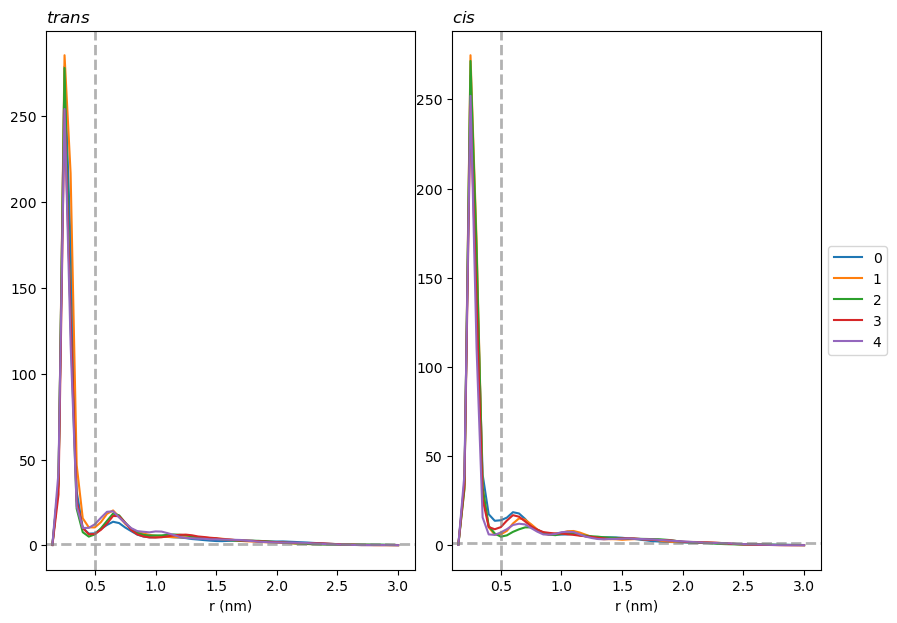

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,7))

fig.subplots_adjust(hspace=0.2, wspace=0.1)

# fig.suptitle(
#     "RDF from closest distance per replica",
#     fontweight="bold",
#     fontsize=15,
#     y=0.95
# )


for j, iso in enumerate(["trans", "cis"]):
    ax[j].set_title(labels[iso], horizontalalignment="left", fontweight="bold", loc="left")

    for i, r in enumerate(DISTCLOSE2[iso]):
        rdf = DISTCLOSE2[iso][r]["rdf"]
        ax[j].plot(rdf["bin"], rdf["gr"], label=r)

    ax[j].set_xlabel("r (nm)")
    # ax[j].set_xlim(0.1, .6)
    ax[j].set_xlim(xmin=0.1)
        
    ax[j].axhline(y=1., ls="--", color="gray", lw=2.0, alpha=0.6)
    ax[j].axvline(x=.5, ls="--", color="gray", lw=2.0, alpha=0.6)
    
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# saveFig("rdf_closest_distance.png")
plt.show()
plt.close()

Closest distance RDF constructed with a maximum distance of 1.0 nm and a bin width of 0.01 nm

<AxesSubplot: >

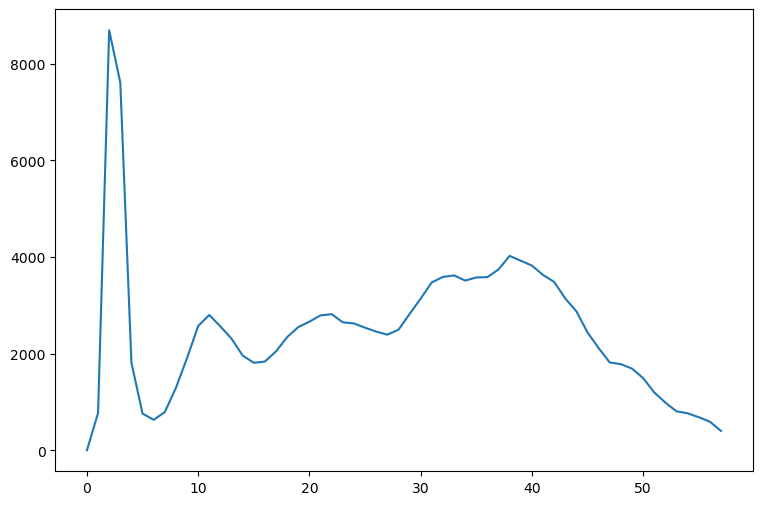

In [36]:
DISTCLOSE2["trans"]["0"]["rdf"]["distance"].plot()

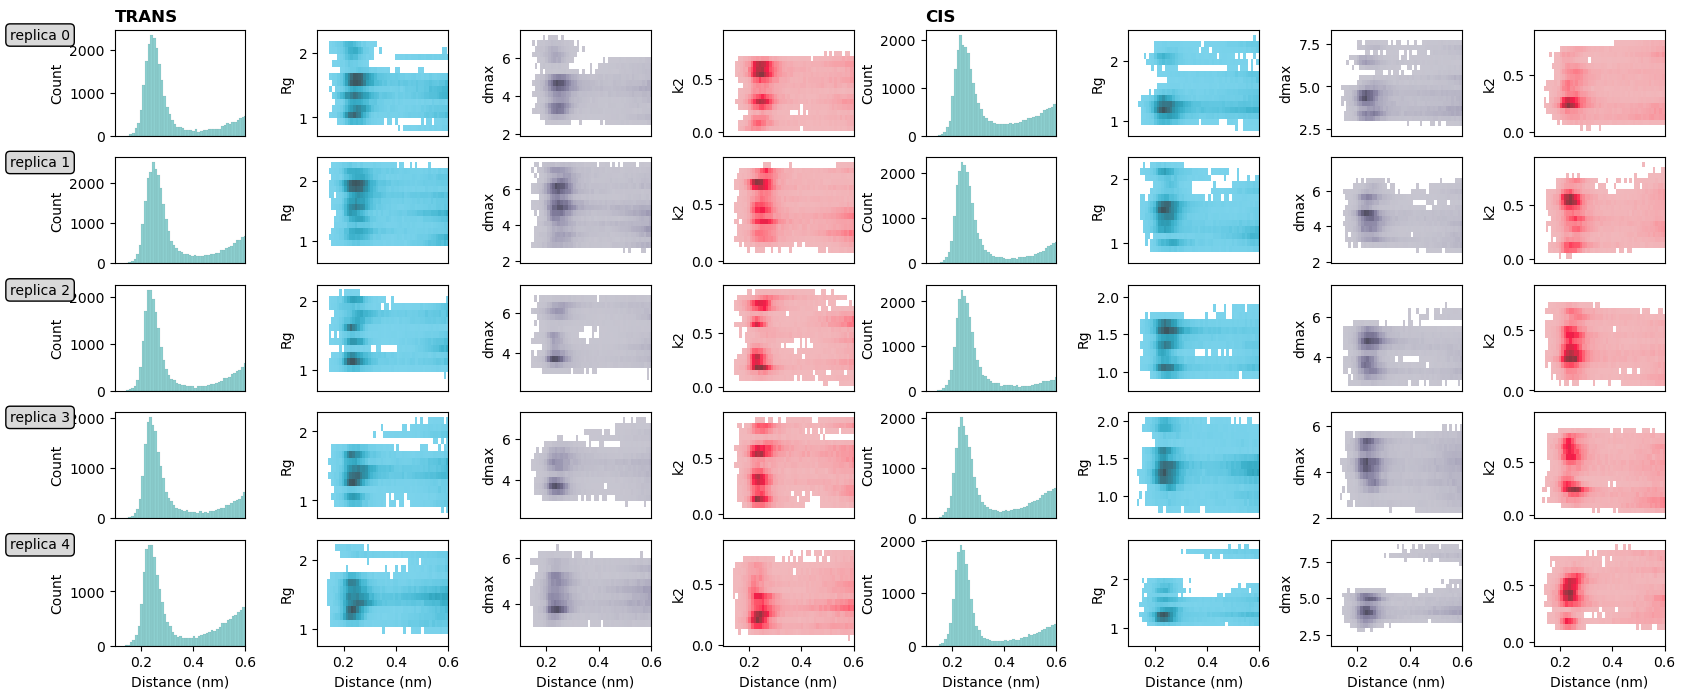

In [38]:
fig, ax = plt.subplots(nrows=5, ncols=8, figsize=(20,8))

fig.subplots_adjust(hspace=0.2, wspace=0.55)

#fig.suptitle(
#    "Properties as a function of the closest distance",
#    fontweight="bold",
#    fontsize=15,
#    y=0.95
#)

col_init = {"cis": 4, "trans": 0}

for iso in ["trans", "cis"]:
    n = col_init[iso]
    
    ax[0, n].set_title(iso.upper(), horizontalalignment="left", fontweight="bold", loc="left")
    
    for j, r in enumerate(DISTCLOSE2[iso]):
        dat = DISTCLOSE2[iso][r]["dprop"]
        if n == 0:
            ax[j, 0].text(
                -.8, 0.95,
                "replica {}".format(r),
                transform=ax[j, 0].transAxes,
                bbox=nbconfig.boxText,
                ha="left",
                va="center",
                fontsize=10,
                rotation=0)

        
        for i, prop in enumerate(["distance", "Rg", "dmax", "k2"]):
            i += n
            if i == n:
                sns.histplot(
                    data=dat,
                    x=prop,
                    ax=ax[j, i],
                    binwidth=POLPROP2[prop]["binwidth"],
                    color=POLPROP2[prop]["color"]
                )
            else:
                sns.histplot(
                    data=dat,
                    x="distance",
                    y=prop,
                    ax=ax[j, i],
                    binwidth=[POLPROP2["distance"]["binwidth"], POLPROP2[prop]["binwidth"]],
                    color=POLPROP2[prop]["color"]
                    
                )
                
            if j != 4:
                ax[j, i].get_xaxis().set_visible(False)
            else:
                ax[j, i].set_xlabel("Distance (nm)")
            
            ax[j, i].set_xlim(0.1, .6)

# saveFig("systems_closest_distance.png")
plt.show()
plt.close()

In [39]:
def get_dict2w(df):
    DICT = {}
    for i in df.index:
        DICT[round(df.loc[i, "bin"], 2)] = df.loc[i, "distance"]
    return DICT

In [40]:
dictW = get_dict2w(RDFGLOB3["trans"][" 0 1 2 3 4"]["rdf"])

In [41]:
for iso in RDFGLOB3:
    RDFGLOB3[iso][" 0 1 2 3 4"]["dprop"]["w"] = RDFGLOB3[iso][" 0 1 2 3 4"]["dprop"]["bin"].apply(lambda x: dictW[round(x, 2)])

In [45]:
RDFGLOB3["trans"][" 0 1 2 3 4"]["dprop"]

distance     Rg     k2   dmax    time  frame   bin      w
0       0.261281  1.145  0.311  3.470   502.5      0  0.30  33412
1       0.263626  1.546  0.524  4.871   502.5      0  0.30  33412
2       2.029362  1.049  0.203  3.294   502.5      0  2.05  15431
3       1.314957  1.694  0.775  5.721   502.5      0  1.35  16785
4       1.441292  2.014  0.766  6.362   502.5      0  1.45  16820
...          ...    ...    ...    ...     ...    ...   ...    ...
715537  2.392762  0.901  0.223  3.078  5500.0   9999  2.40   9471
715538  1.716181  1.366  0.263  3.996  5500.0   9999  1.75  17056
715539  2.194453  1.306  0.385  4.020  5500.0   9999  2.20  13097
715540  1.303998  1.205  0.156  3.498  5500.0   9999  1.35  16785
715541  1.304569  1.237  0.438  4.317  5500.0   9999  1.35  16785

[715542 rows x 8 columns]

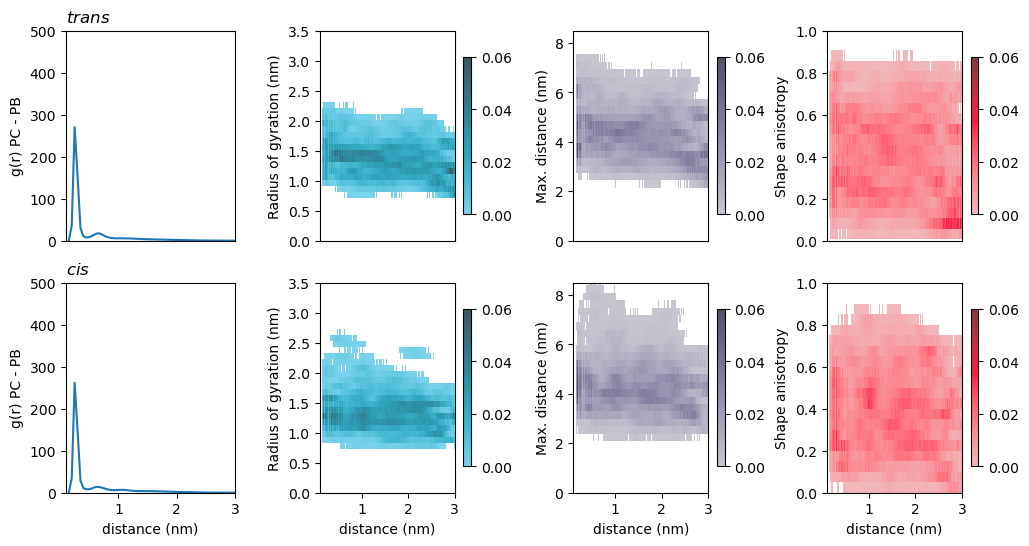

In [66]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,6))

fig.subplots_adjust(hspace=0.2, wspace=0.5)

#fig.suptitle(
#    "Evolution of desviation standard as a function of distance",
#    fontweight="bold",
#    fontsize=15,
#    y=0.97
#)

propLims = {
    "rdf": [0, 500],
    "Rg": [0.0, 3.5],
    "dmax": [0., 8.5],
    "k2": [0.0, 1.]
}

#sns.set_palette("rocket")
for i, iso in enumerate(["trans", "cis"]):
    ax[i, 0].set_title(r"$%s$" % iso, horizontalalignment="left", fontweight="bold", loc="left")  # - Replicas 0 1 2 3 4
    
    # data = STDCUM3[iso][" 0 1 2 3 4"].copy()
    data = RDFGLOB2[iso][" 0 1 2 3 4"]["dprop"].copy()
    data = data[data["bin"] > data["bin"].min() + 0.02]
    rdf = RDFGLOB2[iso][" 0 1 2 3 4"]["rdf"].copy()
    # data.drop(index=0, inplace=True)
    # print(data)
    
    for j, prop in enumerate(["rdf", "Rg", "dmax", "k2"]):
        formProp = POLPROP2[prop]
        
        if prop == "rdf":
            ax[i, j].plot(rdf["bin"], rdf["gr"], label=r)
            
        else:
            """
            ax[i, j].errorbar(
                    data["bin"][""],
                    y=data[prop]["mean"],
                    yerr=data[prop]["std"],
                    fmt=".",
                    capsize=4,
                    color="black",
                    ecolor=POLPROP2[prop]["color"],
            )
            """
            plot = sns.histplot(
                    data=data,
                    x="distance",
                    y=prop,
                    weights=1/data["w"],
                    stat="count",
                    ax=ax[i, j],
                    binwidth=[POLPROP2["distance"]["binwidth"], POLPROP2[prop]["binwidth"]],
                    color=POLPROP2[prop]["color"],
                    cbar=True, cbar_kws=dict(shrink=.75)
                )
            
            # plot.collections[0].set_clim(POLPROP2[prop]["clim"])
            plot.collections[0].set_clim(0, 0.06)
            
            # Set the color bar limits
            #cbar_limits = (0, 0.3)  # Change these values to your desired limits
            # plot.collections[0].colorbar.set_ticks([0, 0.1, 0.2, 0.3])  # Optional: Set custom tick values
            # plot.collections[0].colorbar.set_clim(*cbar_limits)


        ax[i, j].set_ylabel(formProp["label"])
        ax[i, j].set_xlabel("distance (nm)")
        ax[i, j].set_xlim(0.1, 3.)
        ax[i, j].set_ylim(propLims[prop])
        
        if i == 0:
            ax[i, j].get_xaxis().set_visible(False)
                
#ax[0, 2].legend(loc='center left', bbox_to_anchor=(1, 0.))

# saveFig("sumReps_meansVals_closest_distance.png")
# saveFig("PB_dist_prop_map.png")
plt.show()
plt.close()

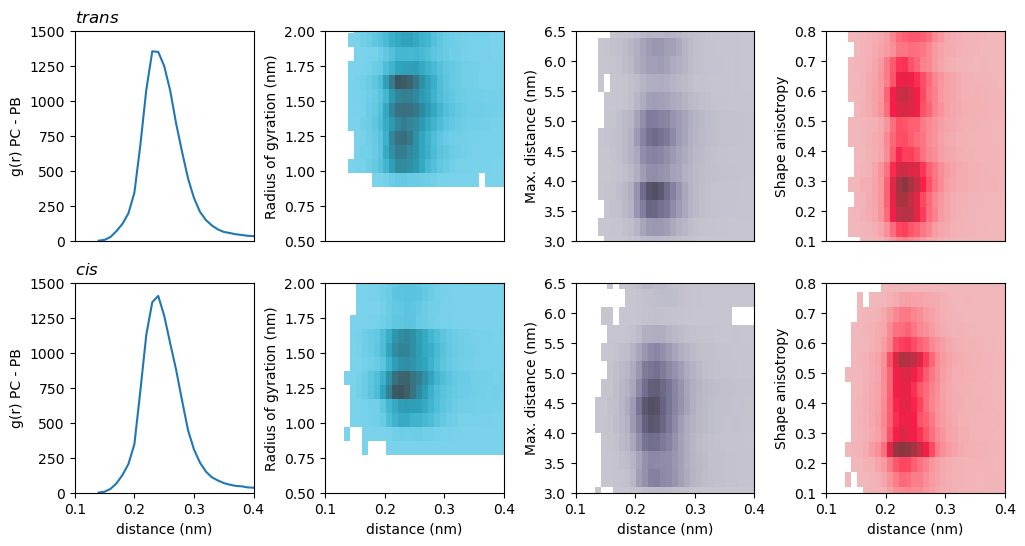

In [93]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,6))

fig.subplots_adjust(hspace=0.2, wspace=0.4)

#fig.suptitle(
#    "Evolution of desviation standard as a function of distance",
#    fontweight="bold",
#    fontsize=15,
#    y=0.97
#)

propLims = {
    "rdf": [0, 1500],
    "Rg": [0.5, 2],
    "dmax": [3., 6.5],
    "k2": [0.1, 0.8]
}

for i, iso in enumerate(["trans", "cis"]):
    ax[i, 0].set_title(r"$%s$" % iso, horizontalalignment="left", fontweight="bold", loc="left")  # - Replicas 0 1 2 3 4
    
    # data = STDCUM3[iso][" 0 1 2 3 4"].copy()
    data = RDFGLOB3[iso][" 0 1 2 3 4"]["dprop"].copy()
    rdf = RDFGLOB3[iso][" 0 1 2 3 4"]["rdf"].copy()
    # data.drop(index=0, inplace=True)
    # print(data)
    
    for j, prop in enumerate(["rdf", "Rg", "dmax", "k2"]):
        formProp = POLPROP2[prop]
        
        if prop == "rdf":
            ax[i, j].plot(rdf["bin"], rdf["gr"], label=r)
            
        else:
            """
            ax[i, j].errorbar(
                    data["bin"][""],
                    y=data[prop]["mean"],
                    yerr=data[prop]["std"],
                    fmt=".",
                    capsize=4,
                    color="black",
                    ecolor=POLPROP2[prop]["color"],
            )
            """
            sns.histplot(
                    data=data,
                    x="distance",
                    y=prop,
                    weights="w",
                    ax=ax[i, j],
                    binwidth=[POLPROP2["distance"]["binwidth"], POLPROP2[prop]["binwidth"]],
                    color=POLPROP2[prop]["color"]
                )


        ax[i, j].set_ylabel(formProp["label"])
        ax[i, j].set_xlabel("distance (nm)")
        ax[i, j].set_xlim(0.1, .4)
        ax[i, j].set_ylim(propLims[prop])
        
        if i == 0:
            ax[i, j].get_xaxis().set_visible(False)
                
#ax[0, 2].legend(loc='center left', bbox_to_anchor=(1, 0.))

# saveFig("sumReps_meansVals_closest_distance.png")
plt.show()
plt.close()

![](sumReps_meansVals_closest_distance-all.png)

Polymer properties as a function of distance, with a maximum distance of 1.0 nm and a bin width of 0.01 nm. Here it is averaged for the 4 replicates

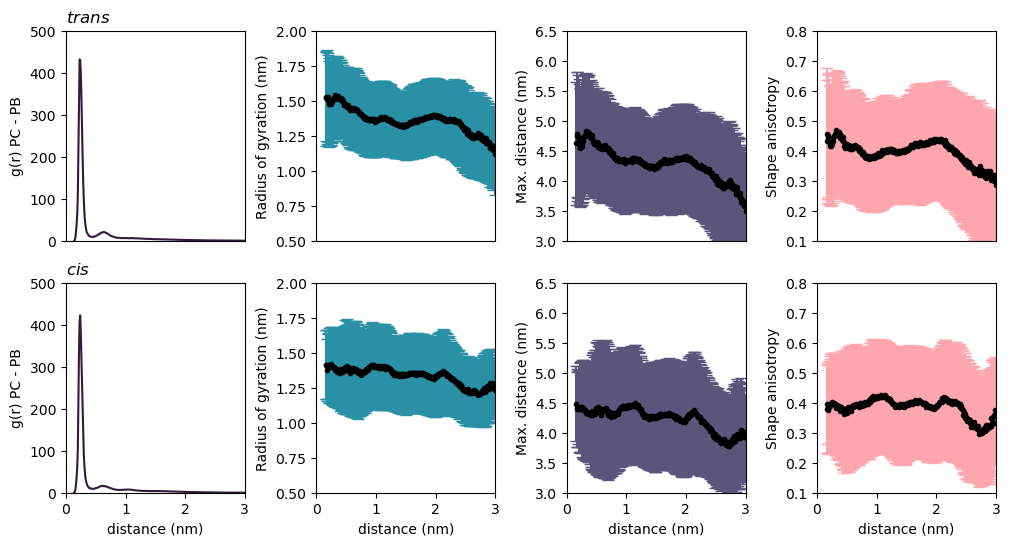

In [271]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,6))

fig.subplots_adjust(hspace=0.2, wspace=0.4)

#fig.suptitle(
#    "Evolution of desviation standard as a function of distance",
#    fontweight="bold",
#    fontsize=15,
#    y=0.97
#)

propLims = {
    "rdf": [0, 500],
    "Rg": [0.5, 2],
    "dmax": [3., 6.5],
    "k2": [0.1, 0.8]
}

for i, iso in enumerate(["trans", "cis"]):
    ax[i, 0].set_title(labels[iso], horizontalalignment="left", loc="left")
    
    data = STDCUM3[iso][" 0 1 2 3 4"].copy()
    data.drop(index=[0,1], inplace=True)
    rdf = RDFGLOB3[iso][" 0 1 2 3 4"]["rdf"].copy()
    
    for j, prop in enumerate(["rdf", "Rg", "dmax", "k2"]):
        formProp = POLPROP2[prop]
        
        if prop == "rdf":
            ax[i, j].plot(rdf["bin"], rdf["gr"], label=r)
            
        else:
            ax[i, j].errorbar(
                    data["bin"][""],
                    y=data[prop]["mean"],
                    yerr=data[prop]["std"],
                    fmt=".",
                    capsize=4,
                    color="black",
                    ecolor=POLPROP2[prop]["color"],
            )


        ax[i, j].set_ylabel(formProp["label"])
        ax[i, j].set_xlabel("distance (nm)")
        ax[i, j].set_xlim(0, 3.)
        ax[i, j].set_ylim(propLims[prop])
        
        if i == 0:
            ax[i, j].get_xaxis().set_visible(False)
                
#ax[0, 2].legend(loc='center left', bbox_to_anchor=(1, 0.))

# saveFig("sumReps_meansVals_closest_distance.png")
saveFig("PB_dist_prop.png")
plt.show()
plt.close()

![](sumReps_meansVals_closest_distance-all-2.png)

### Comparison CM vs Distance min atom

In [81]:
CMSizesGLOB["trans"][" 0 1 2 3 4"]["rdf"]

bin  distance     Rg     k2   dmax   time  frame    vshell        gr  \
0   0.50       166    166    166    166    166    166  0.173311  0.293889   
1   0.55       349    349    349    349    349    349  0.207869  0.515155   
2   0.60       357    357    357    357    357    357  0.245568  0.446065   
3   0.65       328    328    328    328    328    328  0.286409  0.351390   
4   0.70       423    423    423    423    423    423  0.330391  0.392839   
5   0.75       682    682    682    682    682    682  0.377515  0.554309   
6   0.80      1174   1174   1174   1174   1174   1174  0.427780  0.842072   
7   0.85      1569   1569   1569   1569   1569   1569  0.481187  1.000485   
8   0.90      1974   1974   1974   1974   1974   1974  0.537736  1.126367   
9   0.95      2098   2098   2098   2098   2098   2098  0.597426  1.077514   
10  1.00      2275   2275   2275   2275   2275   2275  0.660258  1.057230   
11  1.05      2558   2558   2558   2558   2558   2558  0.726232  1.080755   
12  1.10      2564   2564   2564   2564   2564   2564  0.795347  0.989153   
13  1.15      2488   2488   2488   2488   2488   2488  0.867603  0.879895   
14  1.20      2454   2454   2454   2454   2454   2454  0.943001  0.798480   
15  1.25      2733   2733   2733   2733   2733   2733  1.021541  0.820891   
16  1.30      3357   3357   3357   3357   3357   3357  1.103223  0.933662   
17  1.35      3884   3884   3884   3884   3884   3884  1.188046  1.003108   
18  1.40      4371   4371   4371   4371   4371   4371  1.276010  1.051062   
19  1.45      4990   4990   4990   4990   4990   4990  1.367116  1.119945   
20  1.50      5238   5238   5238   5238   5238   5238  1.461364  1.099787   
21  1.55      5201   5201   5201   5201   5201   5201  1.558754  1.023790   
22  1.60      5495   5495   5495   5495   5495   5495  1.659285  1.016128   
23  1.65      5472   5472   5472   5472   5472   5472  1.762957  0.952371   
24  1.70      4764   4764   4764   4764   4764   4764  1.869771  0.781781   
25  1.75      4624   4624   4624   4624   4624   4624  1.979727  0.716662   
26  1.80      4678   4678   4678   4678   4678   4678  2.092824  0.685850   
27  1.85      5232   5232   5232   5232   5232   5232  2.209063  0.726710   
28  1.90      6263   6263   6263   6263   6263   6263  2.328444  0.825312   
29  1.95      7485   7485   7485   7485   7485   7485  2.450966  0.937036   
30  2.00      8245   8245   8245   8245   8245   8245  2.576630  0.981839   
31  2.05      8657   8657   8657   8657   8657   8657  2.705435  0.981820   
32  2.10      9213   9213   9213   9213   9213   9213  2.837382  0.996288   
33  2.15      9437   9437   9437   9437   9437   9437  2.972470  0.974133   
34  2.20      9432   9432   9432   9432   9432   9432  3.110700  0.930352   
35  2.25      9176   9176   9176   9176   9176   9176  3.252072  0.865755   
36  2.30      8903   8903   8903   8903   8903   8903  3.396585  0.804258   
37  2.35      9047   9047   9047   9047   9047   9047  3.544240  0.783219   
38  2.40     10025  10025  10025  10025  10025  10025  3.695037  0.832468   
39  2.45     11287  11287  11287  11287  11287  11287  3.848975  0.899778   
40  2.50     12248  12248  12248  12248  12248  12248  4.006054  0.938102   
41  2.55     13616  13616  13616  13616  13616  13616  4.166275  1.002774   
42  2.60     14719  14719  14719  14719  14719  14719  4.329638  1.043106   
43  2.65     15078  15078  15078  15078  15078  15078  4.496143  1.028976   
44  2.70     15212  15212  15212  15212  15212  15212  4.665789  1.000375   
45  2.75     16162  16162  16162  16162  16162  16162  4.838576  1.024895   
46  2.80     18754  18754  18754  18754  18754  18754  5.014505  1.147539   
47  2.85     20161  20161  20161  20161  20161  20161  5.193576  1.191097   
48  2.90     19101  19101  19101  19101  19101  19101  5.375789  1.090224   
49  2.95     18372  18372  18372  18372  18372  18372  5.561143  1.013664   
50  3.00     18071  18071  18071  18071  18071  18071  5.749638  0.964369   



In [80]:
RDFGLOB2["trans"][" 0 1 2 3 4"]["rdf"]

bin  distance     Rg     k2   dmax   time  frame    vshell          gr  \
0   0.15        20     20     20     20     20     20  0.019373    0.316761   
1   0.20      3747   3747   3747   3747   3747   3747  0.031940   35.996222   
2   0.25     41953  41953  41953  41953  41953  41953  0.047647  270.162265   
3   0.30     33412  33412  33412  33412  33412  33412  0.066497  154.170688   
4   0.35      8552   8552   8552   8552   8552   8552  0.088488   29.654052   
5   0.40      3993   3993   3993   3993   3993   3993  0.113621   10.783075   
6   0.45      3608   3608   3608   3608   3608   3608  0.141895    7.801899   
7   0.50      4826   4826   4826   4826   4826   4826  0.173311    8.544022   
8   0.55      7867   7867   7867   7867   7867   7867  0.207869   11.612392   
9   0.60     12282  12282  12282  12282  12282  12282  0.245568   15.346145   
10  0.65     16716  16716  16716  16716  16716  16716  0.286409   17.908042   
11  0.70     17293  17293  17293  17293  17293  17293  0.330391   16.059945   
12  0.75     15357  15357  15357  15357  15357  15357  0.377515   12.481713   
13  0.80     12951  12951  12951  12951  12951  12951  0.427780    9.289328   
14  0.85     11275  11275  11275  11275  11275  11275  0.481187    7.189590   
15  0.90     10948  10948  10948  10948  10948  10948  0.537736    6.246941   
16  0.95     11150  11150  11150  11150  11150  11150  0.597426    5.726540   
17  1.00     12349  12349  12349  12349  12349  12349  0.660258    5.738782   
18  1.05     13558  13558  13558  13558  13558  13558  0.726232    5.728253   
19  1.10     14714  14714  14714  14714  14714  14714  0.795347    5.676440   
20  1.15     15627  15627  15627  15627  15627  15627  0.867603    5.526576   
21  1.20     16190  16190  16190  16190  16190  16190  0.943001    5.267884   
22  1.25     16903  16903  16903  16903  16903  16903  1.021541    5.077028   
23  1.30     16926  16926  16926  16926  16926  16926  1.103223    4.707527   
24  1.35     16785  16785  16785  16785  16785  16785  1.188046    4.335008   
25  1.40     17149  17149  17149  17149  17149  17149  1.276010    4.123693   
26  1.45     16820  16820  16820  16820  16820  16820  1.367116    3.775045   
27  1.50     17183  17183  17183  17183  17183  17183  1.461364    3.607798   
28  1.55     16820  16820  16820  16820  16820  16820  1.558754    3.310932   
29  1.60     17146  17146  17146  17146  17146  17146  1.659285    3.170616   
30  1.65     17166  17166  17166  17166  17166  17166  1.762957    2.987645   
31  1.70     17109  17109  17109  17109  17109  17109  1.869771    2.807617   
32  1.75     17056  17056  17056  17056  17056  17056  1.979727    2.643465   
33  1.80     17146  17146  17146  17146  17146  17146  2.092824    2.513806   
34  1.85     16545  16545  16545  16545  16545  16545  2.209063    2.298054   
35  1.90     16253  16253  16253  16253  16253  16253  2.328444    2.141753   
36  1.95     15758  15758  15758  15758  15758  15758  2.450966    1.972720   
37  2.00     15589  15589  15589  15589  15589  15589  2.576630    1.856385   
38  2.05     15431  15431  15431  15431  15431  15431  2.705435    1.750083   
39  2.10     14586  14586  14586  14586  14586  14586  2.837382    1.577321   
40  2.15     13738  13738  13738  13738  13738  13738  2.972470    1.418103   
41  2.20     13097  13097  13097  13097  13097  13097  3.110700    1.291860   
42  2.25     12322  12322  12322  12322  12322  12322  3.252072    1.162580   
43  2.30     11321  11321  11321  11321  11321  11321  3.396585    1.022690   
44  2.35     10641  10641  10641  10641  10641  10641  3.544240    0.921215   
45  2.40      9471   9471   9471   9471   9471   9471  3.695037    0.786464   
46  2.45      8559   8559   8559   8559   8559   8559  3.848975    0.682307   
47  2.50      7523   7523   7523   7523   7523   7523  4.006054    0.576204   
48  2.55      6700   6700   6700   6700   6700   6700  4.166275    0.493433   
49  2.60      6041   6041   6041   6041   6041   6041  

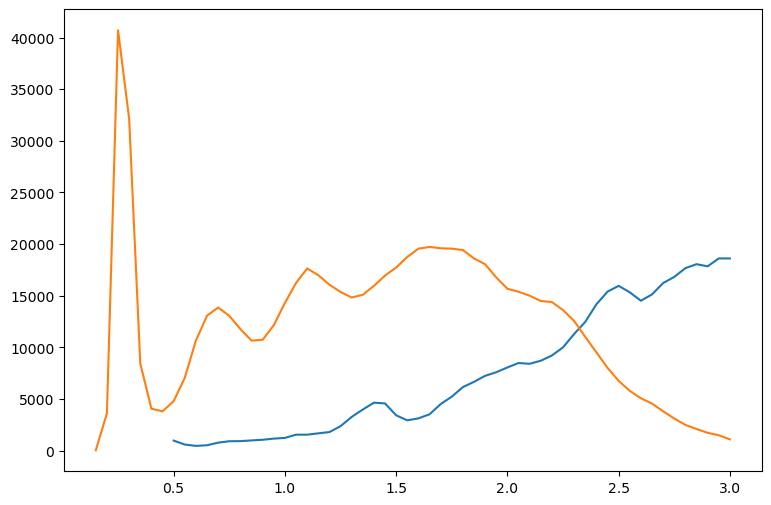

In [87]:
datCM = CMSizesGLOB["cis"][" 0 1 2 3 4"]["rdf"].copy()
datDC = RDFGLOB2["cis"][" 0 1 2 3 4"]["rdf"].copy()

plt.plot(datCM["bin"], datCM["distance"])
plt.plot(datDC["bin"], datDC["distance"])

# saveFig("comparison_cm_dc.png")

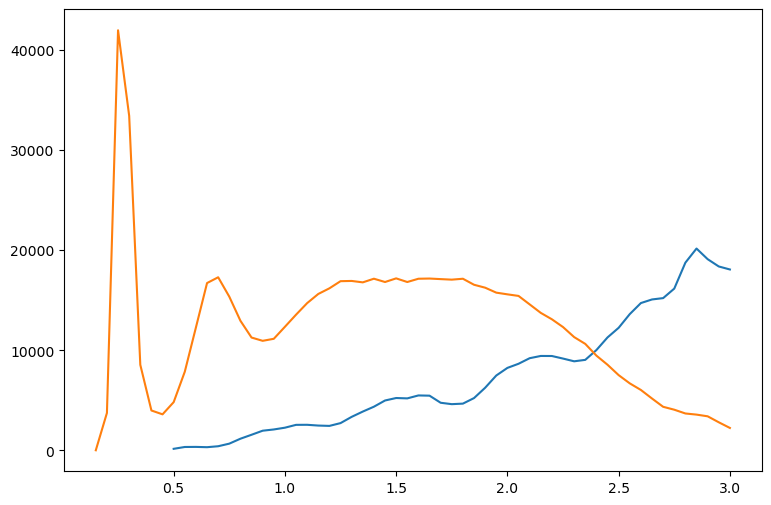

In [86]:
datCM = CMSizesGLOB["trans"][" 0 1 2 3 4"]["rdf"].copy()
datDC = RDFGLOB2["trans"][" 0 1 2 3 4"]["rdf"].copy()

plt.plot(datCM["bin"], datCM["distance"])
plt.plot(datDC["bin"], datDC["distance"])

saveFig("comparison_cm_dc.png")

## PB-OH experiments

### Phototchrome geometry

In [30]:
Param_color = {
    "PB": "#75acc5",
    "PB-OH": "#a605ff"
}

In [31]:
# Load all file with Geometry information
GEOMoh = {
    "PB": {"trans": {}, "cis": {}},
    "PB-OH": {"trans": {}, "cis": {}}
}

for system in GEOMoh:
    for iso in GEOMoh[system]:
        for r in replicas:
            freq = 1.
            t0 = 1.
            
            if system == "PB":
                path_file = "{}/{}/6_prod_{}/Geometry_mol.csv".format(home_stamp, iso, r)
            elif system == "PB-OH":
                path_file = "{}/{}/9_prod_OH_{}/Geometry_mol.csv".format(home_stamp, iso, r)
                freq = 0.1
                t0 = 0.1

            data = read_geometry_file(
                path_file,
                freq=freq,
                t0=t0
                )
            GEOMoh[system][iso][r] = data.copy()

GEOMtotoh = {}

for system in GEOMoh:
    GEOMtotoh[system] = {}
    for iso in GEOMoh[system]:
        GEOMtotoh[system][iso] = []
        for r in GEOMoh[system][iso]:
            GEOMtotoh[system][iso].append(GEOMoh[system][iso][r])

        GEOMtotoh[system][iso] = pd.concat(GEOMtotoh[system][iso], ignore_index=True)

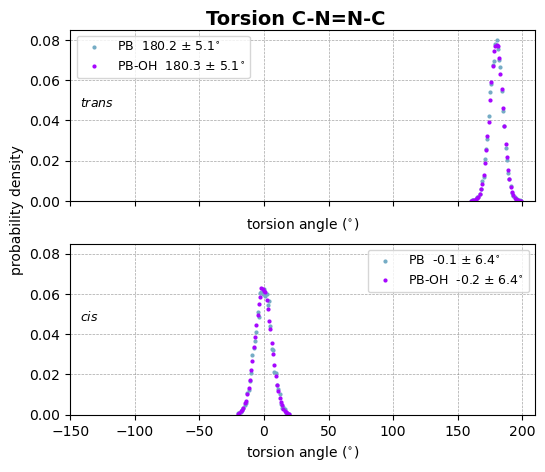

In [32]:
torsion = "d_cnnc"
grid_lines_x = np.arange(0, 0.1 + 0.01, 0.01)
grid_lines_y = np.arange(-150, 200 + 50, 50)

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(6,5))

fig.subplots_adjust(hspace=0.25, wspace=0.1)

fig.suptitle(
    f"Torsion C-N=N-C",
    fontweight="bold",
    fontsize=14,
    y=0.92,
    x=0.5,
    ha = "center"
)

systems = ['trans', 'cis']

for i, isomer in enumerate(systems):
    for sol in ["PB", "PB-OH"]:
        data = GEOMtotoh[sol][isomer].copy()
        data[torsion] = data[torsion].apply(lambda x: rot(x, Param_cnnc[isomer]["deg"]))
        bins = np.arange(
            Param_cnnc[isomer]["center"] - Param_cnnc[isomer]["edge"],
            Param_cnnc[isomer]["center"] + Param_cnnc[isomer]["edge"] + Param_cnnc[isomer]["step"],
            Param_cnnc[isomer]["step"]
        )
        hist, _ = np.histogram(data[torsion], bins=bins, density=True)
        
        ndata = data.copy()
        ax[i].plot(
            bins[:-1],
            hist, ".",
            label = sol + r"  %.1f $\pm$ %.1f$^{\circ}$" % (ndata[torsion].mean(), ndata[torsion].std()),
            color = Param_color[sol],
            ms = 4.
        )
        
    ax[i].set_xlim(-150., 210.)
    ax[i].set_ylim(ymin=0., ymax=0.085)

    ax[i].text(
            0.02, 0.55,
            "{}".format(labels[isomer]), transform=ax[i].transAxes,
            ha="left",
            rotation=0, fontsize=9
        )
    # ax[i].set_title(t)
    ax[i].legend(fontsize=9)
    ax[i].set_xlabel(r"torsion angle ($^{\circ}$)")
    ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    # ax[i].xaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    if i != 1:
        # ax[i].get_xaxis().set_visible(False)
        #ax[i].set_xlabel("")
        #ax[i].set_xticks([])
        #ax[i].xaxis.set_ticks([])
        # ax[i].xaxis.set_grid()
        ax[i].set_xticklabels([])

    # ax[i].xaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
        
    # ax[i].set_yticks([0., 0.04, 0.08])
    if i == 1:
        ax[i].set_ylabel("probability density", y=1.2)
        
            
# saveFig(f"torsion_{torsion}_all.png")
# SaveFigPaper.saveFig(f"torsion_{torsion}_all.png")
plt.show()

In [33]:
Param_ccnn = {
    "trans":{
        "torsion": ["d_ccnn_1", "d_ccnn_4"],
        "step": 1.0,
        "center": 90.0,
        "edge": 210.0,
        "deg": -90.0
    },
    "cis":{
        "torsion": ["d_ccnn_1", "d_ccnn_3"],
        "step": 1.0,
        "center": 0.0,
        "edge": 210.0,
        "deg": -180.0
    },
    "s1":{
        "torsion": ["d_ccnn_1", "d_ccnn_4"],
        "step": 1.0,
        "center": 90.0,
        "edge": 210.0,
        "deg": -100.0
    }
}

trans -0.4068648261999999
trans 178.984371764
178.984371764
trans 3.416697746039063
trans 167.4712900397671
167.4712900397671
cis 102.82302017308655
cis 102.87256985242622
cis 103.03307226239372
cis 103.81185613284994


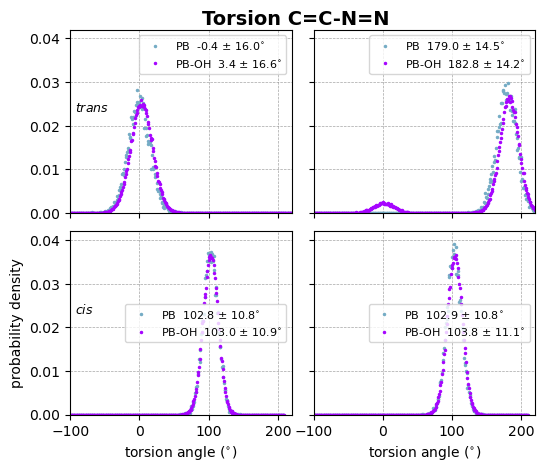

In [40]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,5))

fig.subplots_adjust(hspace=0.1, wspace=0.1)

fig.suptitle(
    f"Torsion C=C-N=N",
    fontweight="bold",
    fontsize=14,
    y=0.92,
    x=0.5,
    ha = "center"
)

systems = ['trans', 'cis']

for i, iso in enumerate(systems):
    for sol in ["PB", "PB-OH"]:
        data = GEOMtotoh[sol][iso].copy()
        for j, torsion in enumerate(Param_ccnn[iso]["torsion"]):
            #if j==1 and iso == "trans" and sol == "PB":
            #    torsion = "d_ccnn_3"
                
            data[torsion] = data[torsion].apply(lambda x: rot(x, Param_ccnn[iso]["deg"]))
            bins = np.arange(
                Param_ccnn[iso]["center"] - Param_ccnn[iso]["edge"],
                Param_ccnn[iso]["center"] + Param_ccnn[iso]["edge"] + Param_ccnn[iso]["step"],
                Param_ccnn[iso]["step"]
            )
            hist, _ = np.histogram(data[torsion], bins=bins, density=True)
            ndata = data.copy()
            
            # means
            print(iso, ndata[torsion].mean())
            if iso == "trans" and ndata[torsion].mean() > 100.:
                print(ndata[torsion].mean())
                mean = ndata[ndata[torsion] > 90.][torsion].mean()
                std = ndata[ndata[torsion] > 90.][torsion].std()
            else:
                mean = ndata[torsion].mean()
                std = ndata[torsion].std()
                
                
            ax[i,j].plot(
                bins[:-1],
                hist, ".", ms = 3,
                label = sol + r"  %.1f $\pm$ %.1f$^{\circ}$" % (mean, std),
                color = Param_color[sol]
            )
            ax[i, j].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
            if i != 1:
                # ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].set_xticklabels([])
                
            if j == 1:
                # ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].set_yticklabels([])

            ax[i, j].set_xlim(-100., 220.)
            # ax[i, j].set_ylim(ymin=0.)
            ax[i, j].legend(fontsize=8)
            ax[i, j].set_xlabel(r"torsion angle ($^{\circ}$)")
            
            ax[i, j].set_ylim(0., 0.042)
            # ax[i, j].set_yticks([])
            
    ax[i, 0].text(
        0.02, 0.55,
        "{}".format(labels[iso]), transform=ax[i, 0].transAxes,
        ha="left",
        rotation=0, fontsize=9
    )
    
ax[1, 0].set_ylabel("probability density")
            
            
# saveFig(f"torsion_d_ccnn_2_all.png")
# SaveFigPaper.saveFig(f"torsion_d_ccnn_2_all.png")
plt.show()

In [203]:
Param_cnn = {
    "trans":{
        "angle": ["a_cnn_1", "a_cnn_2"],
        "step": 1.0,
        "center": 115.0,
        "edge": 20.0,
        "deg": -100.0
    },
    "cis":{
        "angle": ["a_cnn_1", "a_cnn_2"],
        "step": 1.0,
        "center": 110.0,
        "edge": 20.0,
        "deg": -100.0
    },
    "s1":{
        "angle": ["a_cnn_1", "a_cnn_2"],
        "step": 1.0,
        "center": 125.0,
        "edge": 20.0,
        "deg": -100.0
    }
}

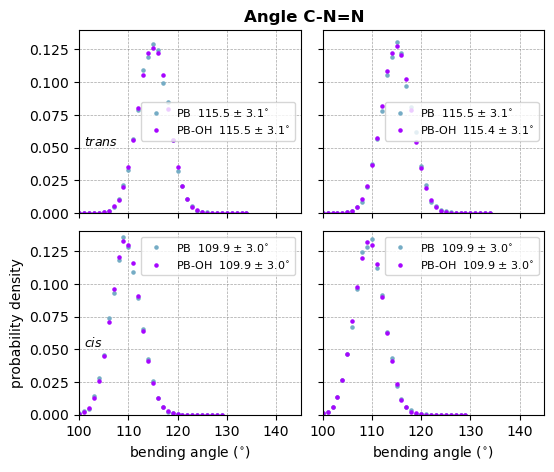

In [204]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,5))

fig.subplots_adjust(hspace=0.1, wspace=0.1)

fig.suptitle(
    f"Angle C-N=N",
    fontweight="bold",
    fontsize=12,
    y=0.92,
    x=0.5,
    ha = "center"
)

systems = ['trans', 'cis']

for i, isomer in enumerate(systems):
    for sol in ["PB", "PB-OH"]:
        data = GEOMtotoh[sol][isomer].copy()
        for j, angle in enumerate(Param_cnn[isomer]["angle"]):
            data[angle] = data[angle].apply(lambda x: rot(x, Param_cnn[isomer]["deg"]))
            bins = np.arange(
                Param_cnn[isomer]["center"] - Param_cnn[isomer]["edge"],
                Param_cnn[isomer]["center"] + Param_cnn[isomer]["edge"] + Param_cnn[isomer]["step"],
                Param_cnn[isomer]["step"]
            )
            hist, _ = np.histogram(data[angle], bins=bins, density=True)
            ax[i,j].plot(
                bins[:-1],
                hist, ".", ms = 4.5,
                label = sol + r"  %.1f $\pm$ %.1f$^{\circ}$" % (data[angle].mean(), data[angle].std()),
                color = Param_color[sol]
            )
                
            if i != 1:
                ax[i, j].set_xticklabels([])
                
            if j == 1:
                # ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].set_yticklabels([])

            ax[i, j].set_xlim(100., 145.)
            #ax[i, j].set_ylim(ymin=0.)
            ax[i, j].legend(fontsize=8)
            ax[i, j].set_xlabel(r"bending angle ($^{\circ}$)")
            
            ax[i, j].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
            
            ax[i, j].set_ylim(0., 0.14)
            # ax[i, j].set_yticks([])

    ax[i, 0].text(
        0.02, 0.37,
        "{}".format(labels[isomer]), transform=ax[i, 0].transAxes,
        ha="left",
        rotation=0, fontsize=9
    )
    
ax[1, 0].set_ylabel("probability density")
            
# saveFig(f"angle_a_cnn_all.png")
# SaveFigPaper.saveFig(f"angle_a_cnn_all.png")
plt.show()

#### Observed rotatation (replica 4)

In [39]:
# dat_pb_0 = GEOMoh["PB"]["trans"]["0"]
dat_oh_4 = GEOMoh["PB-OH"]["trans"]["4"].copy()

In [40]:
dat_oh_4["d_ccnn_2"] = dat_oh_4["d_ccnn_2"].apply(lambda x: nbconfig.rot(x, -100))
dat_oh_4["d_ccnn_3"] = dat_oh_4["d_ccnn_3"].apply(lambda x: nbconfig.rot(x, -100))
dat_oh_4["d_ccnn_4"] = dat_oh_4["d_ccnn_4"].apply(lambda x: nbconfig.rot(x, -100))

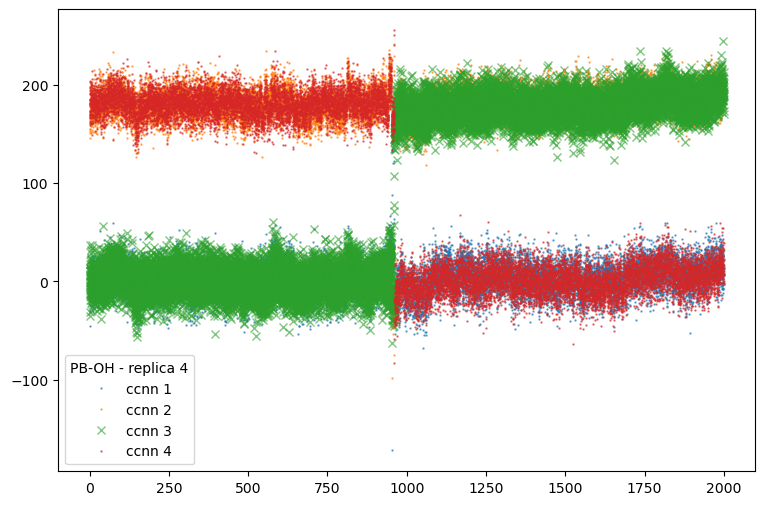

In [42]:
## plt.plot(dat_pb_0["time"], dat_pb_0["d_ccnn_1"], ".", alpha=0.6, label="PB")
plt.plot(dat_oh_4["time"], dat_oh_4["d_ccnn_1"], ".", ms=1.5, alpha=0.6, label="ccnn 1")
plt.plot(dat_oh_4["time"], dat_oh_4["d_ccnn_2"], ".", ms=1.5, alpha=0.6, label="ccnn 2")
plt.plot(dat_oh_4["time"], dat_oh_4["d_ccnn_3"], "x", ms=5.5, alpha=0.6, label="ccnn 3")
plt.plot(dat_oh_4["time"], dat_oh_4["d_ccnn_4"], ".", ms=1.5, alpha=0.6, label="ccnn 4")
plt.legend(title="PB-OH - replica 4")
plt.show()

### Mean square displacement

In [3]:
longColOH = {"PB": "red", "THF":"darkblue", "PB-OH": "#9b9d49"}

In [26]:
isomers = ["trans", "cis"]
systems = ["THF", "PB", "PB-OH"]
replicas = ["0", "1", "2", "3", "4"]
MSDALL = {}
CHECK = []

for iso in isomers:
    MSDALL[iso] = {}
    for sol in systems:
        MSDALL[iso][sol] = {}
        for r in replicas:
            MSDALL[iso][sol][r] = {}
            if sol == "PB":
                File_short = "../exp.azob.stamp.5/{}/6_prod_{}/msd.csv".format(iso, r)
                File = "../exp.azob.stamp.3/{}/6_prod_{}/msd.csv".format(iso, r)
            elif sol == "PB-OH":
                File_short = "../exp.azob.stamp.5/{}/9_prod_OH_{}/msd.csv".format(iso, r)
                File = "../exp.azob.stamp.3/{}/9_prod_OH_{}/msd.csv".format(iso, r)
            elif sol == "THF":
                File_short = "../exp.azob.gmx/azob_{}.thf.densf/md{}_10ps/msd.csv".format(iso, r)
                File = "../exp.azob.gmx/azob_{}.thf.densf/md{}/msd.csv".format(iso, r)
            
            ##print("Files:")
            ##print(File_short)
            ##print(File)
            data_short = pd.DataFrame()
            data = pd.DataFrame()
            
            try:
                data_short = pd.read_csv(File_short)
                CHECK.append({
                    "isomer": iso,
                    "system": sol,
                    "replica": r,
                    "type": "short",
                    "Done": ""
                })
            except FileNotFoundError:
                print("#" * 40)
                print("\tError, file not founded:\n", File_short)
                CHECK.append({
                    "isomer": iso,
                    "system": sol,
                    "replica": r,
                    "type": "short",
                    "Done": "x"
                })
                
            try:
                data = pd.read_csv(File)
                CHECK.append({
                    "isomer": iso,
                    "system": sol,
                    "replica": r,
                    "type": "long",
                    "Done": ""
                })
            except FileNotFoundError:
                print("#" * 40)
                print("\tError, file not founded:\n", File)
                CHECK.append({
                    "isomer": iso,
                    "system": sol,
                    "replica": r,
                    "type": "long",
                    "Done": "x"
                })
                
            try:
                #data_short = data_short[data_short["time"] <= 1.]
                data_short.drop(data_short[data_short['time'] == 0.0].index, inplace = True)
                #data = data[data["time"] <= 1000.]
                # data.drop(data[data['time'] == 0.0].index, inplace = True)
            except KeyError:
                pass
                
            try:
                #data_short = data_short[data_short["time"] <= 1.]
                # data_short.drop(data_short[data_short['time'] == 0.0].index, inplace = True)
                #data = data[data["time"] <= 1000.]
                data.drop(data[data['time'] == 0.0].index, inplace = True)
            except KeyError:
                pass
            
            try:
                MSDALL[iso][sol][r]["data"] = pd.concat([
                    data_short[data_short["time"] <= 1.],
                    data[data["time"] <= 1000.]
                ], ignore_index=True)
                short_log2 = get_log2_av(data_short)
                MSDALL[iso][sol][r]["logAv"] = pd.concat([short_log2[short_log2["logAv_tau"] <= 1.0], get_log2_av(data)], ignore_index=True)
            except KeyError:
                pass

print("#" * 40)
CHECK = pd.DataFrame(CHECK)

CHECK[CHECK["Done"] == "x"].style.format(subset=["Done"]).apply(isNotMSD, color="red")
     # .hide(subset=list(CHECK["Done"] == "x"))

########################################
	Error, file not founded:
 ../exp.azob.stamp.3/trans/9_prod_OH_0/msd.csv
########################################
	Error, file not founded:
 ../exp.azob.stamp.5/trans/9_prod_OH_4/msd.csv
########################################
	Error, file not founded:
 ../exp.azob.stamp.3/cis/9_prod_OH_0/msd.csv
########################################
	Error, file not founded:
 ../exp.azob.stamp.5/cis/9_prod_OH_2/msd.csv
########################################
	Error, file not founded:
 ../exp.azob.stamp.5/cis/9_prod_OH_3/msd.csv
########################################
	Error, file not founded:
 ../exp.azob.stamp.5/cis/9_prod_OH_4/msd.csv
########################################


In [192]:
MSDALL["cis"]["PB-OH"]

{'0': {}, '1': {}, '2': {}, '3': {}, '4': {}}

In [156]:
MSDMeans = {}

for iso in MSDALL:
    MSDMeans[iso] = {}
    for sol in MSDALL[iso]:
        df_concat = []
        for r in MSDALL[iso][sol]:
            try:
                df_concat.append(MSDALL[iso][sol][r]["data"])
            except KeyError:
                continue
            
        try:
            df_concat = pd.concat(tuple(df_concat))    
            by_row_index = df_concat.groupby(df_concat.index)
            df_means = by_row_index.mean()
        
            MSDMeans[iso][sol] = df_means.sort_values(by=["time"])
        except ValueError:
            continue

In [162]:
MSDMeansGlob = {}

for iso in MSDALL:
    MSDMeansGlob[iso] = {}
    for sol in MSDALL[iso]:
        df_concat = []
        df_log2Mean = []
        MSDMeansGlob[iso][sol] = {}
        for r in MSDALL[iso][sol]:
            try:
                df_concat.append(MSDALL[iso][sol][r]["data"])
                df_log2Mean.append(MSDALL[iso][sol][r]["logAv"])
            except KeyError:
                continue
            
        try:
            df_concat = pd.concat(tuple(df_concat))    
            by_row_index = df_concat.groupby(df_concat.index)
            df_means = by_row_index.mean()
            df_std = by_row_index.std()
        
            MSDMeansGlob[iso][sol]["mean"] = df_means ## df_means.sort_values(by=["time"])
            MSDMeansGlob[iso][sol]["std"] = df_std / np.sqrt(5) ## df_std.sort_values(by=["time"])
        
        except ValueError:
            del MSDMeansGlob[iso][sol]
            continue
        
        dflogAv = get_log2_av(df_means)
        #########
        df_log2Mean = pd.concat(tuple(df_log2Mean))    
        by_row_index = df_log2Mean.groupby(df_log2Mean.index)
        df_log2Mean = by_row_index.mean()
        # print(df_log2Mean)

        MSDMeansGlob[iso][sol]["logAv"] = df_log2Mean
        MSDMeansGlob[iso][sol]["diff"] = get_diff(df_log2Mean["logAv_tau"], df_log2Mean["logAv_msd"]) ## get_diff(df_means["time"], df_means["msd"])

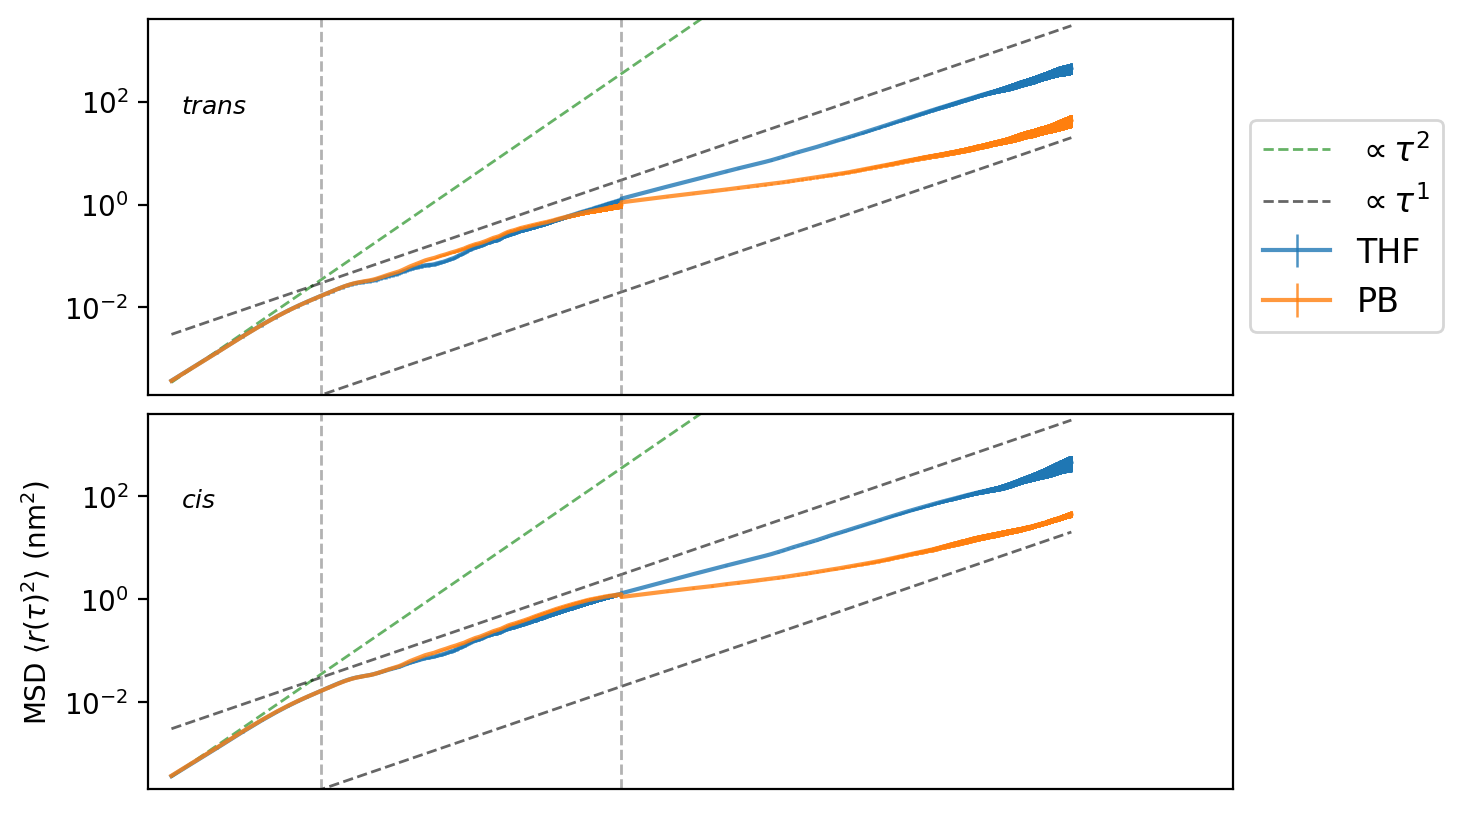

In [177]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7,5), dpi=200)

fig.subplots_adjust(hspace=0.05, wspace=0.2)
# fig.suptitle(
#     "Mean square displacement",
#     fontweight="bold",
#     fontsize=10,
#     y=0.91,
#     x=0.5,
#     ha = "center"
# )

# longCol = {"PB": "red", "THF":"darkblue"}

for i, iso in enumerate(MSDMeansGlob):
    for sol in MSDMeansGlob[iso]:
        msd = MSDMeansGlob[iso][sol]["mean"]
        std = MSDMeansGlob[iso][sol]["std"]
        # print(msd)
        #ax[i].plot(
        #   msd["time"], msd["msd"],
        #    "-", lw=2., ms=1., label=sol, color=colors[sol])
        
        ax[i].errorbar(msd["time"], msd["msd"],
            yerr=std["msd"], capsize=0.0,
            color=colors[sol],
            ecolor=colors[sol], elinewidth=0.9,
            label = sol,
            ls="-", marker="", ms=2., alpha=0.8)
        
        #try:
        #    msd_long = MSDlong[sol][iso].copy()
        #    ax[i].plot(msd_long["time"], msd_long["msd"], "--", color=longCol[sol], label=f"{sol} - long")
        #except KeyError:
        #    pass
                
        # ax[i].set_title("{} - {}".format(labels[iso], sol), fontsize=9)
        
        if sol == "THF":
            ax[i].plot(msd["time"], 350*msd["time"]**2, "--", lw=1., color="green", label=r"$\propto\tau^2$", alpha=0.6)
            ax[i].plot(msd["time"], 3*msd["time"], "--", lw=1., color="k", label=r"$\propto\tau^1$", alpha=0.6)
            ax[i].plot(msd["time"], 0.02*msd["time"], "--", lw=1., color="k", alpha=0.6)
            
            # ax[i].plot(msd_long["time"], 350*msd_long["time"]**2, "--", lw=1., color="green", alpha=0.6)
            # ax[i].plot(msd_long["time"], 3*msd_long["time"], "--", lw=1., color="k", alpha=0.6)
            # ax[i].plot(msd_long["time"], 0.02*msd_long["time"], "--", lw=1., color="k", alpha=0.6)
    
    ax[i].text(
            0.03, 0.75,
            "{}".format(labels[iso]), transform=ax[i].transAxes,
            ha="left",
            rotation=0, fontsize=9
        )
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    #ax[i].set_xlim(0.7e-3, 3.0e3)
    ax[i].set_xlim(0.7e-3, 1.2e4)
    ax[i].set_ylim(2.0e-4, 4.0e3)
    ax[i].axvline(x=1e-2, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].axvline(x=1e0, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].set_xlabel(r"$\tau$ (ps)")
    
    
    if i != 2:
        # ax[i, j].set_yticks([])
        ax[i].get_xaxis().set_visible(False)

ax[1].set_ylabel(r"MSD $\langle{r(\tau)^2}\rangle$ (nm$^2$)")
ax[1].legend(fontsize=12, loc="center left", bbox_to_anchor=(1, 1.5))
# plt.legend()          
# saveFig("MSD_comparison.png")
# SaveFigPaper.saveFig("MSD_comparison_allatoms.png")

plt.show()

### RDF all atoms PB-OH

In [194]:
RDFSoh = {
    "PB": {"trans": {}, "cis": {}},
    "PB-OH": {"trans": {}, "cis": {}}
}

replicas = ["0", "1", "2", "3", "4"]

for system in RDFSoh:
    for iso in RDFSoh[system]:
        for r in replicas: 
            if system == "PB":
                path_file = "{}/{}/6_prod_{}/rdf_all_at_pc_env.csv".format(home_stamp, iso, r)
            elif system == "PB-OH":
                path_file = "{}/{}/9_prod_OH_{}/rdf_all_at_pc_env.csv".format(home_stamp, iso, r)
            
            try:
                RDFSoh[system][iso][r] = pd.read_csv(path_file)
            except FileNotFoundError:
                print("ERROR: File not found")
                print(path_file)


RDFStot_oh = {}

for sol in RDFSoh:
    RDFStot_oh[sol] = {}
    for iso in RDFSoh[sol]:
        RDFStot_oh[sol][iso] = []
        for r in RDFSoh[sol][iso]:
            RDFStot_oh[sol][iso].append(RDFSoh[sol][iso][r])
        RDFStot_oh[sol][iso] = pd.DataFrame(np.mean(RDFStot_oh[sol][iso], axis=0), columns=["r", "g_r"])

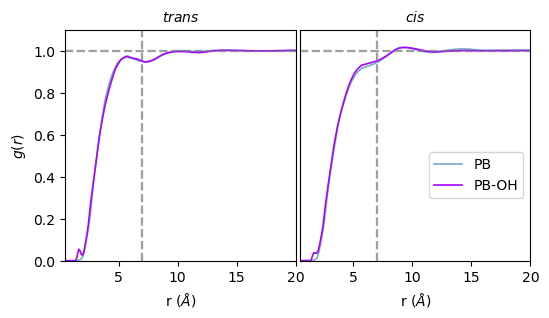

In [195]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
fig.subplots_adjust(hspace=0.05, wspace=0.02)

# fig.suptitle(
#     f"RDFs all atoms",
#     fontweight="bold",
#     fontsize=12,
#     y=1.05,
#     x=0.5,
#     ha = "center"
# )

for i, iso in enumerate(["trans", "cis"]):
    for sol in ["PB", "PB-OH"]:
        dataM = RDFStot_oh[sol][iso].copy()
        ax[i].set_title(r"$%s$" % iso, fontsize=10)
        
        ax[i].plot(
            dataM["r"], dataM["g_r"],
            label=f"{sol}",
            ls="-",
            lw=1.2,
            color=Param_color[sol],
            alpha=1.
        )
        
        ax[i].set_xlim(.5, 20.)
        ax[i].set_ylim(0.0, 1.1)
        ax[i].set_xlabel(r"r ($\AA$)")
        ax[i].set_ylabel(r"$g(r)$")
        ax[i].axvline(x=7., ls="--", color="gray", lw=1.6, alpha=0.5)
        ax[i].axhline(y=1., ls="--", color="gray", lw=1.6, alpha=0.5)
        
        if i > 0:
            # ax[i].set_yticks([])
            ax[i].get_yaxis().set_visible(False)
            
ax[1].legend(fontsize=10, bbox_to_anchor=(1., 0.5))
        
# saveFig("RDFS_all_means.png")
plt.show()

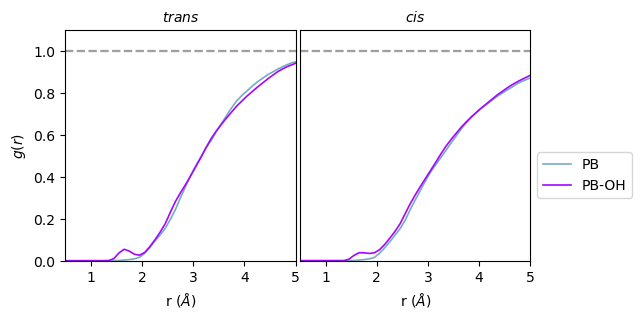

In [196]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
fig.subplots_adjust(hspace=0.05, wspace=0.02)

# fig.suptitle(
#     f"RDFs all atoms",
#     fontweight="bold",
#     fontsize=12,
#     y=1.05,
#     x=0.5,
#     ha = "center"
# )

for i, iso in enumerate(["trans", "cis"]):
    for sol in ["PB", "PB-OH"]:
        dataM = RDFStot_oh[sol][iso].copy()
        ax[i].set_title(r"$%s$" % iso, fontsize=10)
        
        ax[i].plot(
            dataM["r"], dataM["g_r"],
            label=f"{sol}",
            ls="-",
            lw=1.2,
            color=Param_color[sol],
            alpha=1.
        )
        
        ax[i].set_xlim(.5, 5.)
        ax[i].set_ylim(0.0, 1.1)
        ax[i].set_xlabel(r"r ($\AA$)")
        ax[i].set_ylabel(r"$g(r)$")
        ax[i].axvline(x=7., ls="--", color="gray", lw=1.6, alpha=0.5)
        ax[i].axhline(y=1., ls="--", color="gray", lw=1.6, alpha=0.5)
        
        if i > 0:
            # ax[i].set_yticks([])
            ax[i].get_yaxis().set_visible(False)
            
ax[1].legend(fontsize=10, bbox_to_anchor=(1., 0.5))
        
# saveFig("RDFS_all_means.png")
plt.show()

### Size and shape analysis PB-OH

In [231]:
POLPROP = {
    "Rg": {
        "color": "#2a90a6",
        "binwidth": .05,
        "xlim": [0.5, 3.0],
        "label": "Radius of gyration (nm)",
        "units": "nm"
    },
    "dmax": {
        "color": "#5b557b",
        "binwidth": .1,
        "xlim": [1.0, 9.0],
        "label": "Max. distance (nm)",
        "units": "nm"
    },
    "k2": {
        "color": "#fea6ad",
        "binwidth": .05,
        "xlim": [0, 1],
        "label": "Shape anisotropy",
        "units": ""
    },
    "rdf": {
        "color": "#3293f0",
        "xlim": [0.25, 2.5],
        "label": "g(r) PC - POL",
        "units": ""
        
    },
    "distance": {
        "color": "#66c0c0",
        "binwidth": .1,
        "xlim": [0, 4.0],
        "label": "distance",
        "units": "nm"
    }
}

In [229]:
r_azo = ["0", "1", "2", "3", "4"]
SIZES = {"cis": {}, "trans": {}}
ALLSIZES = {"cis": {}, "trans": {}}

for iso in SIZES:
    for r in r_azo:
        path_mol = f"../exp.azob.stamp.3/{iso}/9_prod_OH_{r}"
        try:
            dat = pd.read_csv(f"{path_mol}/molprop.csv")
        except FileNotFoundError:
            print("path:", path_mol, "NOT FOUNDED")
            continue
        if len(dat) == 0:
            print("path:", path_mol, "NOT FOUNDED")
            continue

        dat["time"] = dat["frame"].apply(nbconfig.toTime, freq=2.5, t0=502.5)
        dat["Rg"] *= 0.1
        dat["dmax"] *= 0.1
        
        SIZES[iso][r] = dat[dat["idx"] != 0]
        ALLSIZES[iso][r] = dat
        
SIZESMoh = {"cis": None, "trans": None}

for iso in SIZESMoh:
    SIZESMoh[iso] = pd.concat([SIZES[iso][d] for d in SIZES[iso]], ignore_index=True)

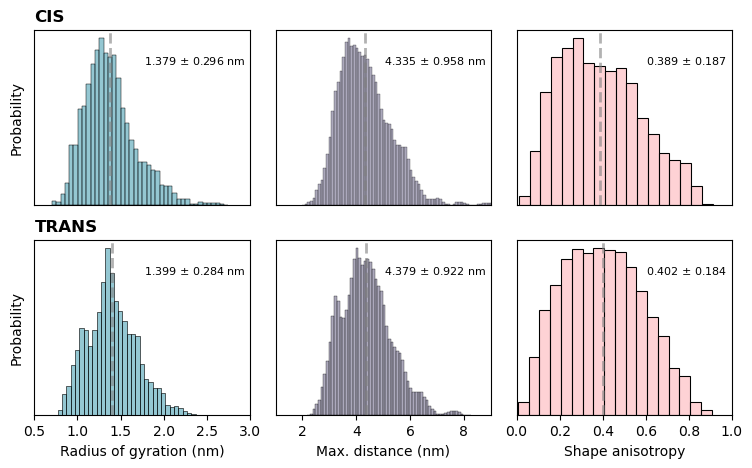

In [233]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9,5))

fig.subplots_adjust(hspace=0.2, wspace=0.12)

# fig.suptitle(
#     "Sizes and shape analysis of the polymeric matrix",
#     fontweight="bold",
#     fontsize=15,
#     y=0.95
# )

for i, iso in enumerate(SIZESMoh):
    ax[i, 0].set_title(iso.upper(), horizontalalignment="left", fontweight="bold", loc="left")
    for j, prop in enumerate(["Rg", "dmax", "k2"]):
        data = SIZESMoh[iso]
        formProp = POLPROP[prop]
        
        sns.histplot(
            data=data,
            x=prop,
            ax=ax[i, j],
            kde=False,
            color=formProp["color"],
            binwidth=formProp["binwidth"],
            stat="probability",
            alpha=0.5
        )
        
        ax[i, j].set_xlabel(formProp["label"])
        ax[i, j].set_xlim(formProp["xlim"])
        
        ax[i, j].text(
            0.98, 0.8,
            "{:.3f} $\pm$ {:.3f} {}".format(
                data[prop].mean(),
                data[prop].std(),
                formProp["units"]
            ),
            transform=ax[i, j].transAxes, ha="right", rotation=0, fontsize=8
        )
        
        ax[i, j].axvline(x=data[prop].mean(), ls="--", color="gray", lw=2.0, alpha=0.6)
        
        if i != 1:
            ax[i, j].get_xaxis().set_visible(False)
            
        if j == 0:
            ax[i, j].get_yaxis().set_ticks([])
        else:
            ax[i, j].get_yaxis().set_visible(False)

            
# saveFig("sizes_shapes_systems.png")
plt.show()
plt.close()

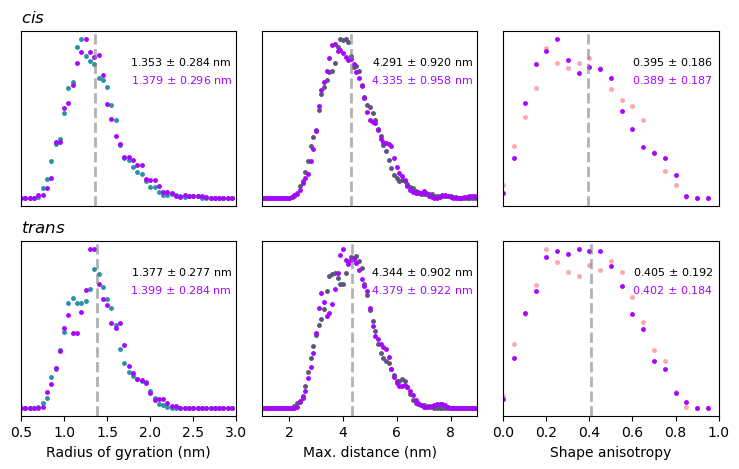

In [268]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9,5))

fig.subplots_adjust(hspace=0.2, wspace=0.12)

# fig.suptitle(
#     "Sizes and shape analysis of the polymeric matrix",
#     fontweight="bold",
#     fontsize=15,
#     y=0.95
# )

for i, iso in enumerate(SIZESM):
    ax[i, 0].set_title(labels[iso], horizontalalignment="left", loc="left")
    for j, prop in enumerate(["Rg", "dmax", "k2"]):
        data = SIZESM[iso]
        formProp = POLPROP[prop]
        
        bins = np.arange(
                formProp["xlim"][0],
                formProp["xlim"][1] + formProp["binwidth"],
                formProp["binwidth"]
            )
        
        hist, _ = np.histogram(data[prop], bins=bins, density=True)
        
        # sns.histplot(
        #     data=data,
        #     x=prop,
        #     ax=ax[i, j],
        #     kde=True,
        #     color=formProp["color"],
        #     binwidth=formProp["binwidth"],
        #     stat="probability",
        #     alpha=0.5
        # )
        
        ax[i,j].plot(
                bins[:-1],
                hist, ".", ms = 5, #label = sol.replace("POL", "PB") + r"  %.1f $\pm$ %.1f$^{\circ}$" % (ndata[torsion].mean(), ndata[torsion].std()),
                color=formProp["color"]
            )
        
        data_oh = SIZESMoh[iso]
        hist, _ = np.histogram(data_oh[prop], bins=bins, density=True)
        ax[i,j].plot(
                bins[:-1],
                hist, ".", ms = 5, #label = sol.replace("POL", "PB") + r"  %.1f $\pm$ %.1f$^{\circ}$" % (ndata[torsion].mean(), ndata[torsion].std()),
                color=Param_color["PB-OH"]
            )
        
        
        ax[i, j].set_xlabel(formProp["label"])
        ax[i, j].set_xlim(formProp["xlim"])
        
        ax[i, j].text(
            0.98, 0.8,
            "{:.3f} $\pm$ {:.3f} {}".format(
                data[prop].mean(),
                data[prop].std(),
                formProp["units"]
            ),
            transform=ax[i, j].transAxes, ha="right", rotation=0, fontsize=8
        )
        
        ax[i, j].text(
            0.98, 0.7,
            "{:.3f} $\pm$ {:.3f} {}".format(
                data_oh[prop].mean(),
                data_oh[prop].std(),
                formProp["units"]
            ),
            transform=ax[i, j].transAxes, ha="right", rotation=0, fontsize=8,
            color=Param_color["PB-OH"]
        )
        
        ax[i, j].axvline(x=data[prop].mean(), ls="--", color="gray", lw=2.0, alpha=0.6)
        
        if i != 1:
            ax[i, j].get_xaxis().set_visible(False)
            
        if j == 0:
            ax[i, j].get_yaxis().set_ticks([])
        else:
            ax[i, j].get_yaxis().set_visible(False)

            
# saveFig("sizes_shapes_systems.png")
saveFig("PBOH_vs_PB_prop.png")
plt.show()
plt.close()

### CM distances PB-OH

### Closest distance PB-OH

In [242]:
%%time

r_azo = ["1", "2", "3", "4"]
DISTCLOSE_oh = {"cis": {}, "trans": {}}
kwargs = {
    "rmin": 0.00,
    "rmax": 3.01,
    "binwidth": 0.01
}

for iso in DISTCLOSE_oh:
    for r in r_azo:
        print(f"Isomer {iso} - Replica {r}")
        DISTCLOSE_oh[iso][r] = {}
        path_mol = f"../exp.azob.stamp.3/{iso}/9_prod_OH_{r}"
        
        dist = pd.read_csv(f"{path_mol}/closest_d_To_0.csv")
        dist["distance"] *= 0.1
        
        dat = pd.read_csv(f"{path_mol}/molprop.csv")
        dat["time"] = dat["frame"].apply(nbconfig.toTime, freq=2.5, t0=502.5)
        dat["Rg"] *= 0.1
        dat["dmax"] *= 0.1
        
        pol = dat[dat["idx"] != 0].copy()
        
        dprop = pd.DataFrame({
            "distance": dist["distance"].values,
            "Rg": pol["Rg"].values,
            "k2": pol["k2"].values,
            "dmax": pol["dmax"].values,
            "time": pol["time"].values,
            "frame": pol["frame"].values
        })
        
        # print(dprop)
        DISTCLOSE_oh[iso][r]["dprop"] = dprop
        
        mol = STAMP(f"{path_mol}/DONNEES.in")
        box_in_frame = mol.box_in_frame
        
        box_in_frame[:, 0:3] *= 0.1
        
        rdf = rdf_from_dist(dprop, box_in_frame, **kwargs)
        rdf_bin = rdf.set_index("bin", inplace=False)
        
        dprop_binned = dprop.copy()
        dprop_binned["distance"] = dprop_binned["distance"].apply(nbconfig.binned_distance, **kwargs)
        
        dprop_binned.dropna(axis=0, inplace=True)
        
        dprop_binned["gr"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "gr"])
        dprop_binned["w"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "weihts"])
        
        
        DISTCLOSE_oh[iso][r]["rdf"] = rdf
        DISTCLOSE_oh[iso][r]["dbind"] = dprop_binned
        print(80 * "=")

print("Finish!")

Isomer cis - Replica 1
Reading log file - done in 0.27 s
Reading fatomes file - done in 0.14 s
Searching connectivity - done in 1.94 s
Number of frames 20000
Isomer cis - Replica 2
Reading log file - done in 0.28 s
Reading fatomes file - done in 0.13 s
Searching connectivity - done in 1.95 s
Number of frames 20000
Isomer cis - Replica 3
Reading log file - done in 0.28 s
Reading fatomes file - done in 0.14 s
Searching connectivity - done in 1.92 s
Number of frames 20000
Isomer cis - Replica 4
Reading log file - done in 0.26 s
Reading fatomes file - done in 0.98 s
Searching connectivity - done in 1.95 s
Number of frames 20000
Isomer trans - Replica 1
Reading log file - done in 0.27 s
Reading fatomes file - done in 0.13 s
Searching connectivity - done in 1.94 s
Number of frames 20000
Isomer trans - Replica 2
Reading log file - done in 0.27 s
Reading fatomes file - done in 0.14 s
Searching connectivity - done in 1.94 s
Number of frames 20000
Isomer trans - Replica 3
Reading log file - done

In [243]:
%%time

STDCUM_oh = {}
RDFGLOB_oh = {}
kwargs = {
    "rmin": 0.00,
    "rmax": 3.01,
    "binwidth": 0.01
}

for iso in DISTCLOSE_oh:
    STDCUM_oh[iso] = {}
    RDFGLOB_oh[iso] = {}
    data_list = []
    box_list = []
    isoms = ""
    count_frames = 0
    for r in DISTCLOSE_oh[iso]:
        isoms += " " + r
        print(f"Isomer: {iso} - Replicas: {isoms}")
        RDFGLOB_oh[iso][isoms] = {}
        data = DISTCLOSE_oh[iso][r]["dprop"].copy()
        data["bin"] = data["distance"].apply(nbconfig.binned_distance, **kwargs)
        data.dropna(axis=0, inplace=True)
        frames_ndx = list(data["frame"].unique())
        data["frame"] += count_frames
        
        frames = data["frame"].unique()
        print("Numbers of frames:", len(frames), count_frames + len(frames))
        
        # data.drop(columns=["time", "frame"], inplace=True)
        
        data_list.append(data)
        print(len(data_list))
        newData = pd.concat(data_list, ignore_index=True)
        print("Data size:", newData.shape)
                
        #-------------
        # Calcule
        #-------------
        dfresume = newData.groupby("bin").agg(nbconfig.aggregation)
        dfresume.reset_index(inplace=True)
        # print(dfresume)
        STDCUM3[iso][isoms] = dfresume.copy()
        #-------------
        # RDF
        #-------------
        print("rdf")
        path_mol = f"../exp.azob.stamp.3/{iso}/9_prod_OH_{r}"
        mol = STAMP(f"{path_mol}/DONNEES.in", loadConnect=False)
        box_in_frame = mol.box_in_frame[frames_ndx, 0:3]
        box_in_frame[:, 0:3] *= 0.1
        
        box_list.append(box_in_frame)
        newBoxs = np.concatenate(box_list)
        print(newBoxs.shape)
        
        rdf = rdf_from_dist(newData, newBoxs, **kwargs)
        rdf_bin = rdf.set_index("bin", inplace=False)
        
        dprop_binned = newData.copy()
        dprop_binned["distance"] = dprop_binned["distance"].apply(nbconfig.binned_distance, **kwargs)
        
        dprop_binned.dropna(axis=0, inplace=True)
        
        dprop_binned["gr"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "gr"])
        dprop_binned["w"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "weihts"])
        
        RDFGLOB_oh[iso][isoms]["dprop"] = newData
        RDFGLOB_oh[iso][isoms]["rdf"] = rdf
        RDFGLOB_oh[iso][isoms]["dbinned"] = dprop_binned
        
        count_frames += len(frames)
        
        
        print(80 * "=")
        
    print("")
        
print("Finish!")

Isomer: cis - Replicas:  1
Numbers of frames: 20000 20000
1
Data size: (1432853, 7)
rdf
Reading log file - done in 0.27 s
Number of frames 20000
(20000, 3)
Isomer: cis - Replicas:  1 2
Numbers of frames: 20000 40000
2
Data size: (2861187, 7)
rdf
Reading log file - done in 0.27 s
Number of frames 20000
(40000, 3)
Isomer: cis - Replicas:  1 2 3
Numbers of frames: 20000 60000
3
Data size: (4299673, 7)
rdf
Reading log file - done in 0.27 s
Number of frames 20000
(60000, 3)
Isomer: cis - Replicas:  1 2 3 4
Numbers of frames: 20000 80000
4
Data size: (5726937, 7)
rdf
Reading log file - done in 0.27 s
Number of frames 20000
(80000, 3)

Isomer: trans - Replicas:  1
Numbers of frames: 20000 20000
1
Data size: (1439849, 7)
rdf
Reading log file - done in 0.27 s
Number of frames 20000
(20000, 3)
Isomer: trans - Replicas:  1 2
Numbers of frames: 20000 40000
2
Data size: (2843951, 7)
rdf
Reading log file - done in 0.27 s
Number of frames 20000
(40000, 3)
Isomer: trans - Replicas:  1 2 3
Numbers of f

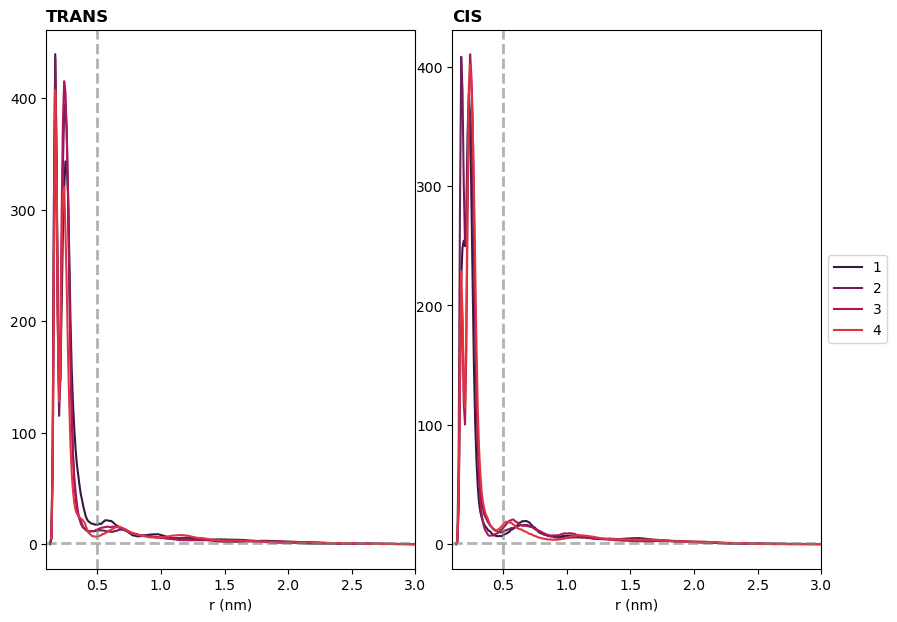

In [245]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,7))

fig.subplots_adjust(hspace=0.2, wspace=0.1)

# fig.suptitle(
#     "RDF from closest distance per replica",
#     fontweight="bold",
#     fontsize=15,
#     y=0.95
# )


for j, iso in enumerate(["trans", "cis"]):
    ax[j].set_title(iso.upper(), horizontalalignment="left", fontweight="bold", loc="left")

    for i, r in enumerate(DISTCLOSE_oh[iso]):
        rdf = DISTCLOSE_oh[iso][r]["rdf"]
        ax[j].plot(rdf["bin"], rdf["gr"], label=r)

    ax[j].set_xlabel("r (nm)")
    ax[j].set_xlim(0.1, 3.)
        
    ax[j].axhline(y=1., ls="--", color="gray", lw=2.0, alpha=0.6)
    ax[j].axvline(x=.5, ls="--", color="gray", lw=2.0, alpha=0.6)
    
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# saveFig("rdf_closest_distance.png")
plt.show()
plt.close()

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=8, figsize=(20,8))

fig.subplots_adjust(hspace=0.2, wspace=0.55)

#fig.suptitle(
#    "Properties as a function of the closest distance",
#    fontweight="bold",
#    fontsize=15,
#    y=0.95
#)

col_init = {"cis": 4, "trans": 0}

for iso in ["trans", "cis"]:
    n = col_init[iso]
    
    ax[0, n].set_title(iso.upper(), horizontalalignment="left", fontweight="bold", loc="left")
    
    for j, r in enumerate(DISTCLOSE2[iso]):
        dat = DISTCLOSE2[iso][r]["dprop"]
        if n == 0:
            ax[j, 0].text(
                -.8, 0.95,
                "replica {}".format(r),
                transform=ax[j, 0].transAxes,
                bbox=nbconfig.boxText,
                ha="left",
                va="center",
                fontsize=10,
                rotation=0)

        
        for i, prop in enumerate(["distance", "Rg", "dmax", "k2"]):
            i += n
            if i == n:
                sns.histplot(
                    data=dat,
                    x=prop,
                    ax=ax[j, i],
                    binwidth=POLPROP2[prop]["binwidth"],
                    color=POLPROP2[prop]["color"]
                )
            else:
                sns.histplot(
                    data=dat,
                    x="distance",
                    y=prop,
                    ax=ax[j, i],
                    binwidth=[POLPROP2["distance"]["binwidth"], POLPROP2[prop]["binwidth"]],
                    color=POLPROP2[prop]["color"]
                )
                
            if j != 4:
                ax[j, i].get_xaxis().set_visible(False)
            else:
                ax[j, i].set_xlabel("Distance (nm)")
            
            ax[j, i].set_xlim(0.1, .6)

# saveFig("systems_closest_distance.png")
plt.show()
plt.close()

In [246]:
dictW = get_dict2w(RDFGLOB_oh["trans"][" 1 2 3 4"]["rdf"])

for iso in RDFGLOB_oh:
    RDFGLOB_oh[iso][" 1 2 3 4"]["dprop"]["w"] = RDFGLOB_oh[iso][" 1 2 3 4"]["dprop"]["bin"].apply(lambda x: dictW[round(x, 2)])

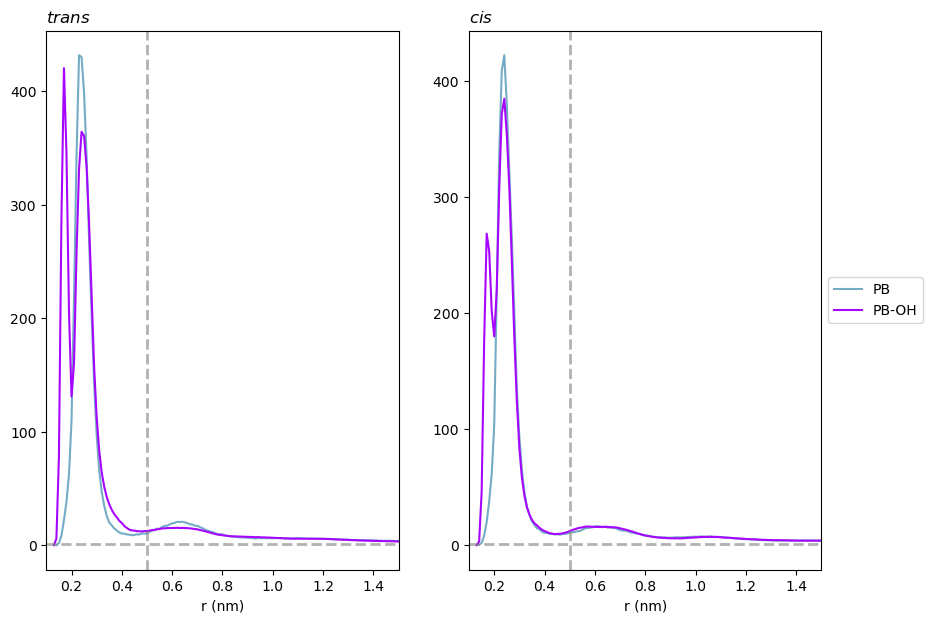

In [267]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,7))

fig.subplots_adjust(hspace=0.2, wspace=0.2)

# fig.suptitle(
#     "RDF from closest distance per replica",
#     fontweight="bold",
#     fontsize=15,
#     y=0.95
# )


for j, iso in enumerate(["trans", "cis"]):
    ax[j].set_title(r"$%s$" % iso, horizontalalignment="left", loc="left")

    rdf = RDFGLOB3[iso][" 0 1 2 3 4"]["rdf"]
    ax[j].plot(rdf["bin"], rdf["gr"], label="PB", color=Param_color["PB"])
    
    rdf = RDFGLOB_oh[iso][" 1 2 3 4"]["rdf"]
    ax[j].plot(rdf["bin"], rdf["gr"], label="PB-OH", color=Param_color["PB-OH"])

    ax[j].set_xlabel("r (nm)")
    ax[j].set_xlim(0.1, 1.5)
        
    ax[j].axhline(y=1., ls="--", color="gray", lw=2.0, alpha=0.6)
    ax[j].axvline(x=.5, ls="--", color="gray", lw=2.0, alpha=0.6)
    
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# saveFig("rdf_closest_distance.png")
saveFig("PBOH_PB_rdf_clost.png")
plt.show()
plt.close()

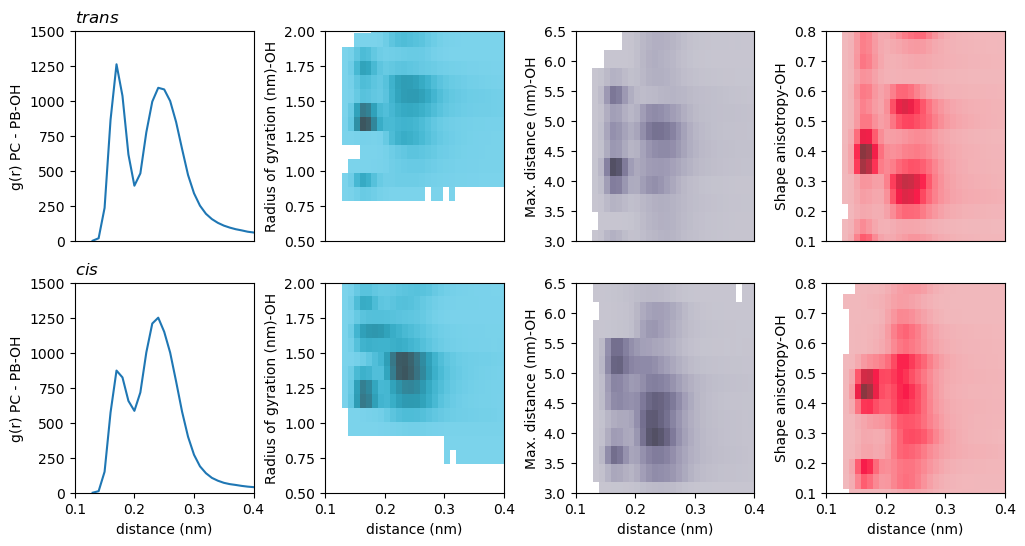

In [187]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,6))

fig.subplots_adjust(hspace=0.2, wspace=0.4)

#fig.suptitle(
#    "Evolution of desviation standard as a function of distance",
#    fontweight="bold",
#    fontsize=15,
#    y=0.97
#)

propLims = {
    "rdf": [0, 1500],
    "Rg": [0.5, 2],
    "dmax": [3., 6.5],
    "k2": [0.1, 0.8]
}

for i, iso in enumerate(["trans", "cis"]):
    ax[i, 0].set_title(r"$%s$" % iso, horizontalalignment="left", fontweight="bold", loc="left")  # - Replicas 0 1 2 3 4
    
    # data = STDCUM3[iso][" 0 1 2 3 4"].copy()
    data = RDFGLOB_oh[iso][" 1 2 3 4"]["dprop"].copy()
    rdf = RDFGLOB_oh[iso][" 1 2 3 4"]["rdf"].copy()
    # data.drop(index=0, inplace=True)
    # print(data)
    
    for j, prop in enumerate(["rdf", "Rg", "dmax", "k2"]):
        formProp = POLPROP2[prop]
        
        if prop == "rdf":
            ax[i, j].plot(rdf["bin"], rdf["gr"], label=r)
            
        else:
            """
            ax[i, j].errorbar(
                    data["bin"][""],
                    y=data[prop]["mean"],
                    yerr=data[prop]["std"],
                    fmt=".",
                    capsize=4,
                    color="black",
                    ecolor=POLPROP2[prop]["color"],
            )
            """
            sns.histplot(
                    data=data,
                    x="distance",
                    y=prop,
                    weights="w",
                    ax=ax[i, j],
                    binwidth=[POLPROP2["distance"]["binwidth"], POLPROP2[prop]["binwidth"]],
                    color=POLPROP2[prop]["color"]
                )


        ax[i, j].set_ylabel(formProp["label"]+"-OH")
        ax[i, j].set_xlabel("distance (nm)")
        ax[i, j].set_xlim(0.1, .4)
        ax[i, j].set_ylim(propLims[prop])
        
        if i == 0:
            ax[i, j].get_xaxis().set_visible(False)
                
#ax[0, 2].legend(loc='center left', bbox_to_anchor=(1, 0.))

# saveFig("sumReps_meansVals_closest_distance.png")
plt.show()
plt.close()

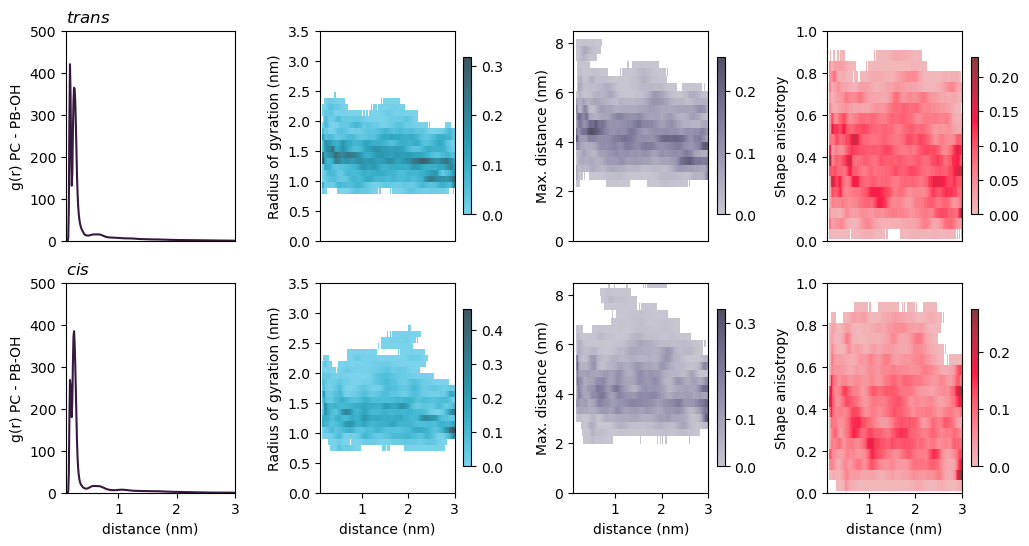

In [266]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,6))

fig.subplots_adjust(hspace=0.2, wspace=0.5)

#fig.suptitle(
#    "Evolution of desviation standard as a function of distance",
#    fontweight="bold",
#    fontsize=15,
#    y=0.97
#)

propLims = {
    "rdf": [0, 500],
    "Rg": [0.0, 3.5],
    "dmax": [0., 8.5],
    "k2": [0.0, 1.]
}

#sns.set_palette("rocket")
for i, iso in enumerate(["trans", "cis"]):
    ax[i, 0].set_title(labels[iso], horizontalalignment="left", loc="left")  # - Replicas 0 1 2 3 4
    
    # data = STDCUM3[iso][" 0 1 2 3 4"].copy()
    data = RDFGLOB_oh[iso][" 1 2 3 4"]["dprop"].copy()
    data = data[data["bin"] > data["bin"].min() + 0.02]
    rdf = RDFGLOB_oh[iso][" 1 2 3 4"]["rdf"].copy()
    # data.drop(index=0, inplace=True)
    # print(data)
    
    for j, prop in enumerate(["rdf", "Rg", "dmax", "k2"]):
        formProp = POLPROP2[prop].copy()
        
        if prop == "rdf":
            ax[i, j].plot(rdf["bin"], rdf["gr"], label=r)
            formProp["label"]+="-OH"
            
        else:

            plot = sns.histplot(
                    data=data,
                    x="distance",
                    y=prop,
                    weights=1/data["w"],
                    stat="count",
                    ax=ax[i, j],
                    binwidth=[POLPROP2["distance"]["binwidth"], POLPROP2[prop]["binwidth"]],
                    color=POLPROP2[prop]["color"],
                    cbar=True, cbar_kws=dict(shrink=.75)
                )
            
            # Set the color bar limits
            #cbar_limits = (0, 0.3)  # Change these values to your desired limits
            # plot.collections[0].colorbar.set_ticks([0, 0.1, 0.2, 0.3])  # Optional: Set custom tick values
            # plot.collections[0].colorbar.set_clim(*cbar_limits)


        ax[i, j].set_ylabel(formProp["label"])
        ax[i, j].set_xlabel("distance (nm)")
        ax[i, j].set_xlim(0.1, 3.)
        ax[i, j].set_ylim(propLims[prop])
        
        if i == 0:
            ax[i, j].get_xaxis().set_visible(False)
                
#ax[0, 2].legend(loc='center left', bbox_to_anchor=(1, 0.))

# saveFig("sumReps_meansVals_closest_distance.png")
saveFig("PBOH_dist_prop_map.png")
plt.show()
plt.close()

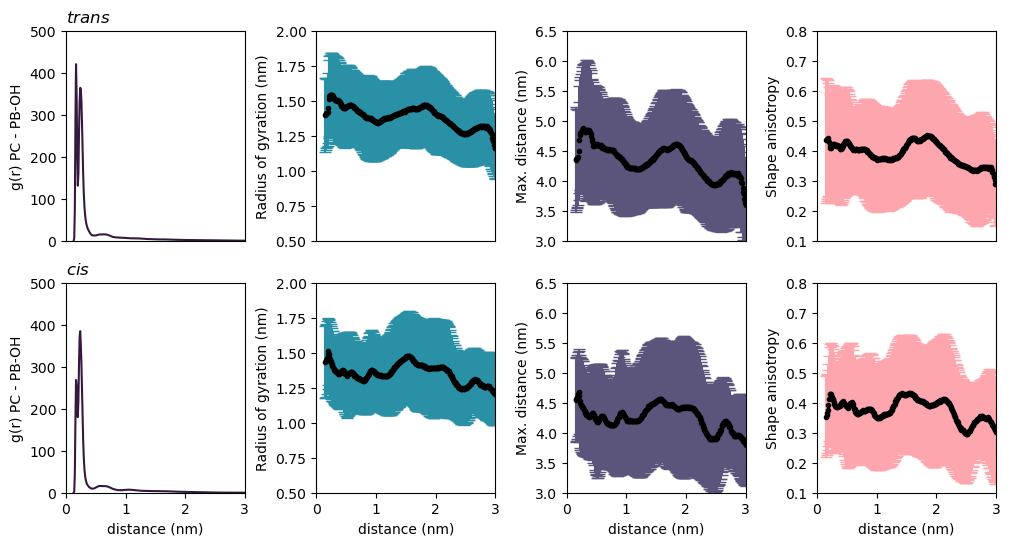

In [273]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,6))

fig.subplots_adjust(hspace=0.2, wspace=0.4)

#fig.suptitle(
#    "Evolution of desviation standard as a function of distance",
#    fontweight="bold",
#    fontsize=15,
#    y=0.97
#)

propLims = {
    "rdf": [0, 500],
    "Rg": [0.5, 2],
    "dmax": [3., 6.5],
    "k2": [0.1, 0.8]
}

for i, iso in enumerate(["trans", "cis"]):
    ax[i, 0].set_title(labels[iso], horizontalalignment="left", loc="left")
    
    data = STDCUM3[iso][" 1 2 3 4"].copy()
    data.drop(index=[0,1], inplace=True)
    rdf = RDFGLOB_oh[iso][" 1 2 3 4"]["rdf"].copy()
    
    for j, prop in enumerate(["rdf", "Rg", "dmax", "k2"]):
        formProp = POLPROP2[prop].copy()
        
        if prop == "rdf":
            ax[i, j].plot(rdf["bin"], rdf["gr"], label=r)
            formProp["label"]+="-OH"
            
        else:
            ax[i, j].errorbar(
                    data["bin"][""],
                    y=data[prop]["mean"],
                    yerr=data[prop]["std"],
                    fmt=".",
                    capsize=4,
                    color="black",
                    ecolor=POLPROP2[prop]["color"],
            )

        ax[i, j].set_ylabel(formProp["label"])
        ax[i, j].set_xlabel("distance (nm)")
        ax[i, j].set_xlim(0, 3.)
        ax[i, j].set_ylim(propLims[prop])
        
        if i == 0:
            ax[i, j].get_xaxis().set_visible(False)
                
#ax[0, 2].legend(loc='center left', bbox_to_anchor=(1, 0.))

saveFig("PBOH_dist_prop.png")
plt.show()
plt.close()